<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.316 Course Team, Copyright 2023 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# LECTURE 23 : Anomaly Detection


This lecture is going to review AI based anomaly detection using an astophysics dataset. For this dataset we are going to use data from the Gaia satellite. The Gaia dataset is a rich dataset that has previously been used for anomaly detection in this paper: https://arxiv.org/abs/2303.01529 and its predecessor: https://arxiv.org/abs/2104.12789 

Now lets load a toolkit to process Gaia data

In [191]:
# astropy imports
import astropy.coordinates as coord
from astropy.table import QTable
import astropy.units as u
from astroquery.gaia import Gaia

# Third-party imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# gala imports
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

#ML imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable


<h3>Setting Default Figure Parameters</h3>

The following code cell sets default values for figure parameters.


In [2]:
#>>>RUN: L10.0-runcell02

#set plot resolution
%config InlineBackend.figure_format = 'retina'

#set default figure parameters
plt.rcParams['figure.figsize'] = (9,6)

medium_size = 12
large_size = 15

plt.rc('font', size=medium_size)          # default text sizes
plt.rc('xtick', labelsize=medium_size)    # xtick labels
plt.rc('ytick', labelsize=medium_size)    # ytick labels
plt.rc('legend', fontsize=medium_size)    # legend
plt.rc('axes', titlesize=large_size)      # axes title
plt.rc('axes', labelsize=large_size)      # x and y labels
plt.rc('figure', titlesize=large_size)    # figure title

<a name='section_23_1'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C"> L23.1 The Gaia experiment </h2>  

The [Gaia](https://en.wikipedia.org/wiki/Gaia_(spacecraft)) experiment is a satellite experiment launched by the European Space Agency. This experiment has been running for the last 10 years and has bene focused on agglomerating nearby start data. There have been 3 data releases since the onset of the experiment with the first data coming from 2016. This experiment has had a large impact on our knowledge of the local galaxy by enabling a detailed catalog of nearby stars in the Milky Way.

Now before, we do anything, we would like to load Gaia data. For now, we are just going to collect the Gaia data. To do this, we make a database query to the Gaia database, and we will select the first 4096 Gaia stars that have a parallax significance > 10, and a parallax > 10, and the star velocity has been calculated. Fortunately, for us this is relatively easy to do, since its an SQL style query that we can pass into python. 

For this data, we are going to extract all the critical Gaia data that we get from the experiment. That is, we will get all the info Gaia by default gives us namely

  * Coordinates (ra,dec)
  * Parallax (which yields distance)
  * radial velocity
  * magnitude of 3 filters (general, blue and red)
  
From these, we can build a good understanding of stellar data.  One other small note is that we will use Gaia Data Release 3 (GaiaDR3) just so we have the latest greatest data to study. Later on we can take some more data. But lets start small for now. 


In [3]:
query_text = '''SELECT TOP 4096 ra, dec, parallax, pmra, pmdec, radial_velocity,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr3.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 10 AND
    radial_velocity IS NOT null
ORDER BY random_index
'''

job = Gaia.launch_job(query_text)
gaia_data = job.get_results()
gaia_data.write('gaia_data.fits',overwrite=True)
gaia_data = QTable.read('gaia_data.fits')
print(gaia_data[:4])


        ra                 dec              parallax              pmra              pmdec         radial_velocity    phot_g_mean_mag    phot_bp_mean_mag   phot_rp_mean_mag 
       deg                 deg                mas               mas / yr           mas / yr            km / s              mag                mag                mag        
------------------ ------------------- ------------------ ------------------- ------------------ ------------------ ------------------ ------------------ ------------------
132.10459270933268   2.271051596123523 12.599344304105063   4.013977357436915  66.10200703095197  35.98448181152344  11.12310791015625 11.694805145263672 10.408632278442383
251.09760693925082 -56.960100359866715 11.304311485078195  -35.37191646771424 -99.37431063079273  6.397059440612793 12.686421394348145 13.584908485412598 11.753893852233887
283.11044937721783 -26.150079226853457  12.38950294033803 -25.433928851662223 -58.70845697387051 -16.85479736328125 15.174003601074219 

The units of parallax are in milliarcseconds(mas). Distance is recorded in parsecs. A parsec corresponds to one arcsecond and also 3.25 light years. We can convert to parsecs to mas by noting that for a parallex in mas ($\theta_{\rm mas}$) the distance in parsecs is ($d_{\rm parsec}$) given by: 

$$
d_{\rm parsec} = \frac{1}{\theta_{\rm mas}\times10^{-3}}
$$

You will also notice in the above dataset 2 variables that lead us to radial velocity this is the proper motion in milliarcseconds per year. This is given in angular coordinates ra and dec. From this and the parallax we can obtain the radial velocity. 

Now astropy has lots of nice tools to do the conversion this for us. A very simple conversion we can do is got to distance. 


Min: 5.7638910777734065 pc Max: 99.99269310801444 pc
79.36920968769655 pc 0.07936920968769655 1 / mas


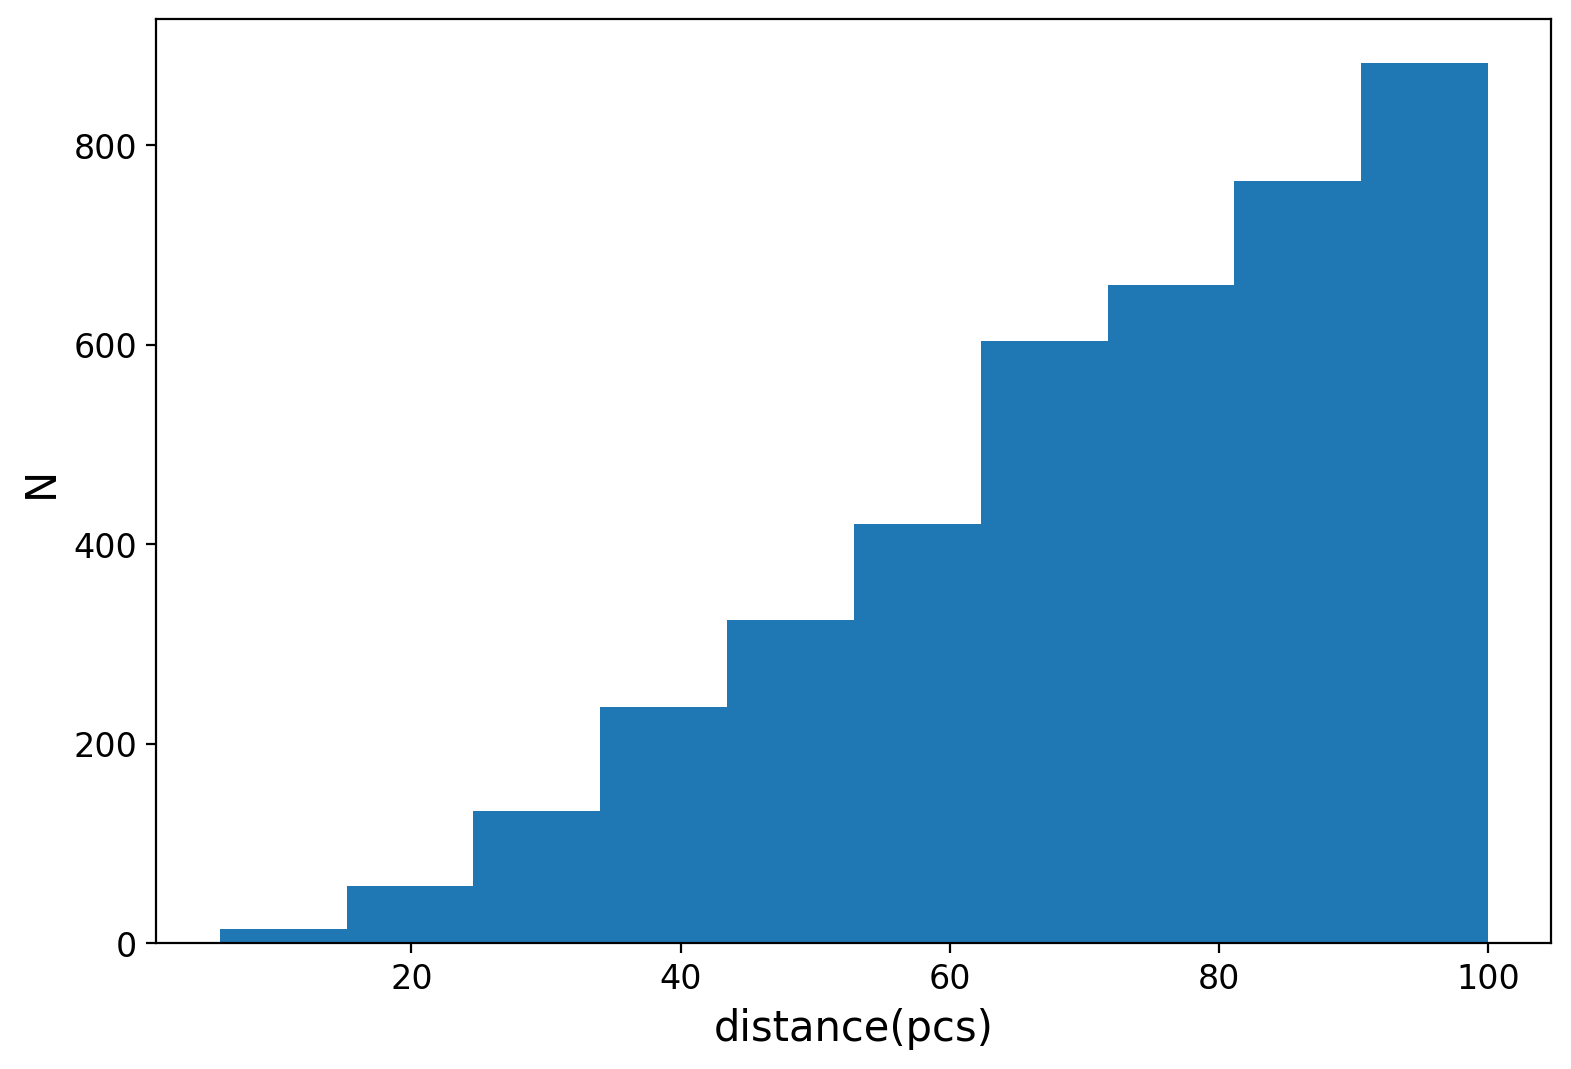

In [4]:
dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
print("Min:",dist.min(), "Max:",dist.max())
print(dist[0],1./gaia_data['parallax'][0])

plt.hist(dist)
plt.xlabel("distance(pcs)")
plt.ylabel("N")
plt.show()

Now given our position in the Milky way, the ra and dec of the star and the parallex, we can transform our star's location into galacto-centric coordinates. Let's go ahead and do that. Note this will also transofrm the velocities.

In [5]:
c = coord.SkyCoord(ra=gaia_data['ra'], dec=gaia_data['dec'],distance=dist,
                   pm_ra_cosdec=gaia_data['pmra'], pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])

print(c[:4],'\n')
print(c.galactic[:4])
coord.Galactocentric()

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(132.10459271,   2.2710516 , 79.36920969),
     (251.09760694, -56.96010036, 88.46182285),
     (283.11044938, -26.15007923, 80.71348825),
     (346.96675822,  26.85576486, 87.0630606 )]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(  4.01397736,  66.10200703,  35.98448  ),
     (-35.37191647, -99.37431063,   6.3970594),
     (-25.43392885, -58.70845697, -16.854797 ),
     (-36.02476515,  17.6570405 ,  11.243388 )]> 

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    [(225.058187  ,  26.90603218, 79.36920969),
     (330.79405571,  -7.28590727, 88.46182285),
     (  9.42421017, -11.79802614, 80.71348825),
     ( 96.03472171, -30.55091698, 87.0630606 )]
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-55.58921647,  35.99203189,  35.98448181),
     (-98.67922516, -37.26709822,   6.39705944),
     (-63.9673484 ,  -1.32136128, -16.85479736),
     (-24.17900018, 

<Galactocentric Frame (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.122 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=20.8 pc, roll=0.0 deg)>

Notice above the distances are the same. The above transform is just changing the angular coordinates to match the angular definition of hte galactic frame. To move the center of our coordinate system, we need to do one more transform. Compare the parallax with above. 

Also lets now look at the distances from the galactic center once we have transformed. 

<SkyCoord (Galactocentric: galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.1 kpc, galcen_v_sun=(12.9, 245.6, 7.78) km / s, z_sun=0.0 pc, roll=0.0 deg): (x, y, z) in pc
    [(-8149.9964855 , -50.09804513,  35.91669192),
     (-8023.40768962, -42.81649233, -11.21873771),
     (-8022.05796547,  12.93700513, -16.50273725),
     (-8107.88226044,  74.56135245, -44.25439202)]
 (v_x, v_y, v_z) in km / s
    [(-20.24299188, 241.9984383 , 36.1399495 ),
     ( -3.48323998, 207.3504228 , -8.53315539),
     (  0.52958142, 218.73669127, 10.73121548),
     ( 21.09983723, 262.95702135, 13.44375305)]> 



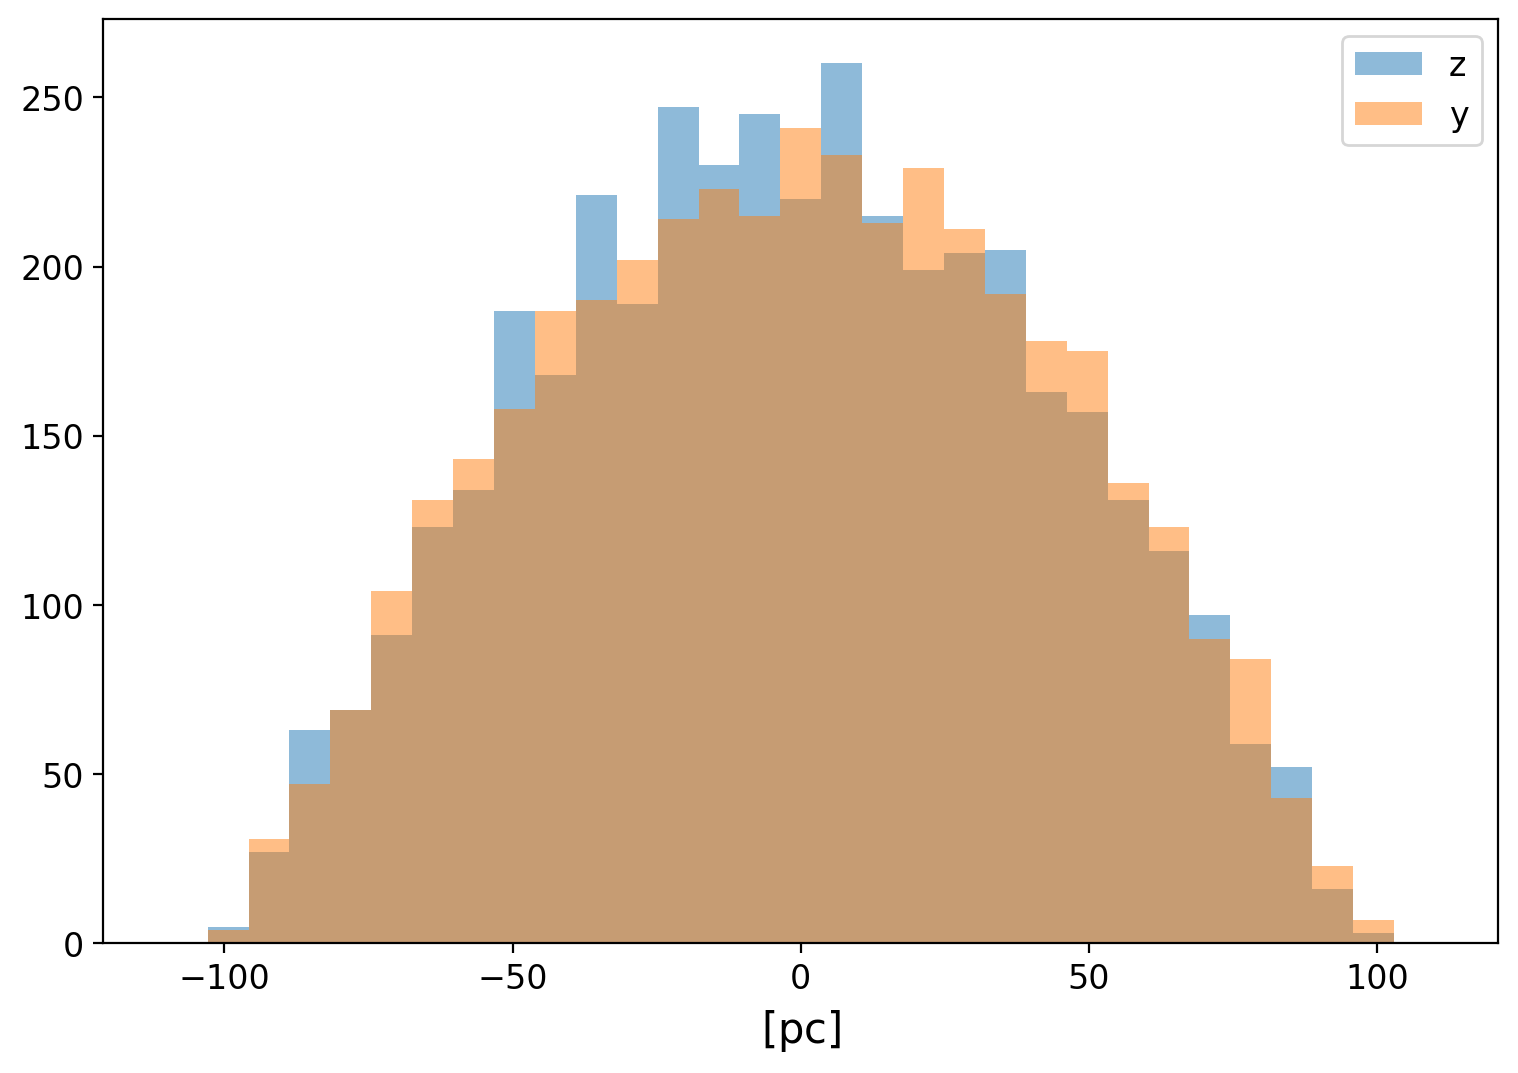

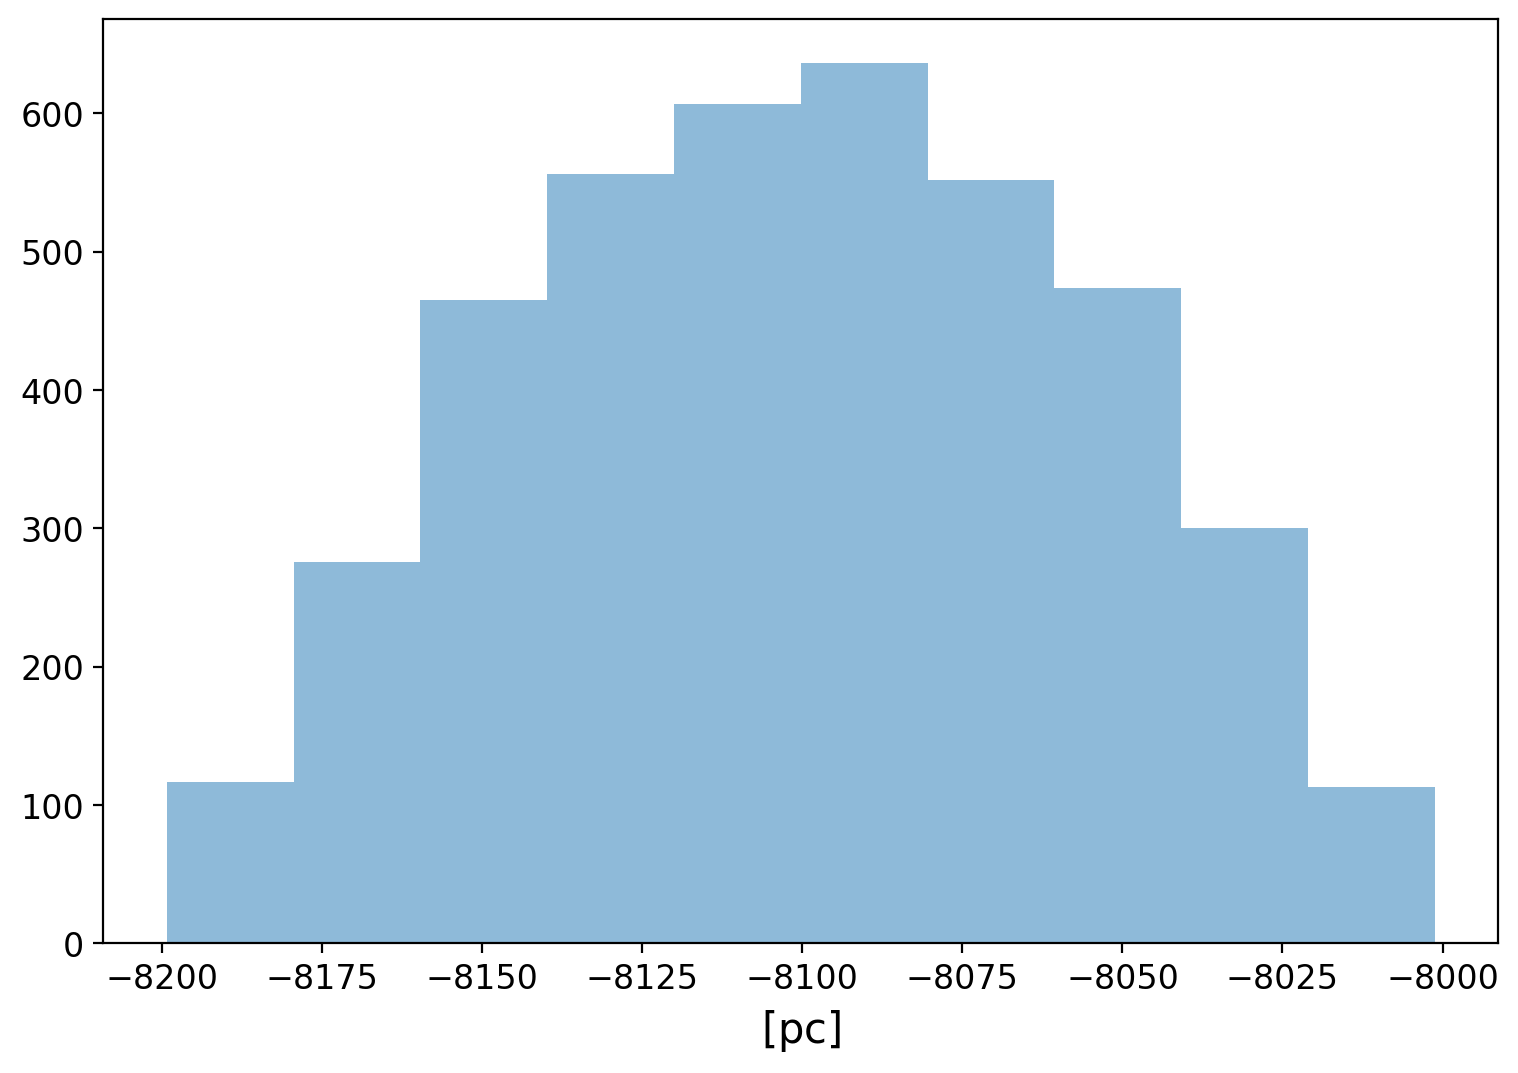

In [6]:
galcen = c.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8.1*u.kpc))
print(galcen[:4],'\n')
plt.hist(galcen.z.value, bins=np.linspace(-110, 110, 32),alpha=0.5,label='z')
#plt.hist(galcen.x.value, bins=np.linspace(-110, 110, 32),alpha=0.5)
plt.hist(galcen.y.value, bins=np.linspace(-110, 110, 32),alpha=0.5,label='y')
plt.xlabel('[{0:latex_inline}]'.format(galcen.z.unit));
plt.legend()
plt.show()

plt.hist(galcen.x.value, alpha=0.5)
plt.xlabel('[{0:latex_inline}]'.format(galcen.x.unit));
plt.show()


We can also look at the velocity of our transformed stars

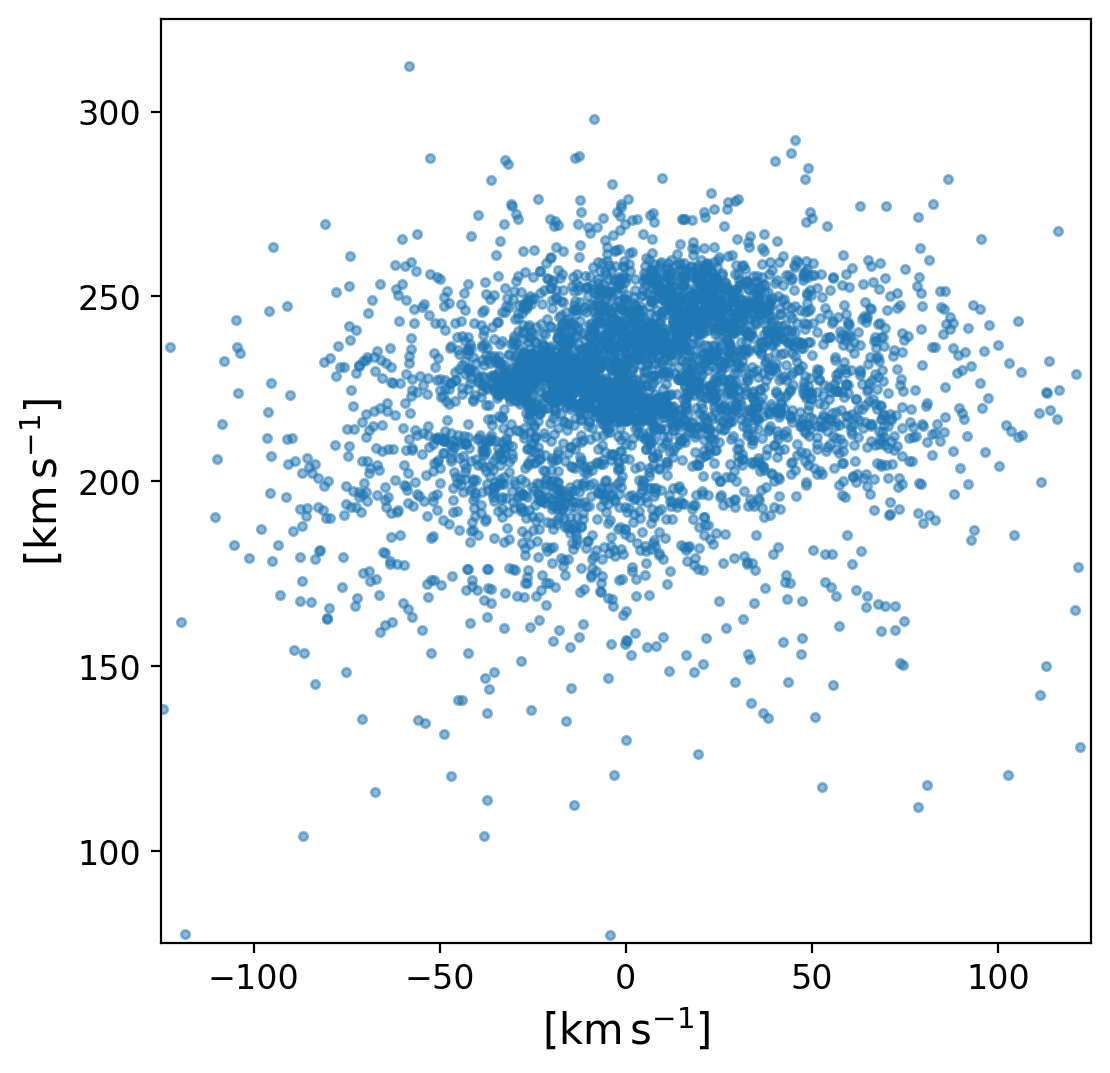

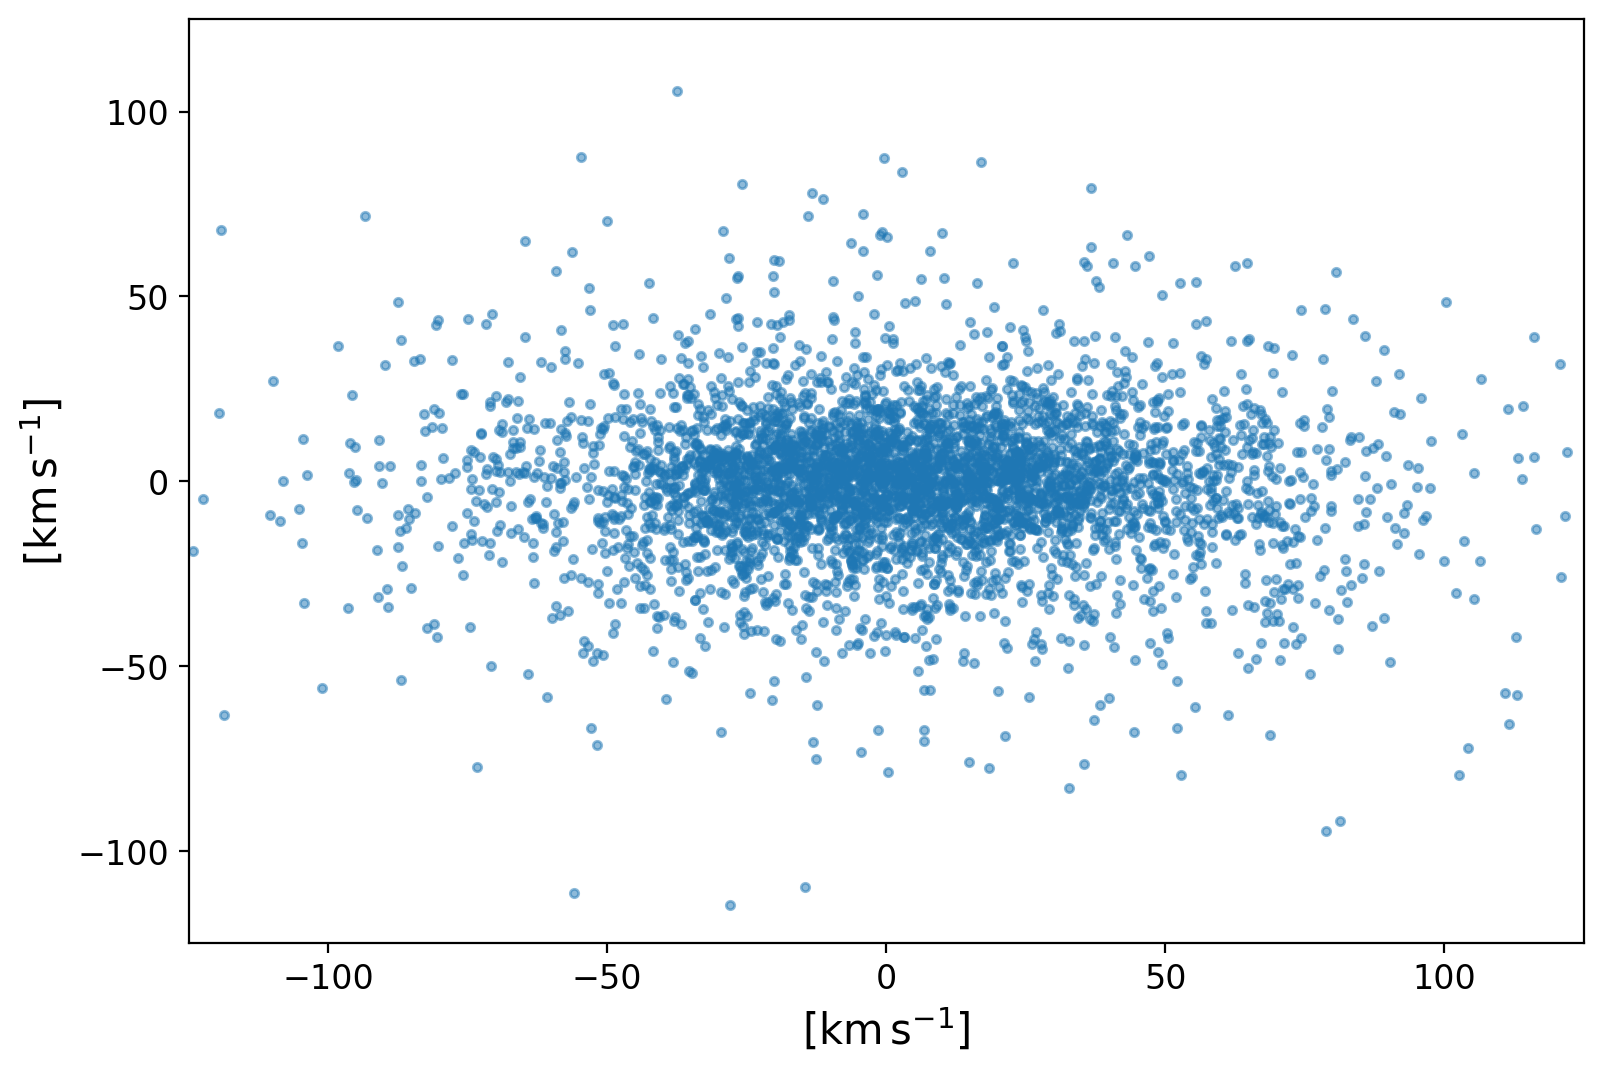

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(galcen.v_x.value, galcen.v_y.value,
        marker='.', linestyle='none', alpha=0.5)

ax.set_xlim(-125, 125)
ax.set_ylim(200-125, 200+125)

ax.set_xlabel('[{0:latex_inline}]'.format(u.km/u.s))
ax.set_ylabel('[{0:latex_inline}]'.format(u.km/u.s))
plt.show()

plt.plot(galcen.v_x.value, galcen.v_z.value,marker='.', linestyle='none', alpha=0.5)
plt.xlabel('[{0:latex_inline}]'.format(u.km/u.s))
plt.ylabel('[{0:latex_inline}]'.format(u.km/u.s))
plt.xlim(-125, 125)
plt.ylim(-125, 125)
plt.show()


Notice that the x and z velocity are centered around zero, and the y velocity is shifted to a specific direction. 

Now that we have transformed things. Lets do some basic analysis of the different stars to try to understand their properites. The Gaia satellite is capable of taking spectra in 3 different regimes : General, blue and red. The general is the inclusive filter and the blue and red tell us about the magnitude of the various color production. This information is enough for us to really start looking the the population of the different stars. 

Around 100 years ago, astronomers started classifying the different populations of stars and stumbled upon classification of star using a diagram known as the [Hertzsprung-Russell diagram](https://en.wikipedia.org/wiki/Hertzsprung%E2%80%93Russell_diagram). The strategy is to look at the intensity of the star as a function of the color of the start. Stars that are bluer tend to be larger and younger. Stars that are redder tend to be older and smaller. Anomalous stars, that are not bright but blue are known as white dwarfs. Likewise big giant red stars are known as red giants. Stars along the main sequence will evolve to red giants and then white dwarfs, with white dwarfs being the final stage. 

The H-R disgram can be made by taking the magnitude of the star and correctin for the distance modulus (ie $1/r^{2}$). Finally the star color can be foudn by computing the difference in luminosity between the blue and red filtered star. 

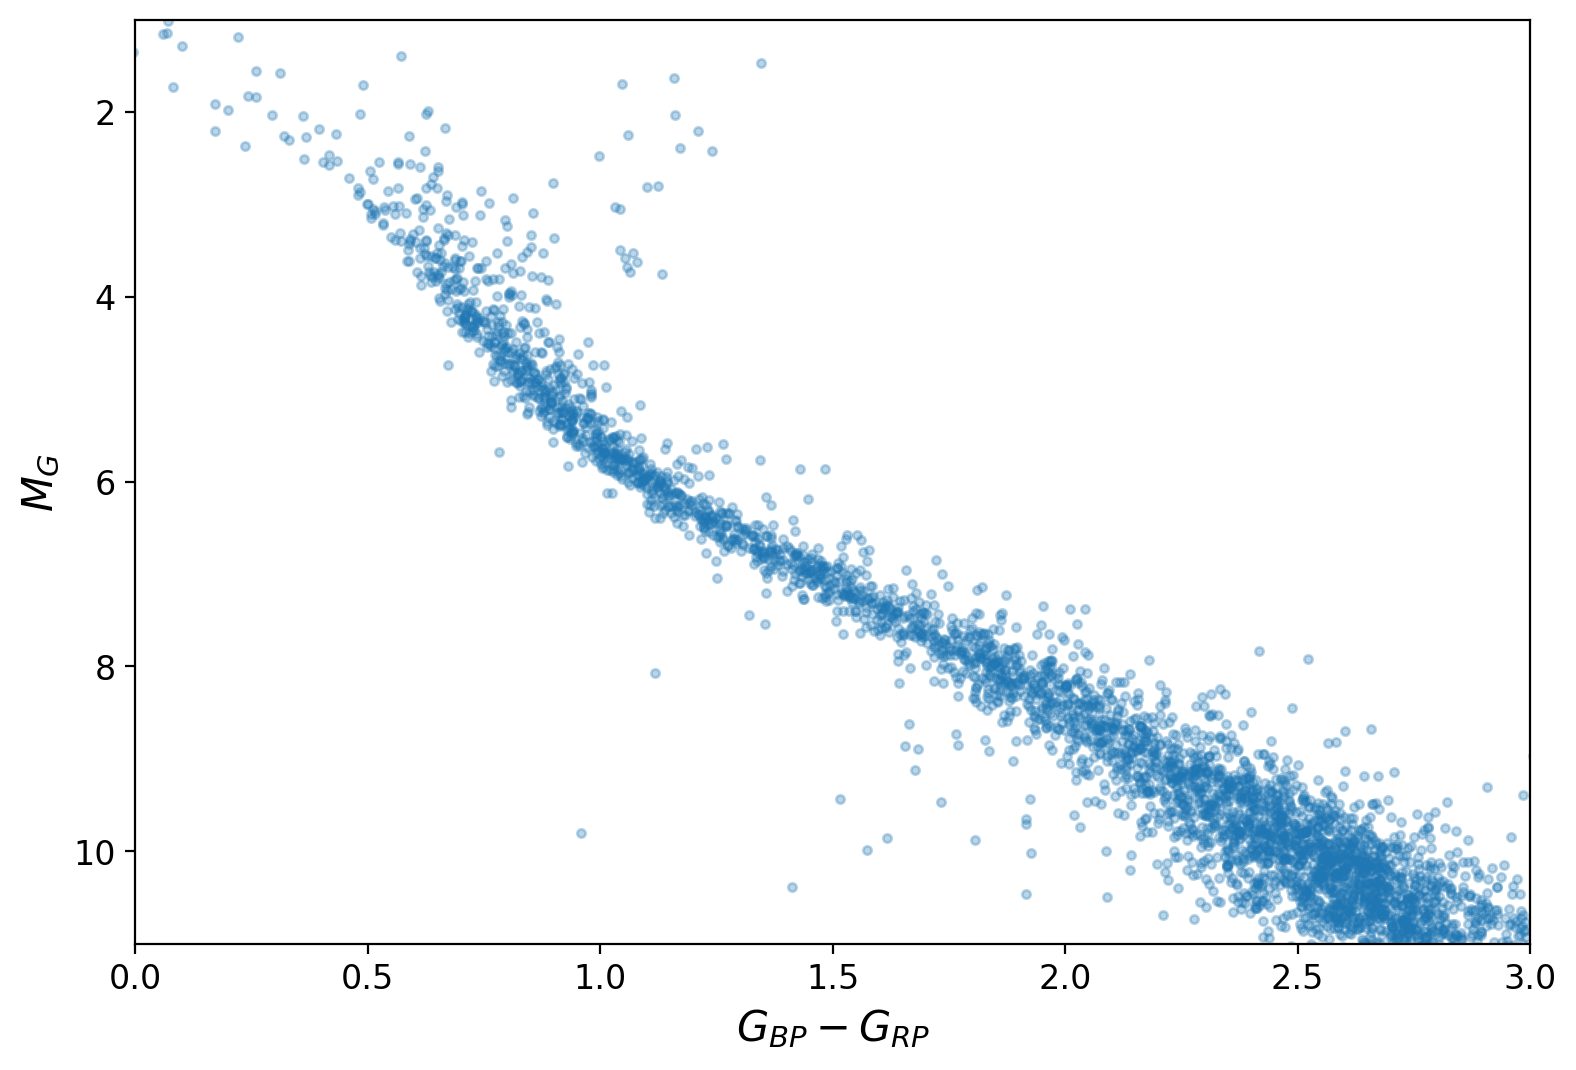

In [8]:
M_G = gaia_data['phot_g_mean_mag'] - dist.distmod
BP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']

plt.plot(BP_RP.value, M_G.value, marker='.', linestyle='none', alpha=0.3)

plt.xlim(0, 3)
plt.ylim(11, 1)

plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$M_{G}$')
plt.show()

Let's have a little fun with this data and see what we can do with it. A simple thing we can do is to look at where the big bright stars are compared to the small red stars. Lets go ahead and take a look. 

In [20]:
np.seterr(invalid="ignore")
#Blue > Red and 2 < Star < 3.75
hi_mass_mask = ((BP_RP > 0.5*u.mag) & (BP_RP < 0.7*u.mag) & (M_G > 2*u.mag) & (M_G < 3.75*u.mag))
#                &                 (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

#Blue > Red and 2 < Star < 3.75
lo_mass_mask = ((BP_RP > 2*u.mag) & (BP_RP < 2.4*u.mag) & (M_G > 8.2*u.mag) & (M_G < 9.7*u.mag))
#                &                (np.abs(galcen.v_y - 220*u.km/u.s) < 50*u.km/u.s))

hi_mass_color = 'tab:red'
lo_mass_color = 'tab:purple'
milky_way = gp.MilkyWayPotential()
milky_way

plt.plot(BP_RP.value, M_G.value, marker='.', linestyle='none', alpha=0.1)

for mask, color in zip([lo_mass_mask, hi_mass_mask],[lo_mass_color, hi_mass_color]):
    plt.plot(BP_RP[mask].value, M_G[mask].value, marker='.', linestyle='none', 
            alpha=0.5, color=color)

plt.xlim(0, 3)
plt.ylim(11, 1)

plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$M_{G}$')
plt.show()
     

Now lets look at the where these events live in the galaxy. Also, we can look at their velocity profiles. First lets look at their position in the Galaxy. 

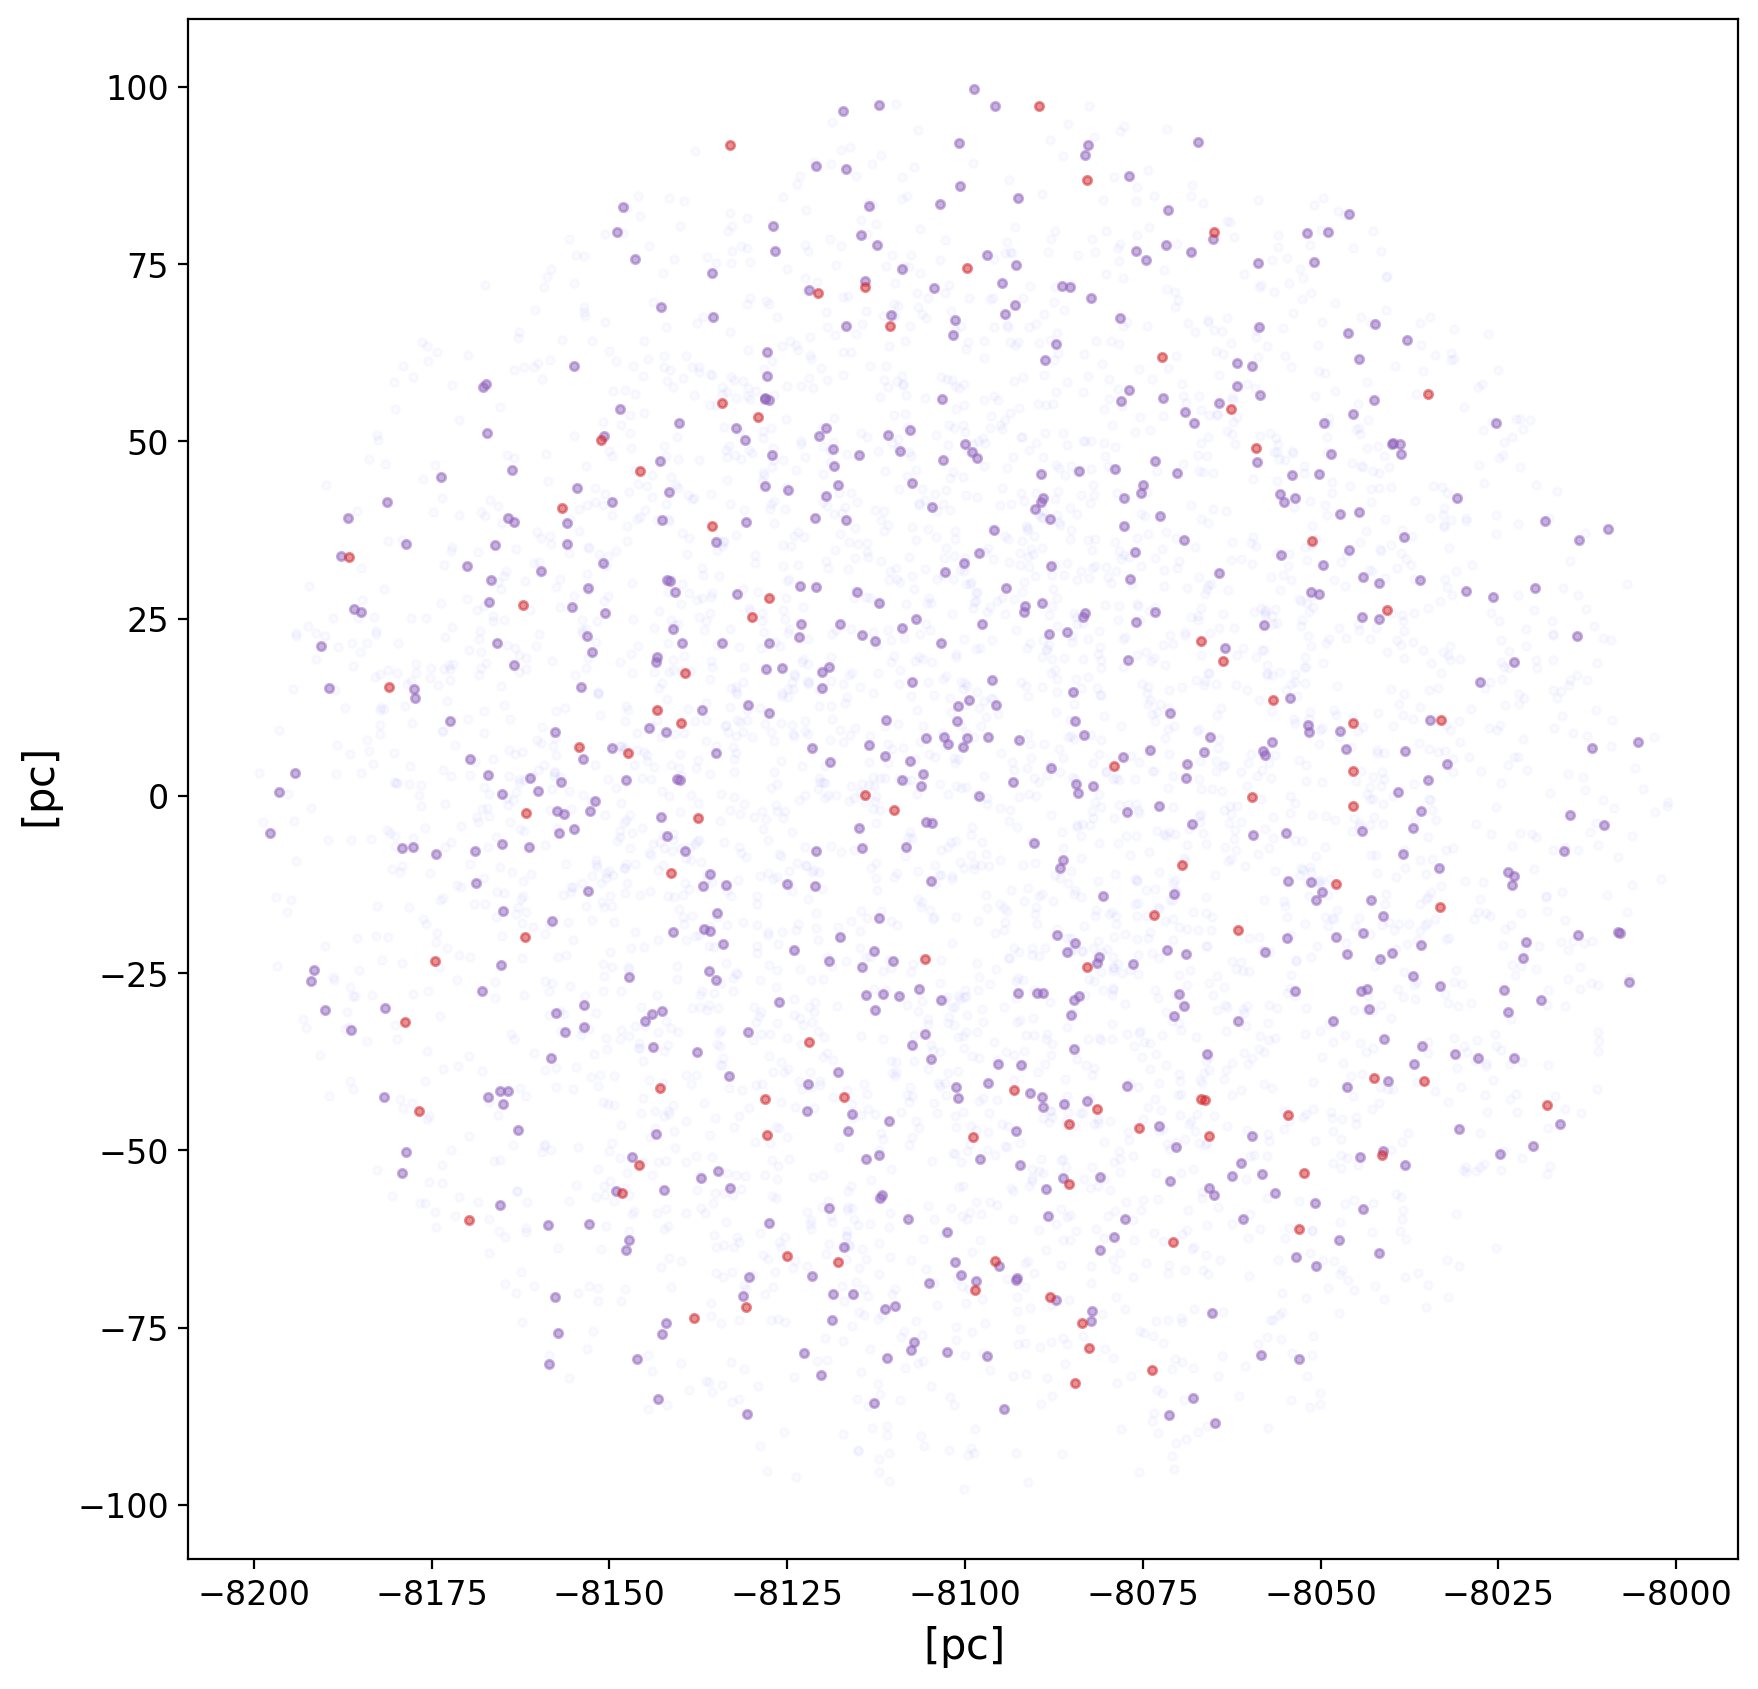

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

#ax.plot(galcen[1==1].v_x.value, galcen[1==1].v_z.value,marker='.', linestyle='none', alpha=0.02,color='blue')
#ax.plot(galcen[lo_mass_mask].v_x.value, galcen[lo_mass_mask].v_z.value,marker='.', linestyle='none', alpha=0.5,color=lo_mass_color)
#ax.plot(galcen[hi_mass_mask].v_x.value, galcen[hi_mass_mask].v_z.value,marker='.', linestyle='none', alpha=0.5,color=hi_mass_color)
#ax.set_xlabel('[{0:latex_inline}]'.format(u.km/u.s))
##ax.set_ylabel('[{0:latex_inline}]'.format(u.km/u.s))
#ax.set_xlim(-125, 125)
#ax.set_ylim(-125, 125)
#plt.show()

#ax.plot(galcen[1==1].v_y.value, galcen[1==1].v_z.value,marker='.', linestyle='none', alpha=0.02,color='blue')
#ax.plot(galcen[lo_mass_mask].v_y.value, galcen[lo_mass_mask].v_z.value,marker='.', linestyle='none', alpha=0.5,color=lo_mass_color)
#ax.plot(galcen[hi_mass_mask].v_y.value, galcen[hi_mass_mask].v_z.value,marker='.', linestyle='none', alpha=0.5,color=hi_mass_color)
#ax.set_xlabel('[{0:latex_inline}]'.format(u.km/u.s))
#ax.set_ylabel('[{0:latex_inline}]'.format(u.km/u.s))
#ax.set_xlim(100, 350)
#ax.set_ylim(-125, 125)
#plt.show()

#ax.plot(galcen[1==1].y.value, galcen[1==1].z.value,marker='.', linestyle='none', alpha=0.02,color='blue')
#ax.plot(galcen[lo_mass_mask].y.value, galcen[lo_mass_mask].z.value,marker='.', linestyle='none', alpha=0.5,color=lo_mass_color)
#ax.plot(galcen[hi_mass_mask].y.value, galcen[hi_mass_mask].z.value,marker='.', linestyle='none', alpha=0.5,color=hi_mass_color)
#ax.set_xlabel('[{0:latex_inline}]'.format(galcen.y.unit));
#ax.set_ylabel('[{0:latex_inline}]'.format(galcen.z.unit));
#plt.show()

ax.plot(galcen[1==1].x.value, galcen[1==1].y.value,marker='.', linestyle='none', alpha=0.02,color='blue')
ax.plot(galcen[lo_mass_mask].x.value, galcen[lo_mass_mask].y.value,marker='.', linestyle='none', alpha=0.5,color=lo_mass_color)
ax.plot(galcen[hi_mass_mask].x.value, galcen[hi_mass_mask].y.value,marker='.', linestyle='none', alpha=0.5,color=hi_mass_color)
ax.set_xlabel('[{0:latex_inline}]'.format(galcen.x.unit));
ax.set_ylabel('[{0:latex_inline}]'.format(galcen.y.unit));
plt.show()

There is no obvious deviation here. However, I think its clear after this class that plotting points doesn't really say much about broad deviations. Let's go ahead and make some histograms. 

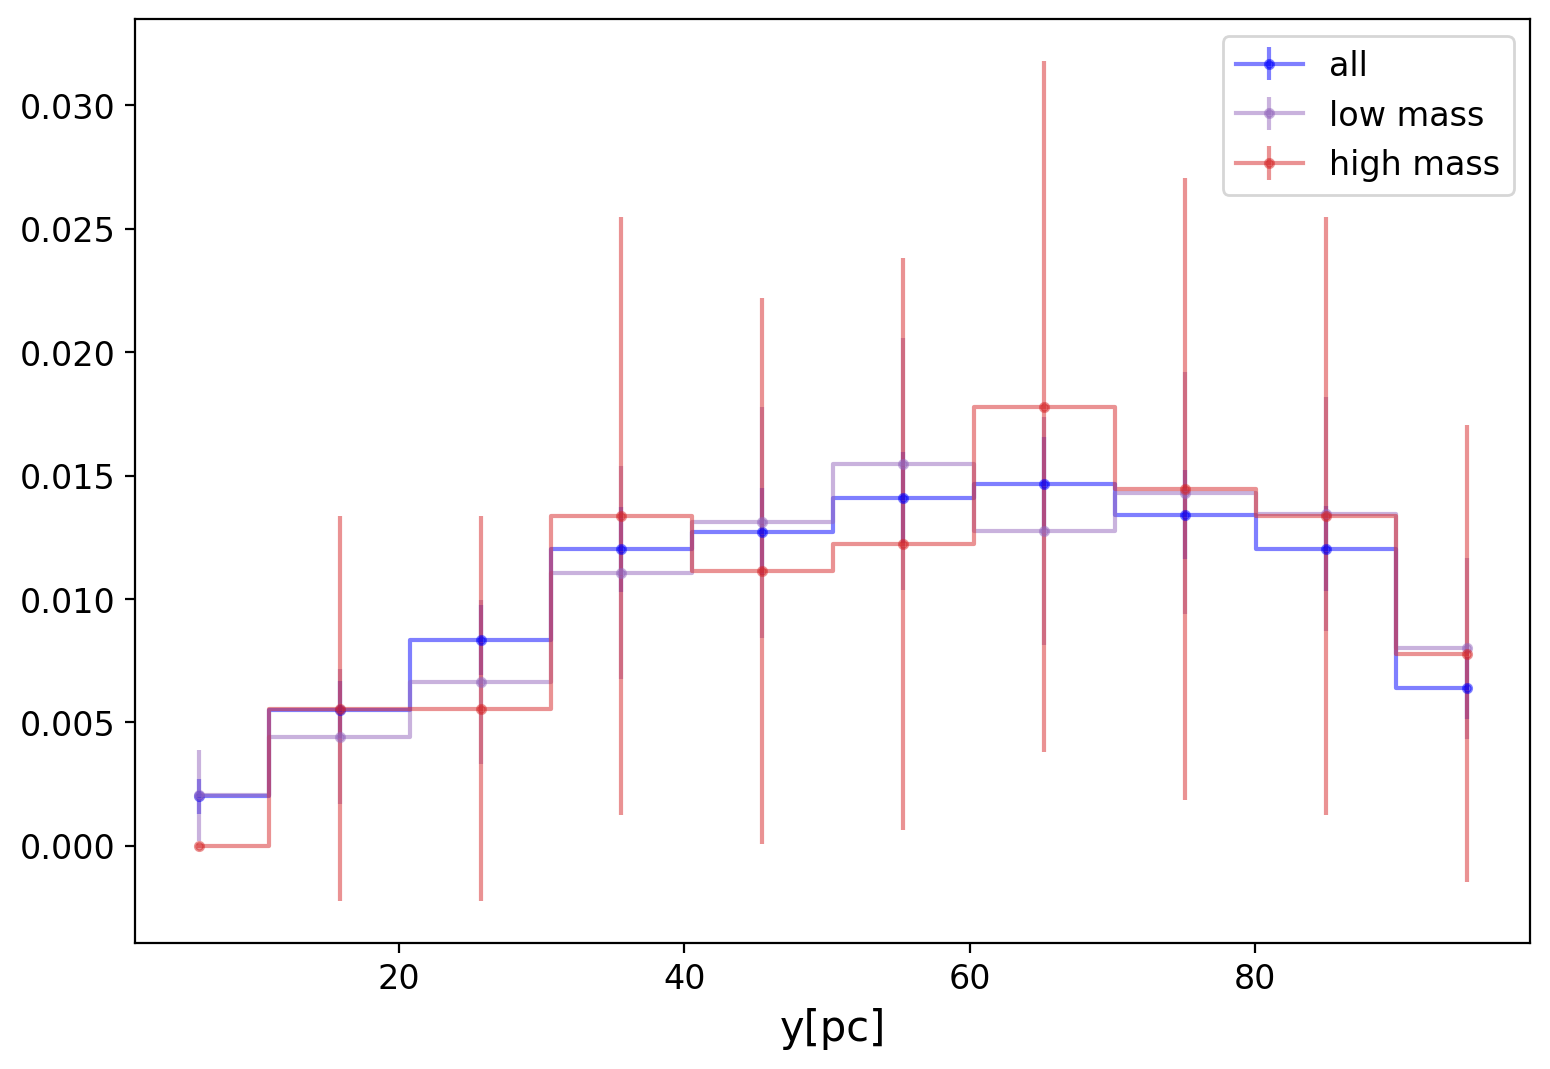

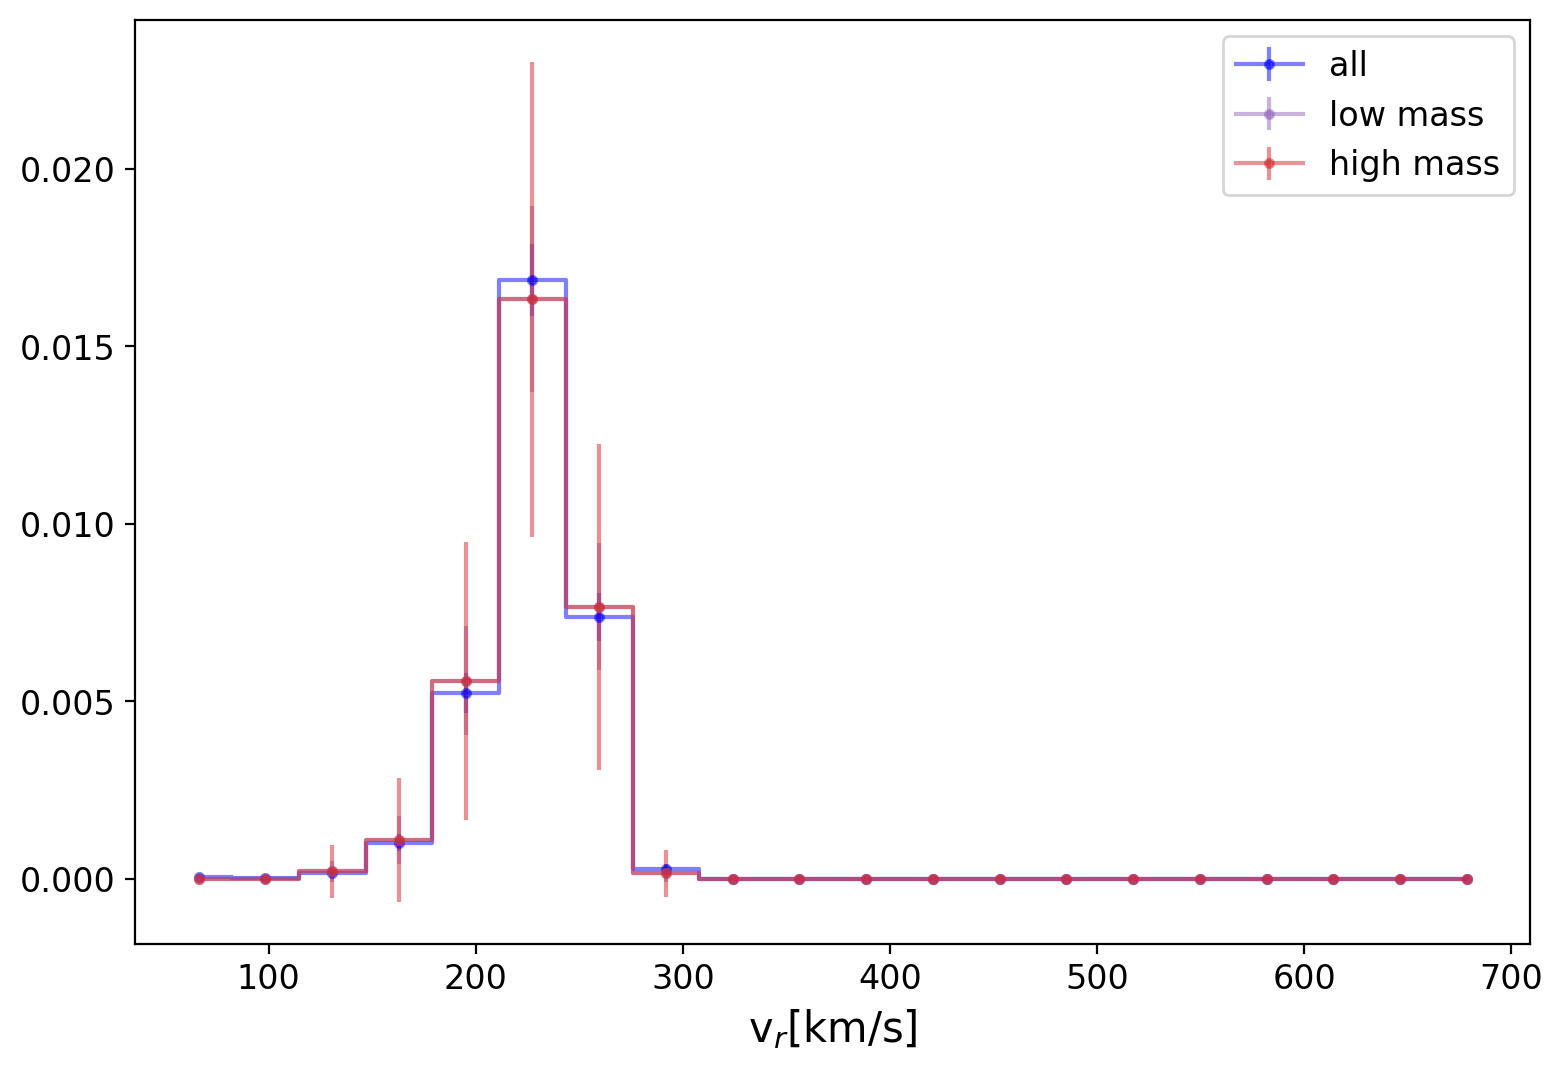

In [89]:
r_ce = np.sqrt(galcen[1==1]        .y.value**2 + galcen[1==1]        .z.value**2)
r_lo = np.sqrt(galcen[lo_mass_mask].y.value**2 + galcen[lo_mass_mask].z.value**2)
r_hi = np.sqrt(galcen[hi_mass_mask].y.value**2 + galcen[hi_mass_mask].z.value**2)

hist_ce, bin_edges = np.histogram(r_ce,bins=10, density=True)
hist_lo, bin_edges = np.histogram(r_lo, bins=bin_edges, density=True)
hist_hi, bin_edges = np.histogram(r_hi, bins=bin_edges, density=True)
bin_center = 0.5*(bin_edges[:-1] + bin_edges[1:])
sc=1./np.sqrt(len(galcen))
sl=1./np.sqrt(len(galcen[lo_mass_mask]))
sh=1./np.sqrt(len(galcen[hi_mass_mask]))
plt.errorbar(bin_center,hist_ce,yerr=sc*hist_ce**0.5,alpha=0.5,drawstyle="steps-mid",marker='.',color='blue',label='all')
plt.errorbar(bin_center,hist_lo,yerr=sl*hist_lo**0.5,alpha=0.5,drawstyle="steps-mid",marker='.',color=lo_mass_color,label='low mass')
plt.errorbar(bin_center,hist_hi,yerr=sh*hist_hi**0.5,alpha=0.5,drawstyle="steps-mid",marker='.',color=hi_mass_color,label='high mass')
plt.xlabel('y[pc]')
plt.legend()
plt.show()


vr_ce = np.sqrt(galcen[1==1]        .v_y.value**2 + galcen[1==1]        .v_x.value**2)
vr_lo = np.sqrt(galcen[lo_mass_mask].v_y.value**2 + galcen[lo_mass_mask].v_x.value**2)
vr_hi = np.sqrt(galcen[lo_mass_mask].v_y.value**2 + galcen[lo_mass_mask].v_x.value**2)

hist_ce, bin_edges = np.histogram(vr_ce,bins=20, density=True)
hist_lo, bin_edges = np.histogram(vr_lo, bins=bin_edges, density=True)
hist_hi, bin_edges = np.histogram(vr_hi, bins=bin_edges, density=True)
bin_center = 0.5*(bin_edges[:-1] + bin_edges[1:])
sc=0.5*1./np.sqrt(len(galcen))
sl=0.5*1./np.sqrt(len(galcen[lo_mass_mask]))
sh=0.5*1./np.sqrt(len(galcen[hi_mass_mask]))
plt.errorbar(bin_center,hist_ce,yerr=sc*hist_ce**0.5,alpha=0.5,drawstyle="steps-mid",marker='.',color='blue',label='all')
plt.errorbar(bin_center,hist_lo,yerr=sl*hist_lo**0.5,alpha=0.5,drawstyle="steps-mid",marker='.',color=lo_mass_color,label='low mass')
plt.errorbar(bin_center,hist_hi,yerr=sh*hist_hi**0.5,alpha=0.5,drawstyle="steps-mid",marker='.',color=hi_mass_color,label='high mass')
plt.xlabel('v$_{r}$[km/s]')
plt.legend()
plt.show()

#ax.plot(galcen[1==1].y.value, galcen[1==1].z.value,marker='.', linestyle='none', alpha=0.02,color='blue')
#ax.plot(galcen[lo_mass_mask].y.value, galcen[lo_mass_mask].z.value,marker='.', linestyle='none', alpha=0.5,color=lo_mass_color)
#ax.plot(galcen[hi_mass_mask].y.value, galcen[hi_mass_mask].z.value,marker='.', linestyle='none', alpha=0.5,color=hi_mass_color)
#ax.set_xlabel('[{0:latex_inline}]'.format(galcen.y.unit));
#ax.set_ylabel('[{0:latex_inline}]'.format(galcen.z.unit));
#plt.show()


<a name='section_23_2'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C"> L23.2 Building Projections with Gaia </h2>  

Now, we would like to do some fun with the Gaia data toolkit, mostly because the toolkit is so well developed. Let's take our same data that doesn't have may obvious differences and see if we can start to conjure a differnece in the data. 

What we are going to do is take our previou data set and eolve it for a long period of time using a stepping integrator. This integrator, will not step all stars in the galaxy, but will instead use a constant radial mass profile consistent with that observed for the Milky Way. 

Let's go ahead and define it. 

pos=(3.76270876, 5.93114265, -0.00294717) kpc
vel=(0.21480266, -0.1606554, -0.01092747) kpc / Myr pos=(-8092.29382821, -52.08618654, -84.06311936) pc
vel=(42.96025701, 227.25873709, -7.19014258) km / s


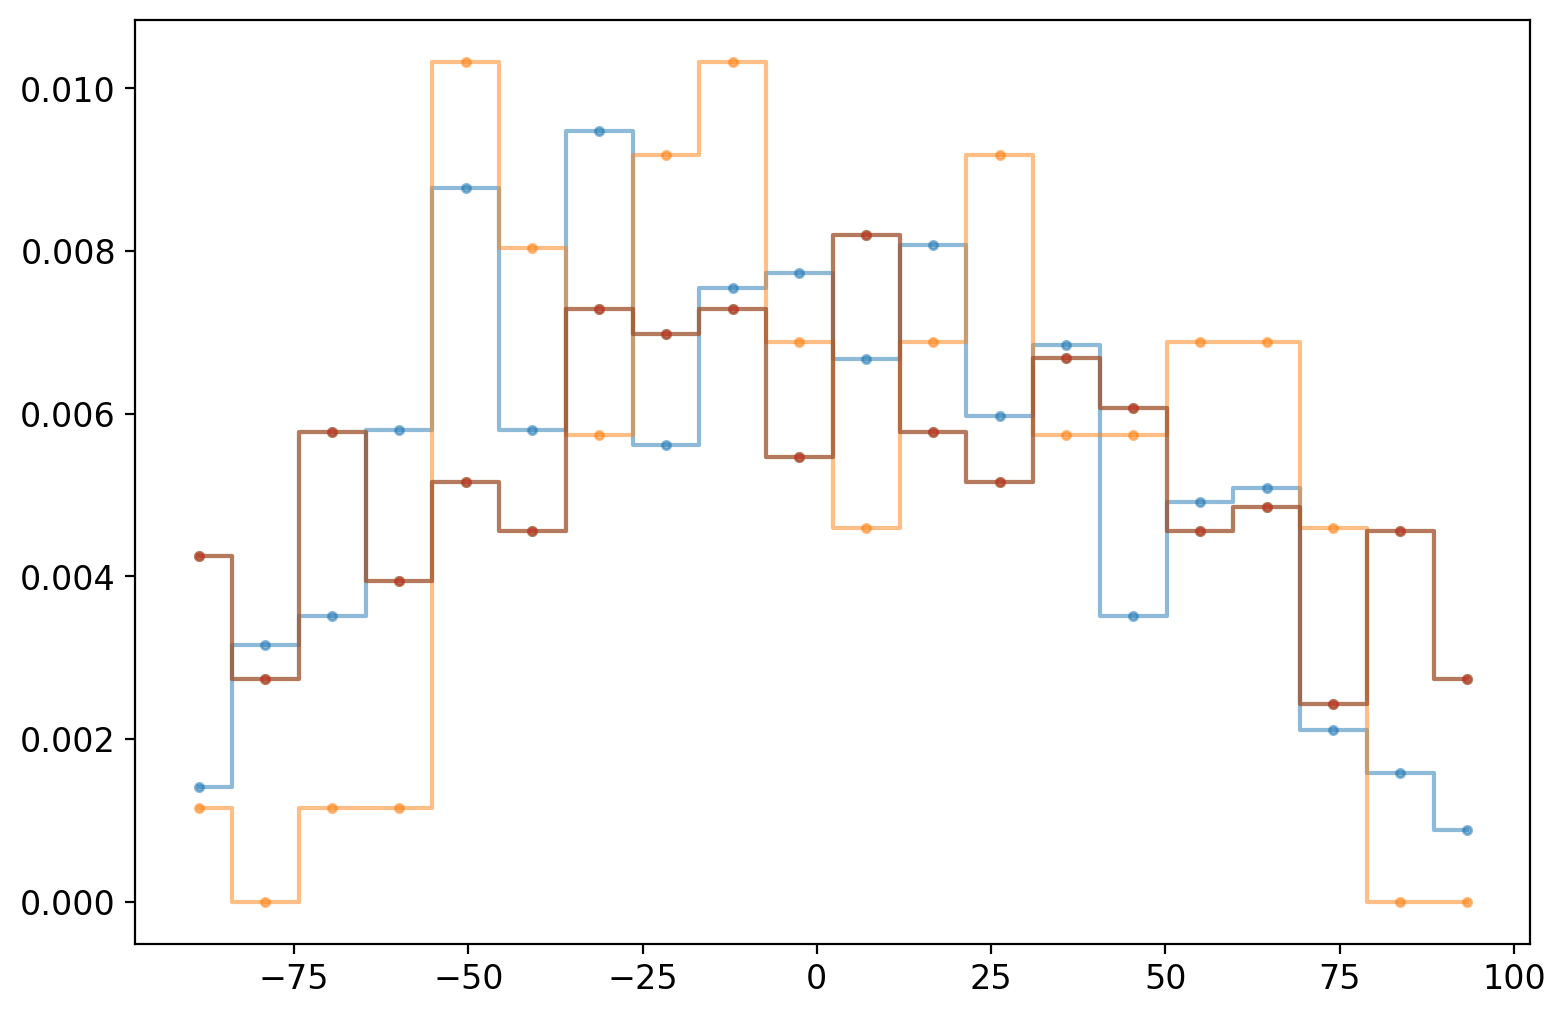

In [153]:
H = gp.Hamiltonian(milky_way)
w0_hi = gd.PhaseSpacePosition(galcen[hi_mass_mask].cartesian)
w0_lo = gd.PhaseSpacePosition(galcen[lo_mass_mask].cartesian)

orbits_hi = H.integrate_orbit(w0_hi, dt=1*u.Myr, t1=0*u.Myr, t2=500*u.Myr)
orbits_lo = H.integrate_orbit(w0_lo, dt=1*u.Myr, t1=0*u.Myr, t2=500*u.Myr)

w0_hlo,bin_edges = np.histogram(w0_lo.z.value,bins=20,density=True)
w0_hhi,bin_edges = np.histogram(w0_hi.z.value,bins=bin_edges,density=True)
bin_center = 0.5*(bin_edges[:-1] + bin_edges[1:])

print(orbits_lo[-1,0],w0_lo[0])
o0_hlo,bin_edges = np.histogram(1e3*orbits_lo[-1,:].z.value,bins=bin_edges,density=True)
o0_hhi,bin_edges = np.histogram(1e3*orbits_lo[-1,:].z.value,bins=bin_edges,density=True)

plt.plot(bin_center,w0_hlo,alpha=0.5,marker='.',drawstyle="steps-mid")
plt.plot(bin_center,w0_hhi,alpha=0.5,marker='.',drawstyle="steps-mid")

plt.plot(bin_center,o0_hlo,alpha=0.5,marker='.',drawstyle="steps-mid")
plt.plot(bin_center,o0_hhi,alpha=0.5,marker='.',drawstyle="steps-mid")

plt.show()

Now what we have one is just evolved our low and high dataset by 500 Million Years. Let's plot the orbit in the various planes to see how things look. 

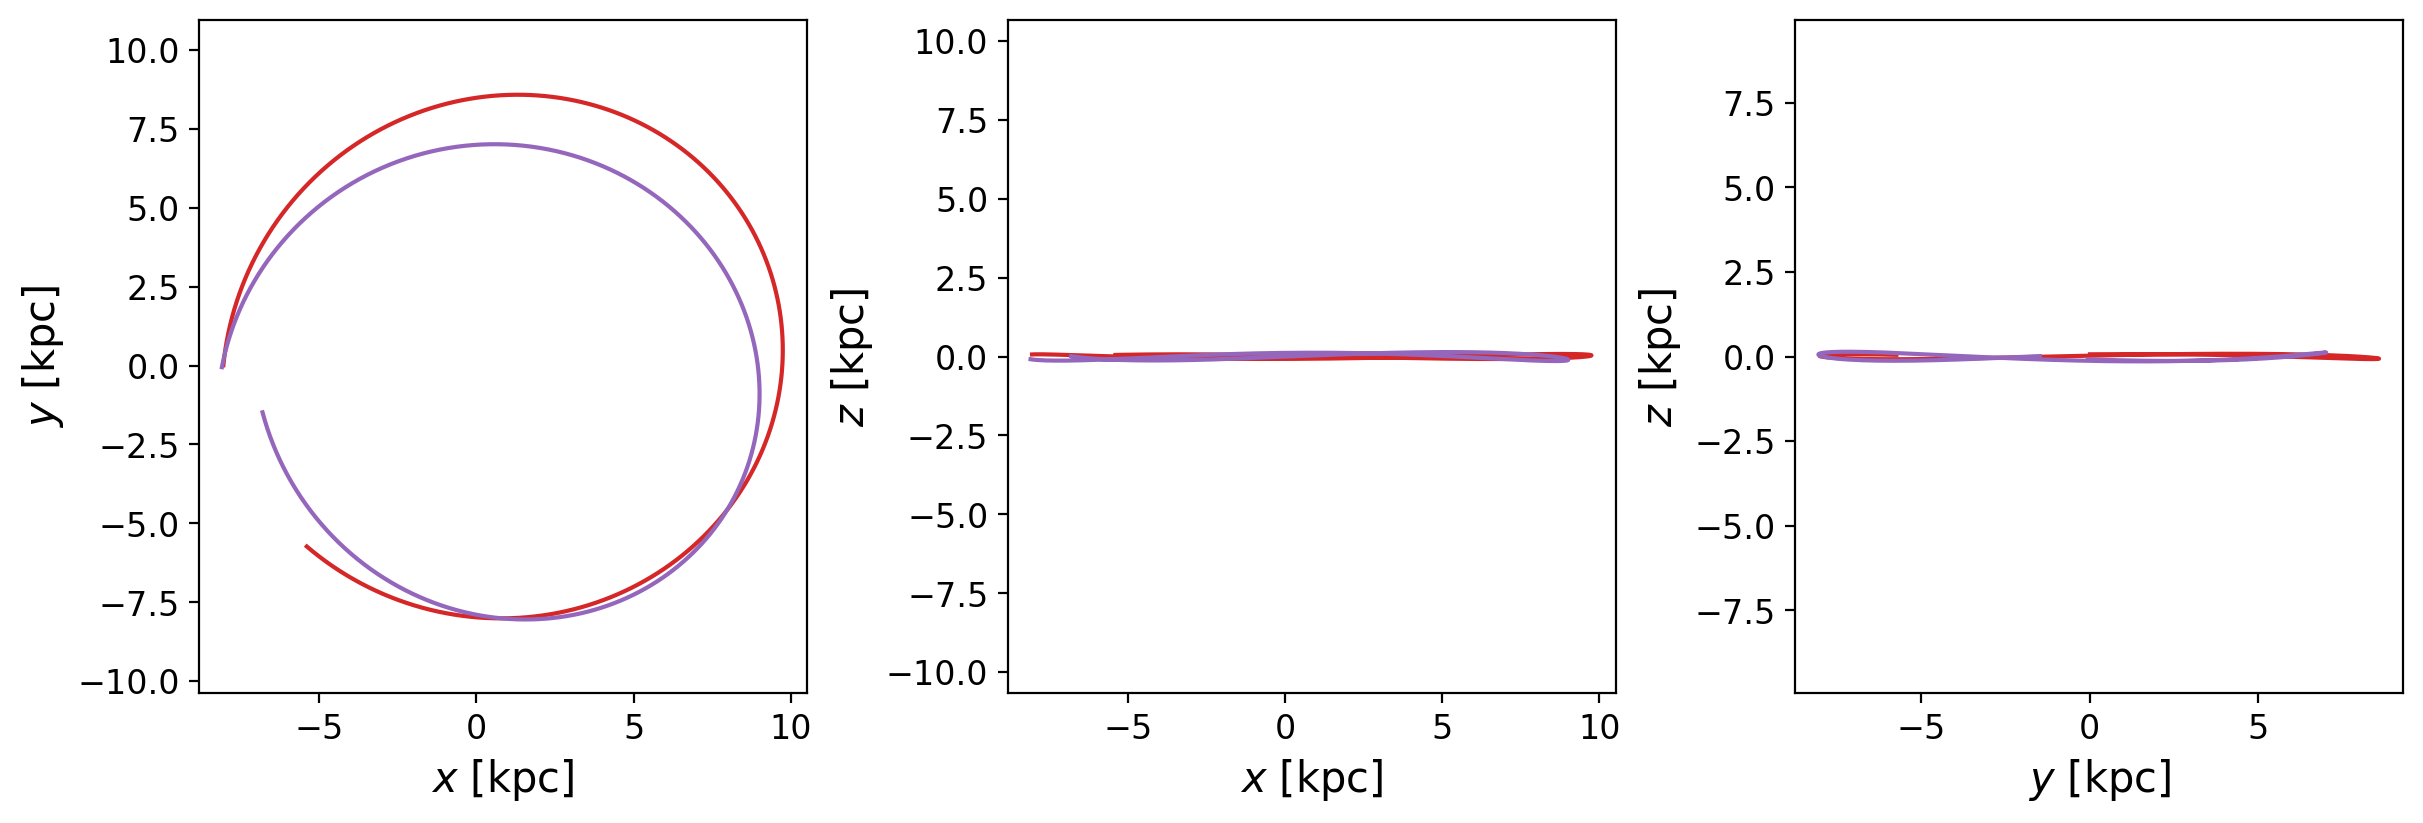

In [167]:
fig = orbits_hi[0:200, 0].plot(color=hi_mass_color)
_   = orbits_lo[0:200, 0].plot(axes=fig.axes, color=lo_mass_color)

Also for fun, lets plot final and initial positions of the evolved stars.

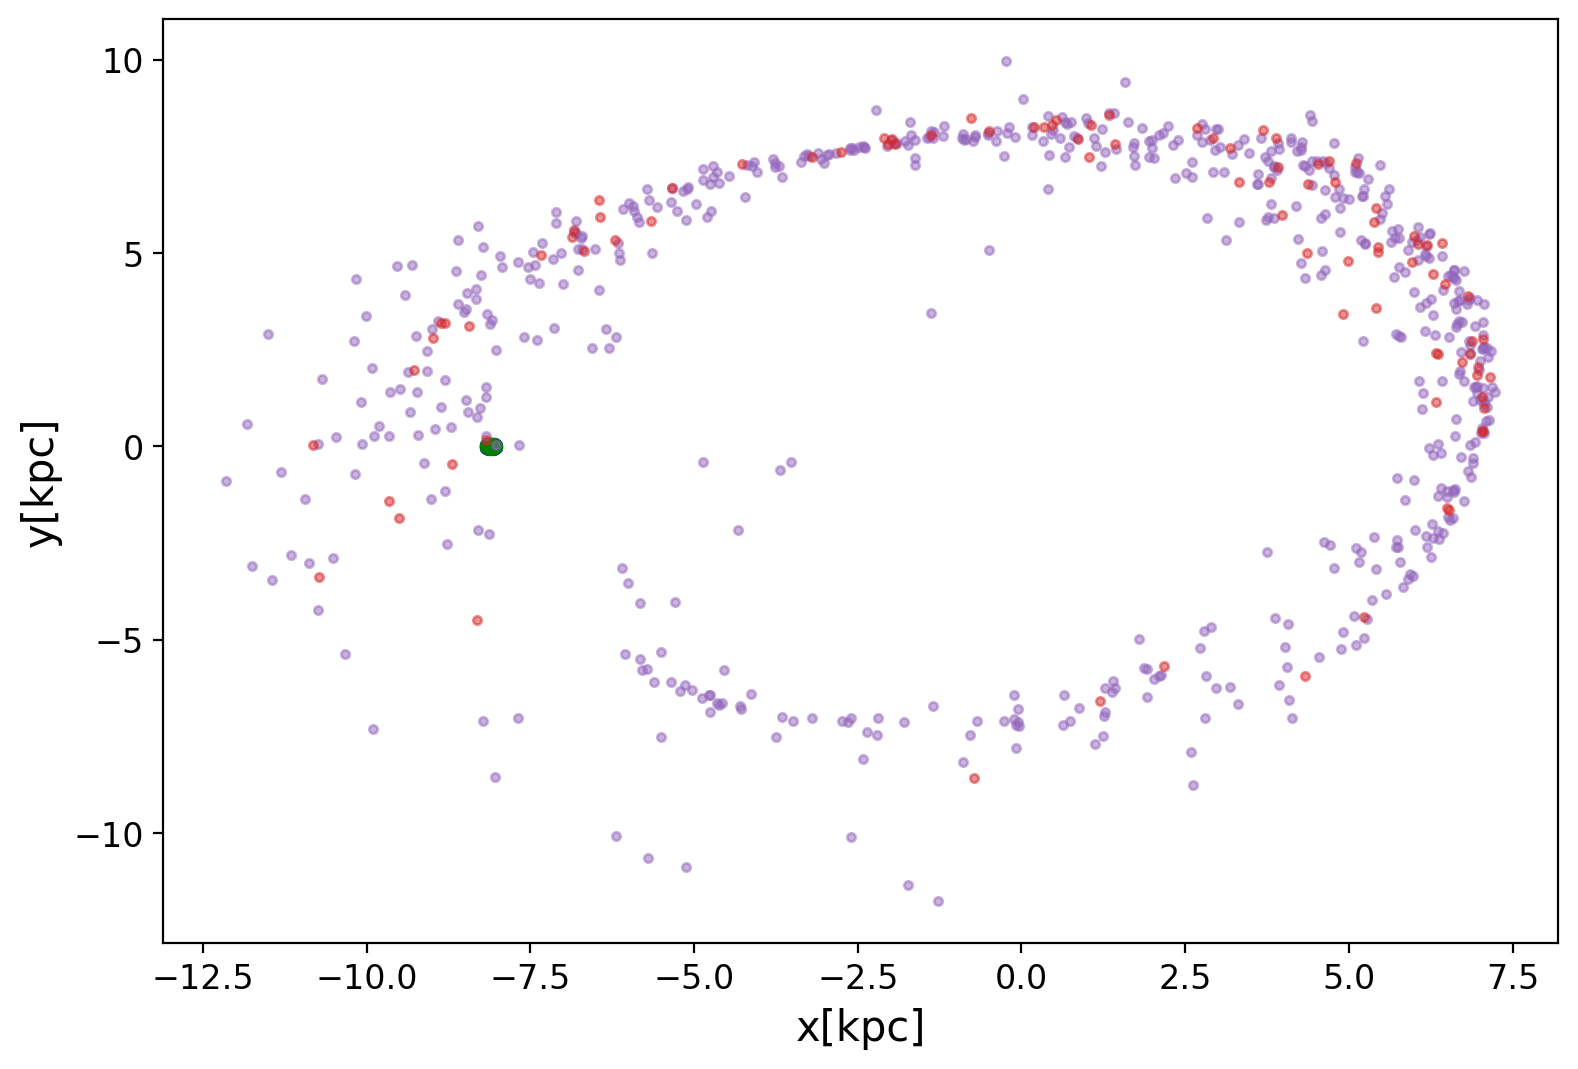

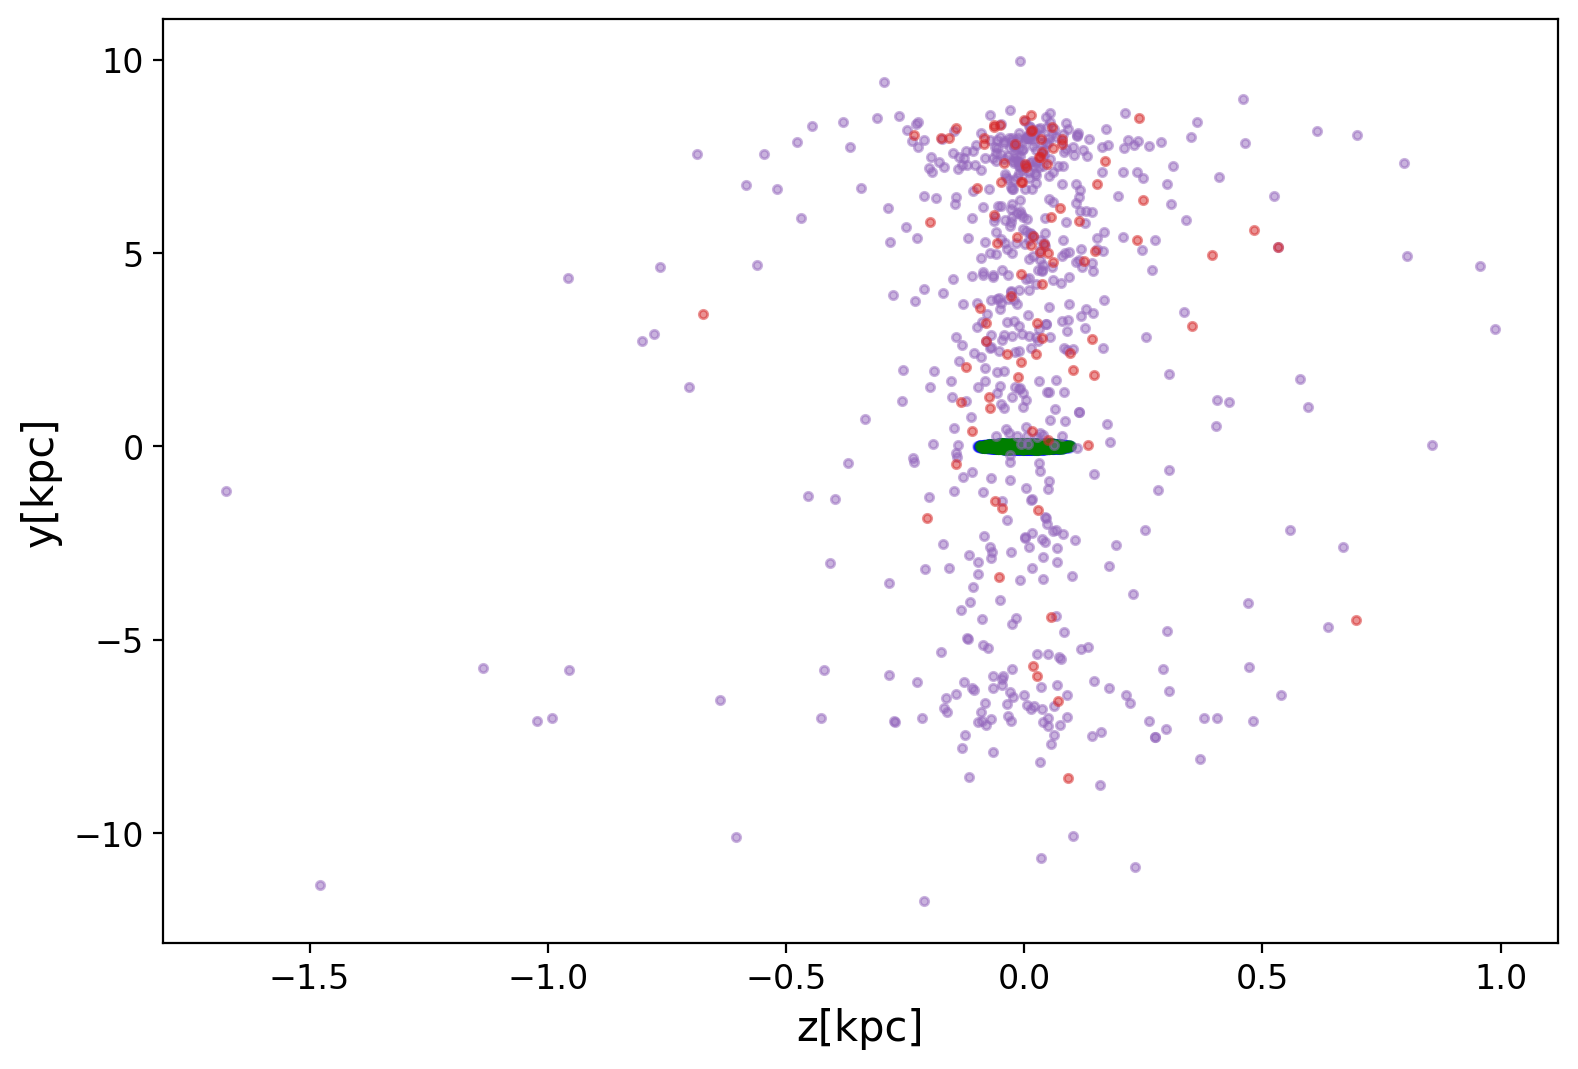

In [178]:
plt.plot(1e-3*galcen[1==1].x.value, 1e-3*galcen[1==1].y.value,marker='.', linestyle='none', alpha=0.2,color='blue')
plt.plot(1e-3*w0_lo.x.value,1e-3*w0_lo.y.value,marker='.', linestyle='none', alpha=0.5,color='green')
plt.plot(orbits_lo[-1].x.value,orbits_lo[-1].y.value,marker='.', linestyle='none', alpha=0.5,color=lo_mass_color)
plt.plot(orbits_hi[-1].x.value,orbits_hi[-1].y.value,marker='.', linestyle='none', alpha=0.5,color=hi_mass_color)
plt.xlabel('x[kpc]')
plt.ylabel('y[kpc]')
plt.show()

plt.plot(1e-3*galcen[1==1].z.value, 1e-3*galcen[1==1].y.value,marker='.', linestyle='none', alpha=0.2,color='blue')
plt.plot(1e-3*w0_lo.z.value,1e-3*w0_lo.y.value,marker='.', linestyle='none', alpha=0.5,color='green')
plt.plot(orbits_lo[-1].z.value,orbits_lo[-1].y.value,marker='.', linestyle='none', alpha=0.5,color=lo_mass_color)
plt.plot(orbits_hi[-1].z.value,orbits_hi[-1].y.value,marker='.', linestyle='none', alpha=0.5,color=hi_mass_color)
plt.xlabel('z[kpc]')
plt.ylabel('y[kpc]')
plt.show()

I think we now start to see that there are some features that are present. Look in particular at the eolved x and y. This is a reflection of the vleocities of the nearby stars based on their type. Perhaps another way to visulaize the orbits is in cylindrical coordinates. 

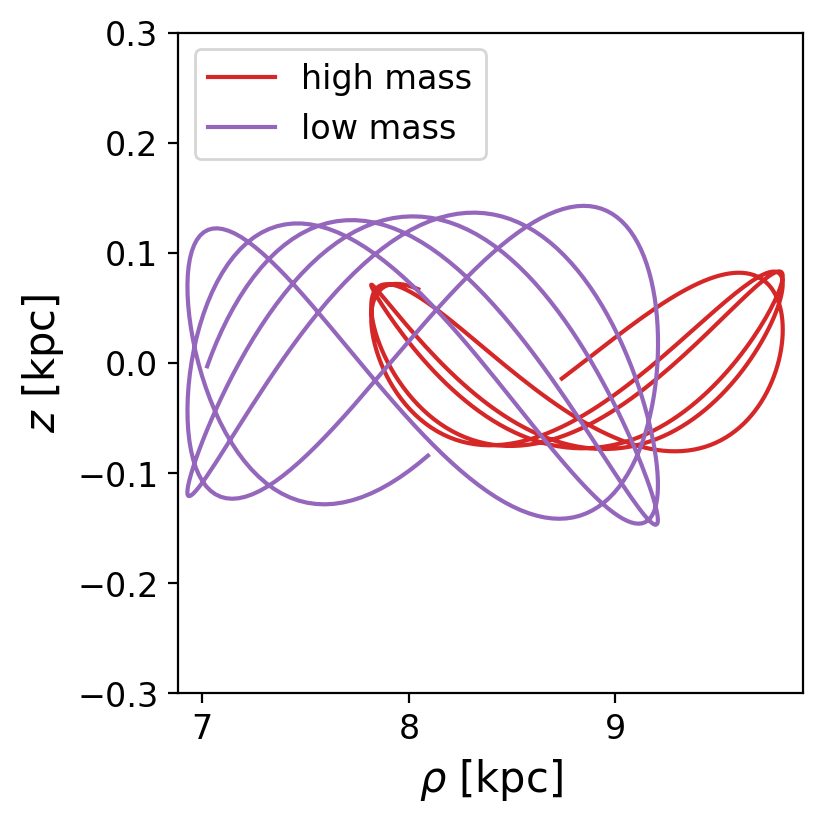

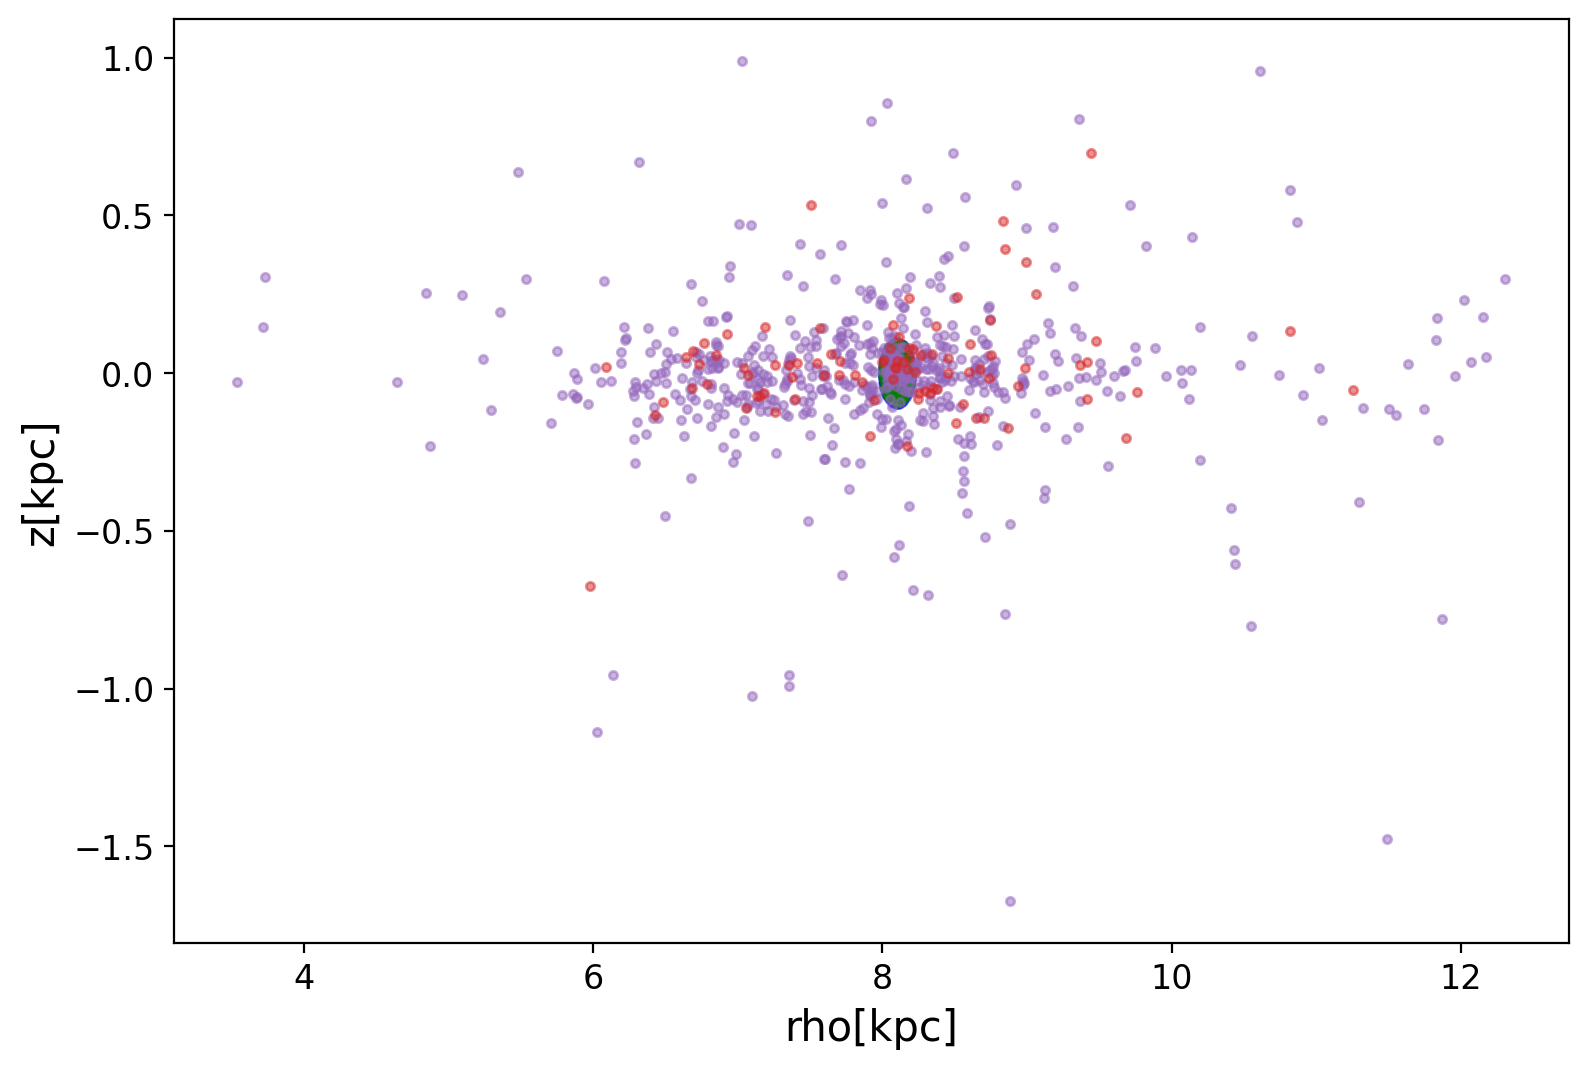

In [188]:
fig = orbits_hi[:, 0].cylindrical.plot(['rho', 'z'], 
                                       color=hi_mass_color,
                                       label='high mass')
_ = orbits_lo[:, 0].cylindrical.plot(['rho', 'z'], color=lo_mass_color,
                                     axes=fig.axes,
                                     label='low mass')

fig.axes[0].legend(loc='upper left')
fig.axes[0].set_ylim(-0.3, 0.3)
plt.show()

plt.plot(1e-3*galcen[1==1].cylindrical.rho, 1e-3*galcen[1==1].z.value,marker='.', linestyle='none', alpha=0.2,color='blue')
plt.plot(1e-3*w0_lo.cylindrical.rho,        1e-3*w0_lo.z.value,marker='.', linestyle='none', alpha=0.5,color='green')
plt.plot(orbits_lo[-1].cylindrical.rho,orbits_lo[-1].z.value,marker='.', linestyle='none', alpha=0.5,color=lo_mass_color)
plt.plot(orbits_hi[-1].cylindrical.rho,orbits_hi[-1].z.value,marker='.', linestyle='none', alpha=0.5,color=hi_mass_color)
plt.xlabel('rho[kpc]')
plt.ylabel('z[kpc]')
plt.show()

Now we can maximize the trends that we see above by trying to compute more complex observables. You can see that the purple stars tend to have large z values and spread out in rho more. We can further separate these out by looking at the projected $z_{\rm max}$ and the orbital eccentricity. 

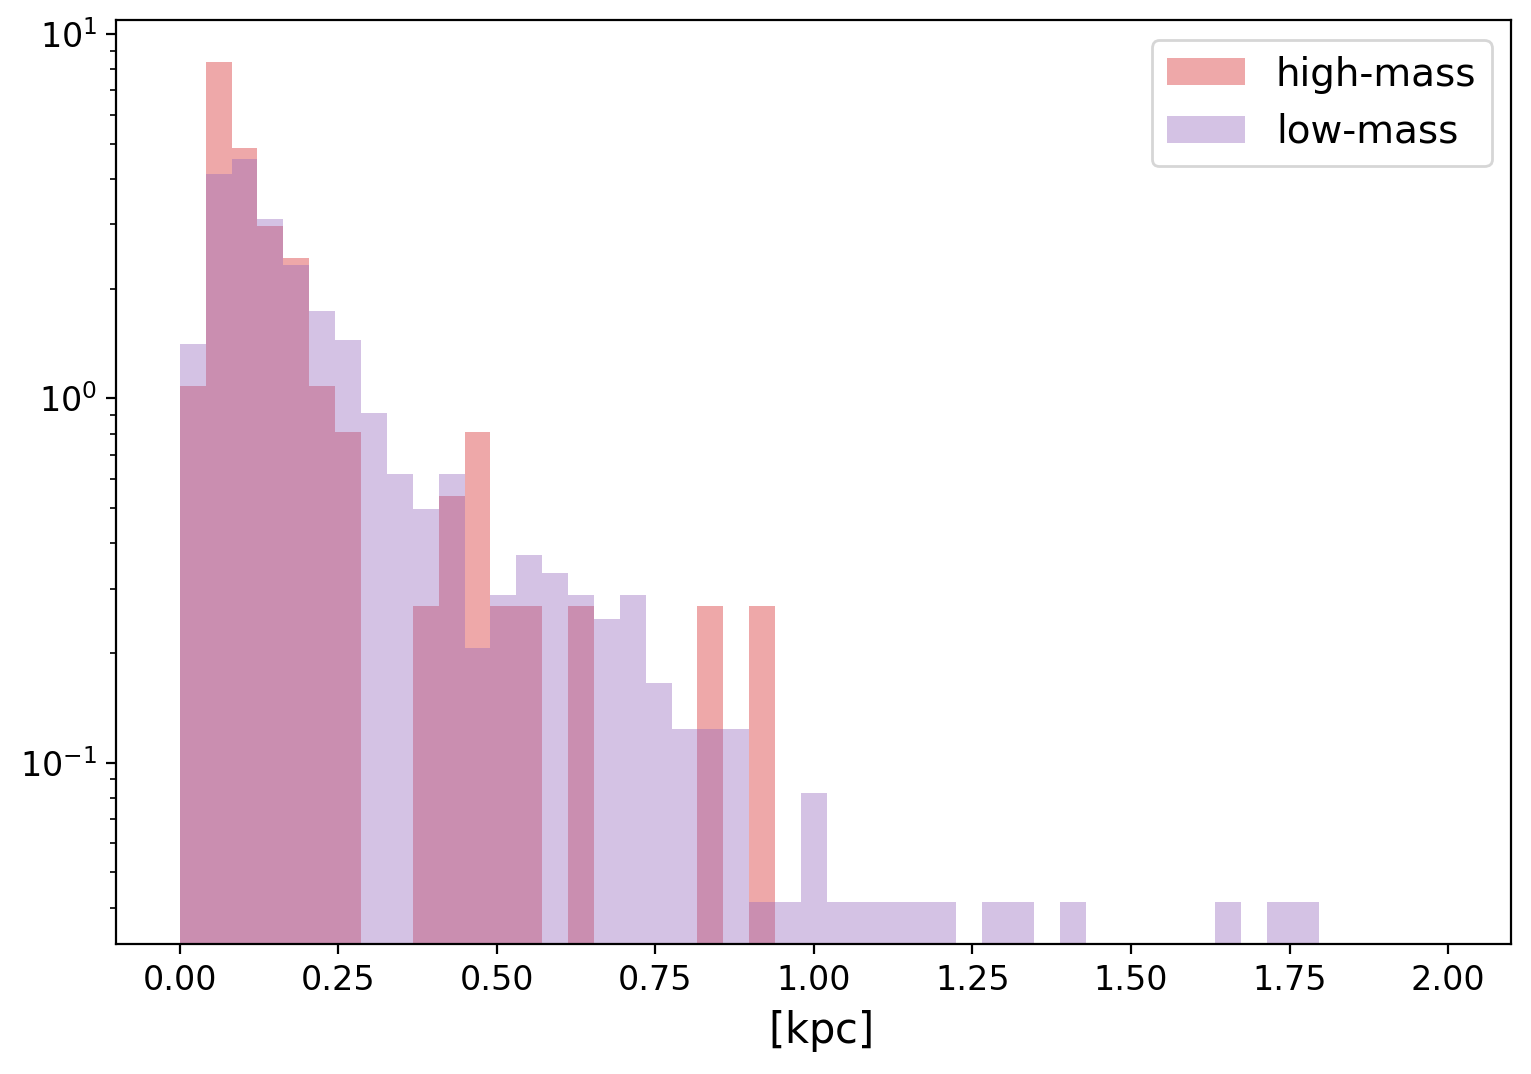

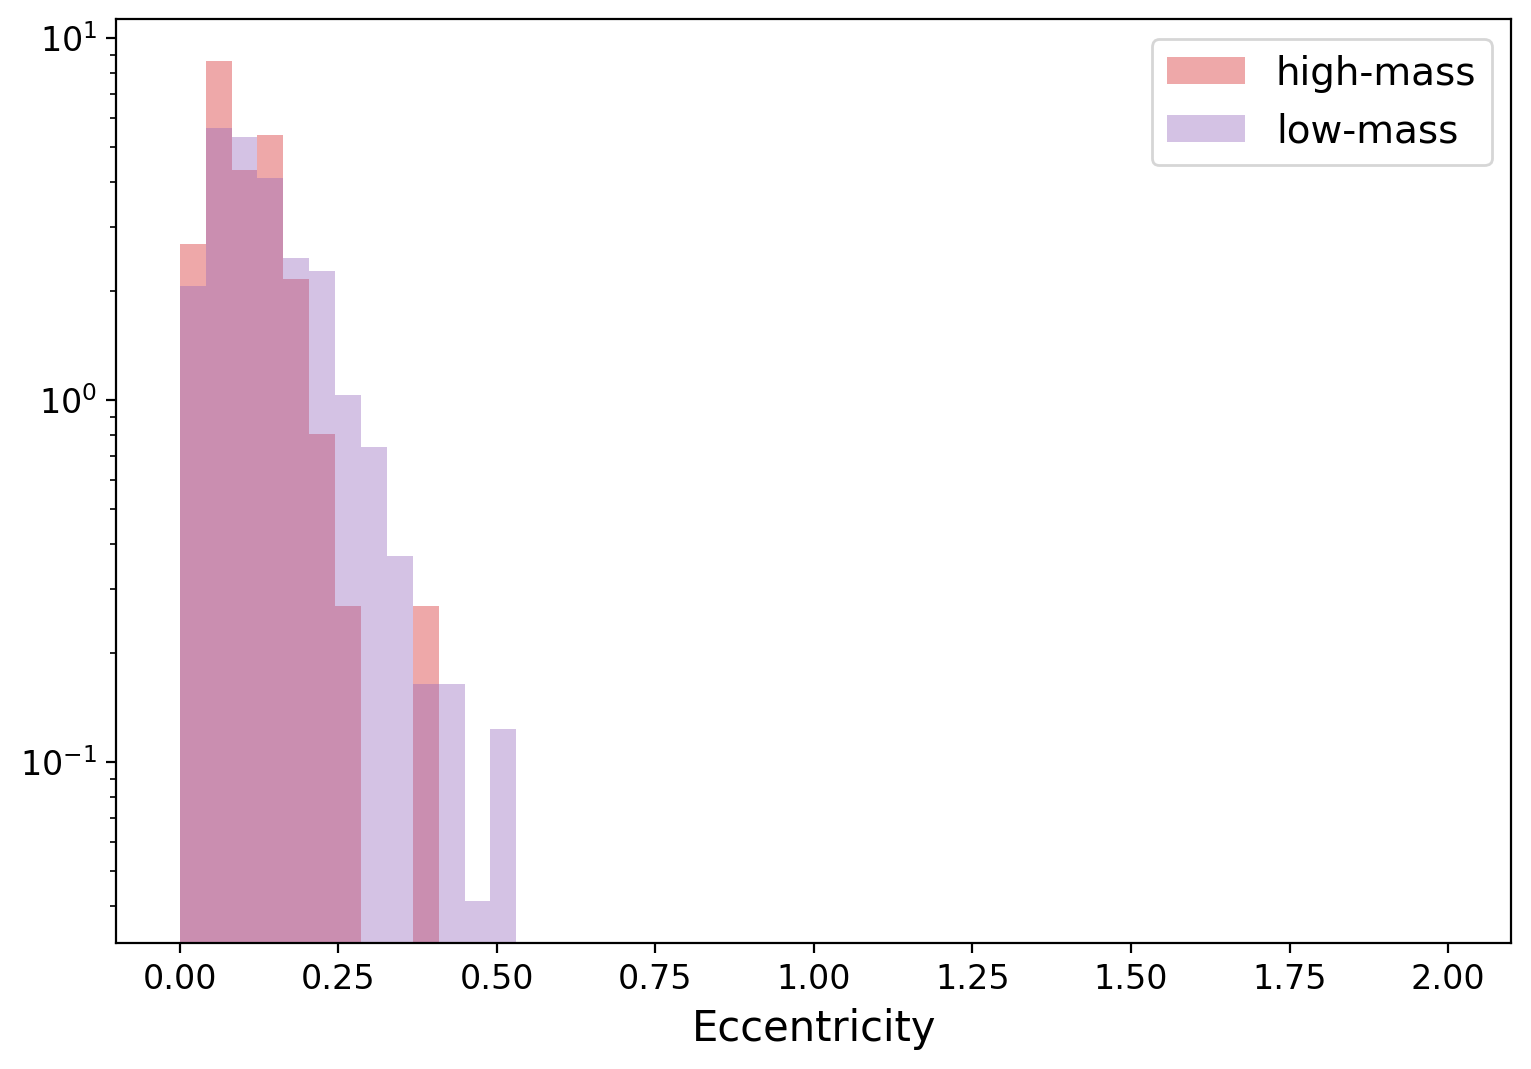

In [190]:
zmax_hi = orbits_hi.zmax(approximate=True)
zmax_lo = orbits_lo.zmax(approximate=True)
bins = np.linspace(0, 2, 50)

plt.hist(zmax_hi.value, bins=bins, alpha=0.4, density=True, label='high-mass', color=hi_mass_color)
plt.hist(zmax_lo.value, bins=bins, alpha=0.4, density=True, label='low-mass',color=lo_mass_color);
plt.legend(loc='best', fontsize=14)

plt.yscale('log')
plt.xlabel(r"" + " [{0:latex}]".format(zmax_hi.unit))
plt.show()

zmax_hi = orbits_hi.eccentricity() 
zmax_lo = orbits_lo.eccentricity() 
bins = np.linspace(0, 2, 50)
plt.hist(zmax_hi.value, bins=bins, alpha=0.4, density=True, label='high-mass', color=hi_mass_color)
plt.hist(zmax_lo.value, bins=bins, alpha=0.4, density=True, label='low-mass',color=lo_mass_color);
plt.legend(loc='best', fontsize=14)
plt.yscale('log')
plt.xlabel('Eccentricity')
plt.show()

The critical question from this all, is what have we observed? Well....in this case, we have observed two types of stars Population I and Population II. You can read more about this [here](https://en.wikipedia.org/wiki/Stellar_population). 

<a name='section_23_3'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C"> L23.3 Anomaly detection with Gaia </h2>  

Now lets try to do something more interesting with machine learning and see if we do some anomaly detection with the gaia data. For this, what we are going to do is train an autoencoder on part of the dataset. Then we will apply this another part of the dataset.  Our strategy will be to see if we can find some of the most anomalous stars in the datset. We can then use the above obserable exploration to see if the AI is telling us something meaningful. 

To do this, we will want to identify stars, which are not exactly like the others. The idea is going to be to construct an autoencoder that can look for anomalous stars amongst the dataset. To do that we will make a torch dataset and we are going to use variables that don't make our location in the galaxy too special. What we will do is : 

 * galactic coordiates $\vec{r} = r_{1}, r_{2}, r_{3}$
 * galactic velocity coordiates $\vec{v_{r}} = \dot{r}_{1}, \dot{r}_{2}, \dot{r}_{3}$
 * Distance corrected magnitudes 
 
Naturally to make teh data clean we will remove the nans and split it up nicely to testing and training

In [245]:
def prepData(igaia_data,idist,igalcen,iSplit=0.5):
    gaia_vars=['phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag']
    var0=(igaia_data[gaia_vars[0]]-idist.distmod).value
    var1=(igaia_data[gaia_vars[1]]-idist.distmod).value
    var2=(igaia_data[gaia_vars[2]]-idist.distmod).value
    var3=igalcen.x.value
    var4=igalcen.y.value
    var5=igalcen.z.value
    var6=igalcen.v_x.value
    var7=igalcen.v_y.value
    var8=igalcen.v_z.value

    #processed_data = np.vstack((var0,var1,var2,var3,var4,var5,var6,var7,var8))
    processed_data = np.vstack((var0,var1,var2,var3,var4,var5,var6,var7,var8))
    processed_data = processed_data.T
    processed_data = processed_data[~np.isnan(processed_data).any(axis=1)]
    processed_data_raw = processed_data.copy()

    #normalize the data
    processed_data /= np.std(processed_data,axis=0)
    processed_data -= np.mean(processed_data,axis=0)
    processed_data = processed_data[~np.isnan(processed_data).any(axis=1)]
    
    #tensorflow the layer
    tprocessed_data = torch.tensor(processed_data).float()
    processed_data_raw = processed_data_raw[~torch.any(tprocessed_data.isnan(),dim=1)]
    galcen_clean       = igalcen[~torch.any(tprocessed_data.isnan(),dim=1)]
    #split
    maxindex       = int(len(processed_data)*iSplit)
    trainset       = torch.tensor(processed_data[0:maxindex]).float()
    trainset       = trainset[~torch.any(trainset.isnan(),dim=1)]
    testset        = torch.tensor(processed_data[maxindex:len(processed_data)]).float()
    testset        = testset[~torch.any(testset.isnan(),dim=1)]
    print(processed_data_raw.shape,testset.shape,trainset.shape)
    return testset,trainset,processed_data_raw,tprocessed_data,galcen_clean

testset,trainset,processed_data_raw,tprocessed_data,galcen_clean=prepData(gaia_data,dist,galcen)

(4066, 9) torch.Size([2032, 9]) torch.Size([2034, 9])


Alright now with this dataset we will now make an autoencoder. This autoencer will go to dimension 20 and then shrink down to a latent space of 2. 

In [226]:
class MLP(nn.Module):
    def __init__(self,n_inputs,n_outputs):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_inputs, 20),
            nn.ReLU(),
            nn.Linear(20, 6),
            nn.ReLU(),
            nn.Linear(6, 1),
            nn.ReLU(),
            nn.Linear(1, 6),
            nn.ReLU(),
            nn.Linear(6, 20),
            nn.ReLU(),
            nn.Linear(20, n_outputs),
        )
        
    def forward(self, x):        
        x = self.layers(x)
        return x

def train(x,y,net,loss_func,opt,sched,nepochs):
    net.train(True)
    for epoch in range(nepochs):
        prediction = net(x)
        opt.zero_grad()
        loss = loss_func(prediction,y) 
        loss.backward() 
        opt.step()
        if epoch % 500 == 0: 
            print('[%d] loss: %.4f ' % (epoch + 1, loss.item()  ))
    sched.step()
    return    

model     = MLP(trainset.shape[1],trainset.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, last_epoch=-1, verbose=False)
loss_fn   =  nn.MSELoss(reduction='sum')

Alright now with our dataset, lets go aheand trian this. 

In [224]:
train(trainset,trainset,model,loss_fn,optimizer,scheduler,10001)

[1] loss: 18574.8555 
[501] loss: 10296.2568 
[1001] loss: 9971.2471 
[1501] loss: 9695.7998 
[2001] loss: 9540.9365 
[2501] loss: 9496.7227 
[3001] loss: 9446.2461 
[3501] loss: 9362.3867 
[4001] loss: 9363.0469 
[4501] loss: 9357.6660 
[5001] loss: 9317.3223 
[5501] loss: 9344.2305 
[6001] loss: 9286.9932 
[6501] loss: 9329.4551 
[7001] loss: 9256.1621 
[7501] loss: 9394.9365 
[8001] loss: 9269.1729 
[8501] loss: 9237.2051 
[9001] loss: 9314.3330 
[9501] loss: 9297.6064 
[10001] loss: 9360.4961 


Ok, now we have traineid the model. Lets look at the overall performance to understand what is going on. Let's first take a look at the loss. 

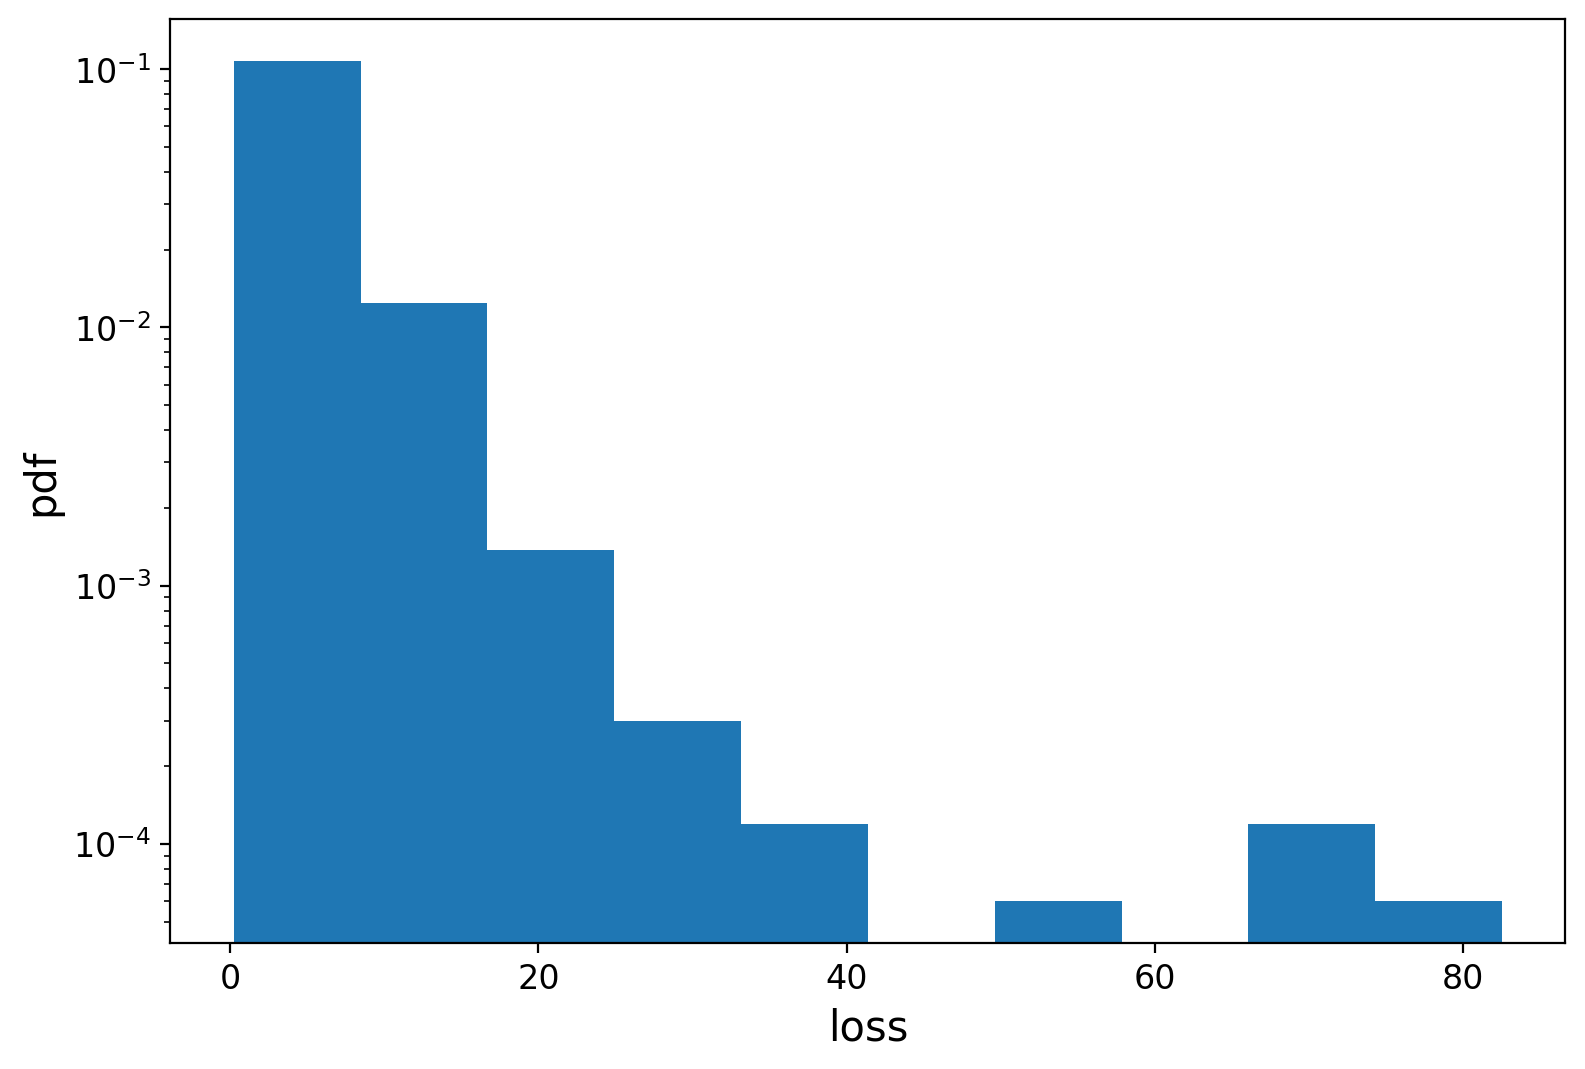

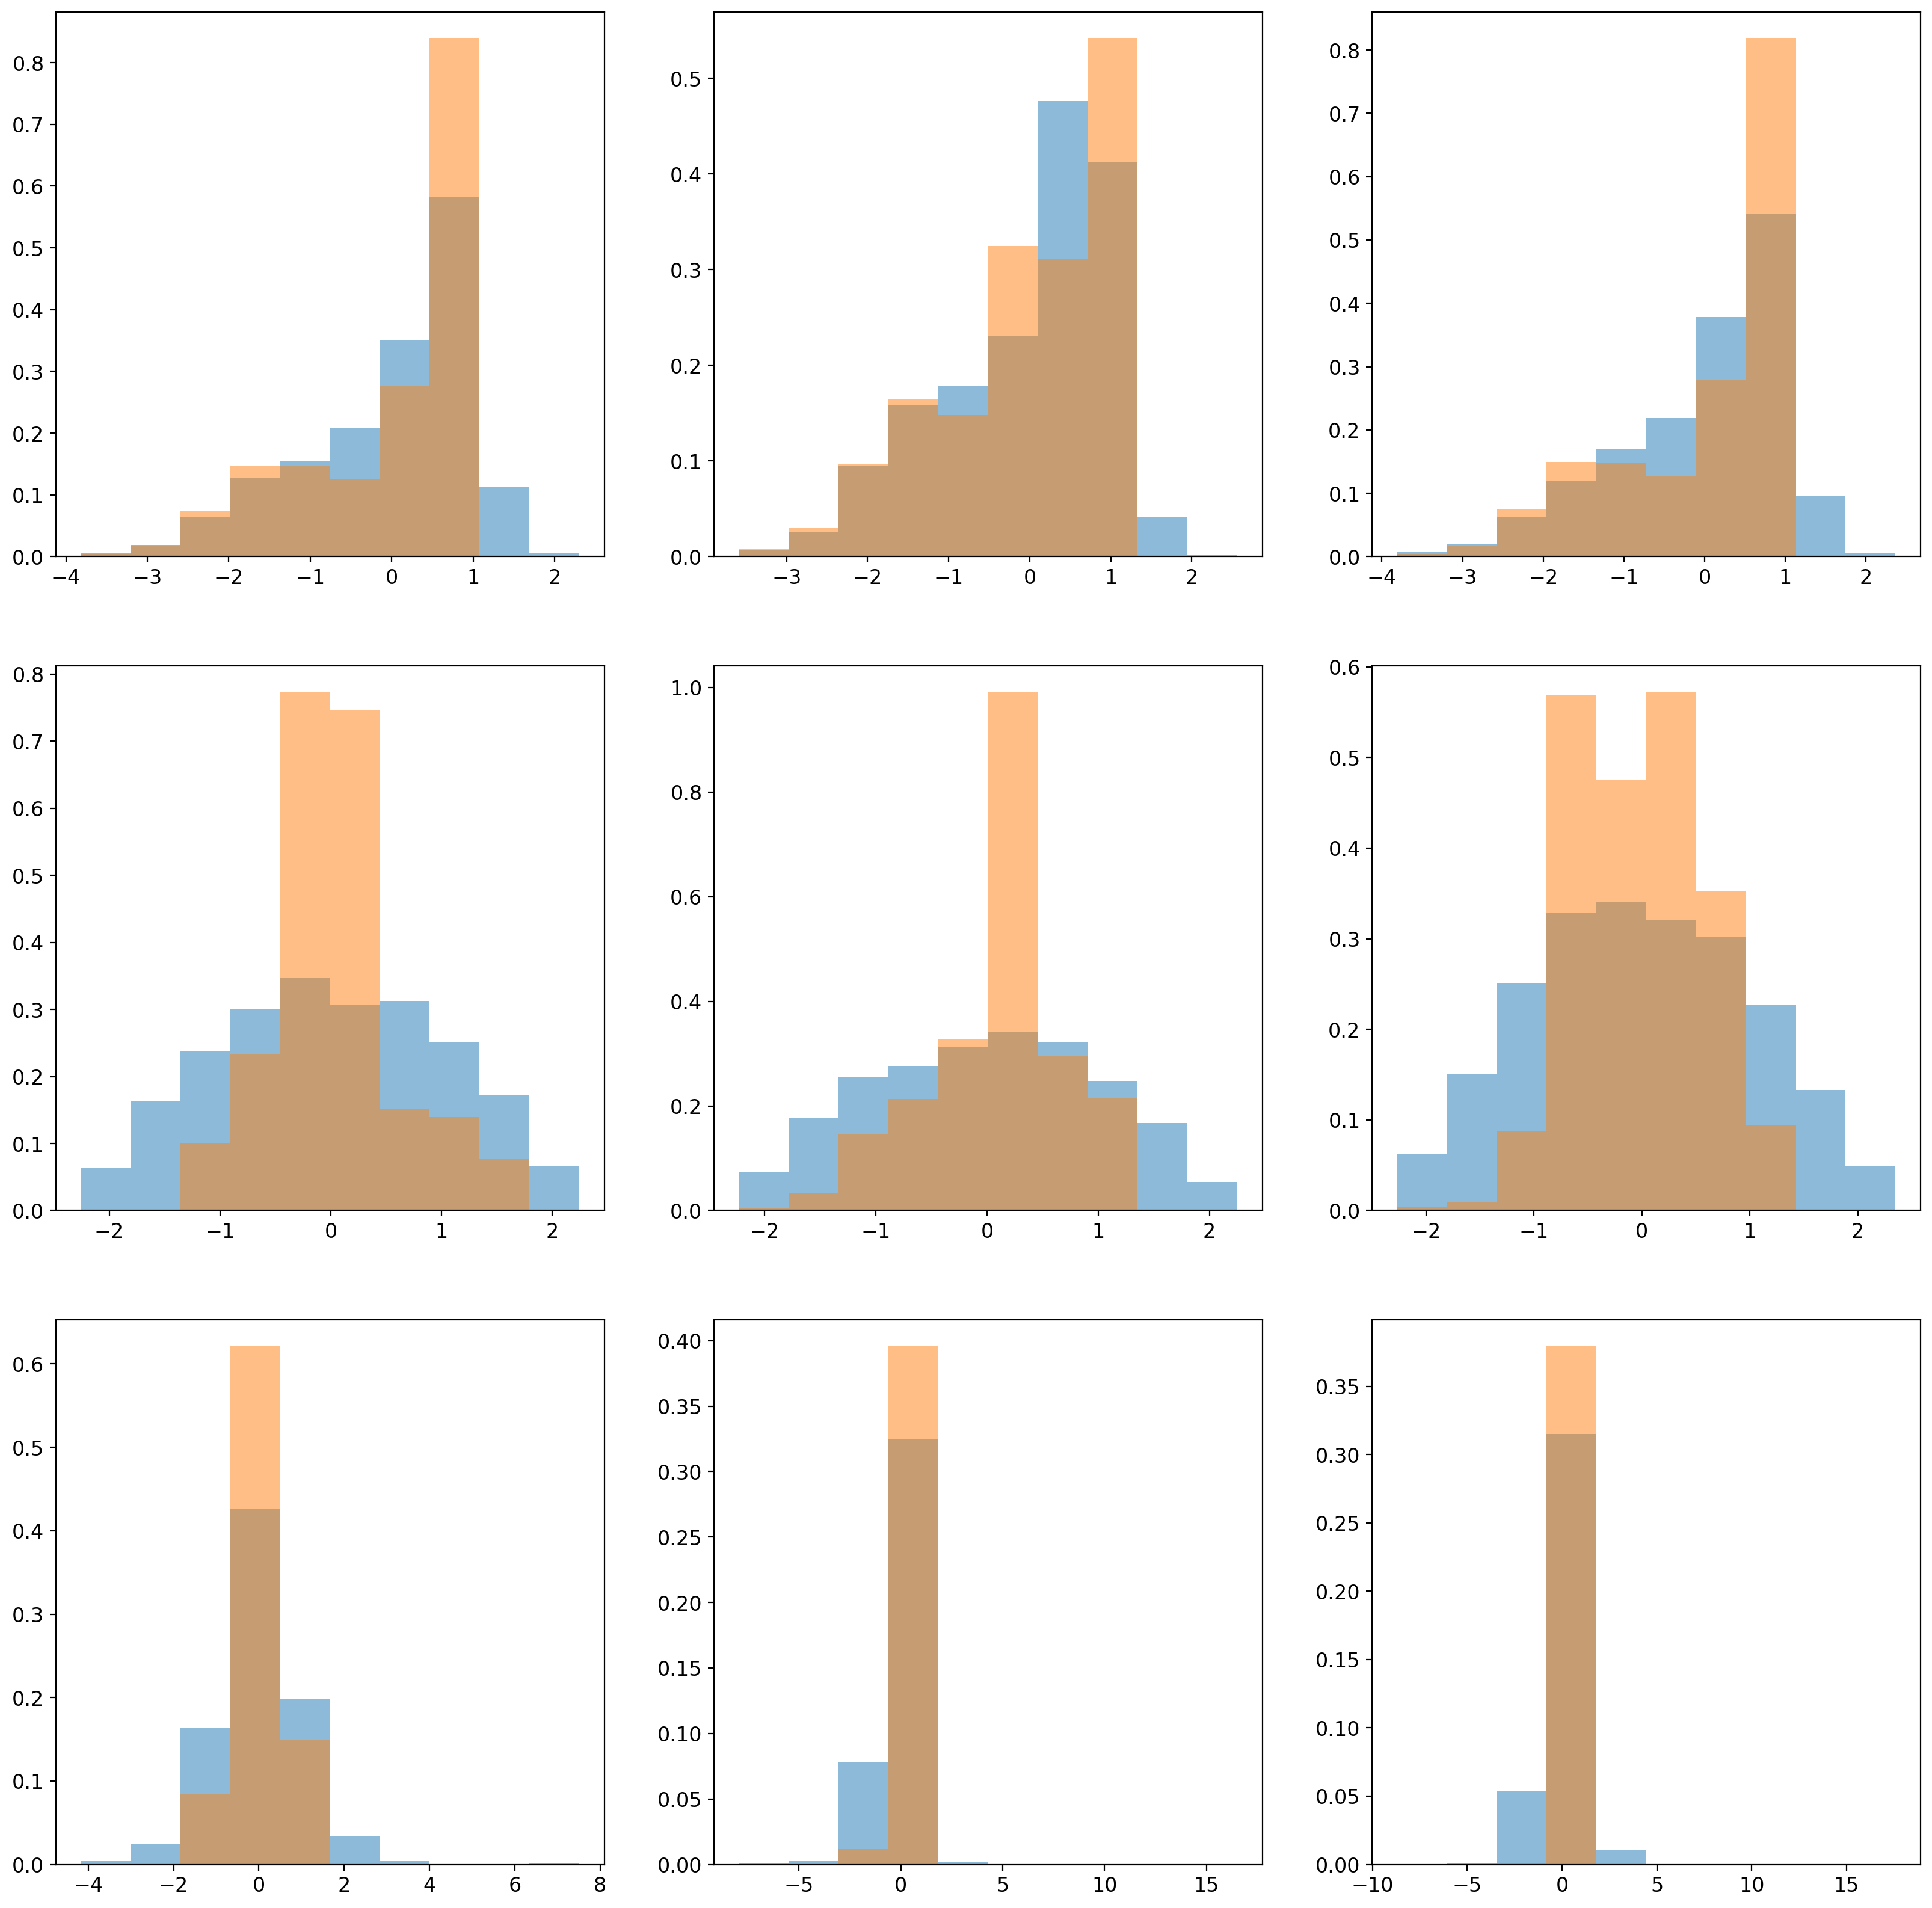

In [225]:
model.train(False)
output=model(testset)
testloss=torch.sum((testset-output)**2,axis=1)
plt.hist(testloss[testloss < 100].detach().numpy(),density=True)
plt.yscale('log')
plt.xlabel('loss')
plt.ylabel('pdf')
plt.show()

fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for var in range(testset.shape[1]):
    _,bins,_=ax[var//3,var % 3].hist(testset[:,var].detach().numpy(),density=True,alpha=0.5)
    ax[var//3,var % 3].hist(output [:,var].detach().numpy(),density=True,alpha=0.5,bins=bins)

Now what we can do is cut on the loss and look to se where are the most anomalous regions in the data. 

In [ ]:
def plotAnomaly(iCut,iRaw,iLoss,igalcen,iOrbitsAll):
    anomalies=(iLoss > iCut)
    baseidex=len(iRaw)-len(iLoss)
    testdata_raw = iRaw[baseidex:]
    anomaly_raw  = testdata_raw[anomalies]
    testgalcen   = igalcen[baseidex:]
    anomaly_galcen = testgalcen[anomalies]
    
    plt.plot(testdata_raw[:,2]-testdata_raw[:,1],testdata_raw[:,0], marker='.', linestyle='none')
    plt.plot(anomaly_raw[:,2]-anomaly_raw[:,1],anomaly_raw[:,0], marker='.', linestyle='none')
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylabel('$M_{G}$')
    plt.ylim(15,0)
    plt.xlim(1,-5)
    plt.show()

    plt.plot(testdata_raw[:,3],testdata_raw[:,4], marker='.', linestyle='none')
    plt.plot(anomaly_raw[:,3],anomaly_raw[:,4], marker='.', linestyle='none')
    plt.xlabel("x[pc]")
    plt.ylabel("y[pc]")
    plt.show()

    plt.plot(testdata_raw[:,3],testdata_raw[:,5], marker='.', linestyle='none')
    plt.plot(anomaly_raw[:,3],anomaly_raw[:,5], marker='.', linestyle='none')
    plt.xlabel("x[pc]")
    plt.ylabel("z[pc]")
    plt.show()

    plt.plot(testdata_raw[:,6],testdata_raw[:,7], marker='.', linestyle='none')
    plt.plot(anomaly_raw[:,6],anomaly_raw[:,7], marker='.', linestyle='none')
    plt.xlabel("vx[pc]")
    plt.ylabel("vy[pc]")
    plt.show()

    plt.plot(testdata_raw[:,6],testdata_raw[:,8], marker='.', linestyle='none')
    plt.plot(anomaly_raw[:,6],anomaly_raw[:,8], marker='.', linestyle='none')
    plt.xlabel("vx[pc]")
    plt.ylabel("vz[pc]")
    plt.show()
    
    print(len(testdata_raw),len(iRaw),len(igalcen),len(testgalcen))
    H = gp.Hamiltonian(milky_way)
    w0_anom = gd.PhaseSpacePosition(anomaly_galcen.cartesian)
    orbits_anom = H.integrate_orbit(w0_anom, dt=1*u.Myr, t1=0*u.Myr, t2=100*u.Myr)

    zmax_all = orbits_all.zmax(approximate=True)
    zmax_anom = orbits_anom.zmax(approximate=True)
    print(zmax_anom,"!! Anom 1")
    bins = np.linspace(0, 10, 50)
    plt.hist(zmax_all.value, bins=bins, alpha=0.4, density=True, label='all')
    plt.hist(zmax_anom.value, bins=bins, alpha=0.4, density=True, label='anom')
    plt.legend(loc='best', fontsize=14)
    plt.yscale('log')
    plt.xlabel(r"" + " [{0:latex}]".format(zmax_all.unit))
    plt.show()

    zmax_all  = orbits_all.eccentricity() 
    zmax_anom = orbits_anom.eccentricity() 
    bins = np.linspace(0, 10, 50)
    plt.hist(zmax_all.value,  bins=bins, alpha=0.4, density=True, label='all')
    plt.hist(zmax_anom.value, bins=bins, alpha=0.4, density=True, label='anom')
    plt.legend(loc='best', fontsize=14)
    plt.yscale('log')
    plt.xlabel('Eccentricity')
    plt.show()
    
#H = gp.Hamiltonian(milky_way)
#w0_all  = gd.PhaseSpacePosition(galcen_clean[1==1].cartesian)
#orbits_all  = H.integrate_orbit(w0_all,  dt=1*u.Myr, t1=0*u.Myr, t2=100*u.Myr)
plotAnomaly(40,processed_data_raw,testloss,galcen_clean,orbits_all)

I think its clear we are really finding some of the weirdest stars, these ones are really far from teh galactic plane. 

<a name='section_22_4'></a>
<hr style="height: 1px;">

## <h2 style="border:1px; border-style:solid; padding: 0.25em; color: #FFFFFF; background-color: #90409C"> L22.4 Anomaly detection with Lots of Gaia data </h2>  

Now the above, was just a random sampling of 2k stars. What if we try to do this on a much larger scale. Let's look at a much larger sample. 

In [255]:
query_text = '''SELECT TOP 1000000 ra, dec, parallax, pmra, pmdec, radial_velocity,
phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag
FROM gaiadr3.gaia_source
WHERE parallax_over_error > 10 AND
    parallax > 10 AND
    radial_velocity IS NOT null
ORDER BY random_index
'''

job = Gaia.launch_job(query_text)
gaia_data = job.get_results()
gaia_data.write('gaia_data.fits',overwrite=True)
gaia_data = QTable.read('gaia_data.fits')
print("Total Events:",len(gaia_data))


Total Events: 169740


Lets take a aquick look at our data.

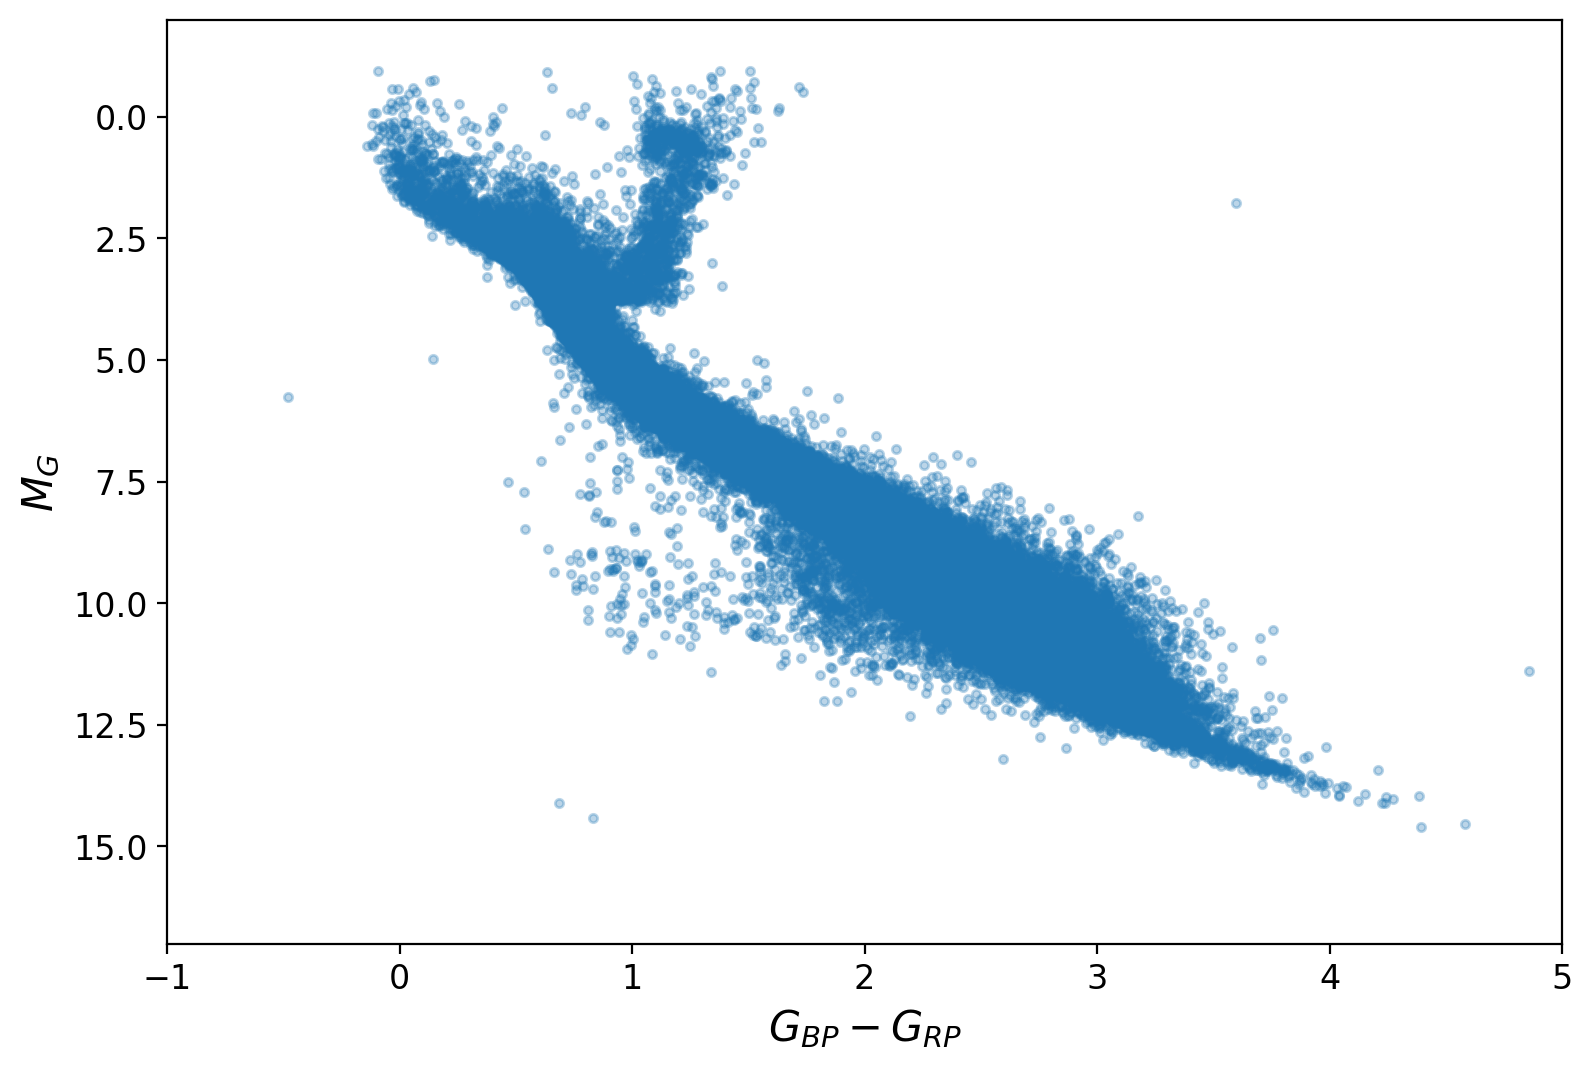

In [266]:
dist = coord.Distance(parallax=u.Quantity(gaia_data['parallax']))
M_G = gaia_data['phot_g_mean_mag'] - dist.distmod
BP_RP = gaia_data['phot_bp_mean_mag'] - gaia_data['phot_rp_mean_mag']

plt.plot(BP_RP.value, M_G.value, marker='.', linestyle='none', alpha=0.3)

plt.xlim(-1, 5)
plt.ylim(17, -2)

plt.xlabel('$G_{BP}-G_{RP}$')
plt.ylabel('$M_{G}$')
plt.show()

Now we can see some more interesting features of the HR diagam. In paritcular, you can see the kinky stuff at the top that correspond to gians. Also, you can see some points down at the bottom that correspond to the white dwarfs. Let's go ahead and split this dataset into 2 and train an autoencoder for this. 

In [267]:
c = coord.SkyCoord(ra=gaia_data['ra'], dec=gaia_data['dec'],distance=dist,pm_ra_cosdec=gaia_data['pmra'], pm_dec=gaia_data['pmdec'],
                   radial_velocity=gaia_data['radial_velocity'])
galcen = c.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8.1*u.kpc))

testset,trainset,processed_data_raw,tprocessed_data,galcen_clean=prepData(gaia_data,dist,galcen)

(168208, 9) torch.Size([84116, 9]) torch.Size([84092, 9])


In [270]:
class MLP(nn.Module):
    def __init__(self,n_inputs,n_outputs):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 4),
            nn.ReLU(),
            nn.Linear(4, 20),
            nn.ReLU(),
            nn.Linear(20, 100),
            nn.ReLU(),
            nn.Linear(100, n_outputs),
        )
        
    def forward(self, x):        
        x = self.layers(x)
        return x

model     = MLP(trainset.shape[1],trainset.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, last_epoch=-1, verbose=False)
loss_fn   =  nn.MSELoss(reduction='sum')

Now lets run a big training of everything

In [271]:
train(trainset,trainset,model,loss_fn,optimizer,scheduler,10001)

[1] loss: 766713.0625 
[501] loss: 117360.6719 
[1001] loss: 99277.8516 
[1501] loss: 92256.2344 
[2001] loss: 86745.7422 
[2501] loss: 87400.5469 
[3001] loss: 83826.8906 
[3501] loss: 71079.3359 
[4001] loss: 69530.0000 
[4501] loss: 71030.1328 
[5001] loss: 64262.0430 
[5501] loss: 63500.3125 
[6001] loss: 60443.5859 
[6501] loss: 62813.7500 
[7001] loss: 57185.7305 
[7501] loss: 58573.2031 
[8001] loss: 57462.3828 
[8501] loss: 54554.7656 
[9001] loss: 56318.6406 
[9501] loss: 54726.1953 
[10001] loss: 52757.8867 


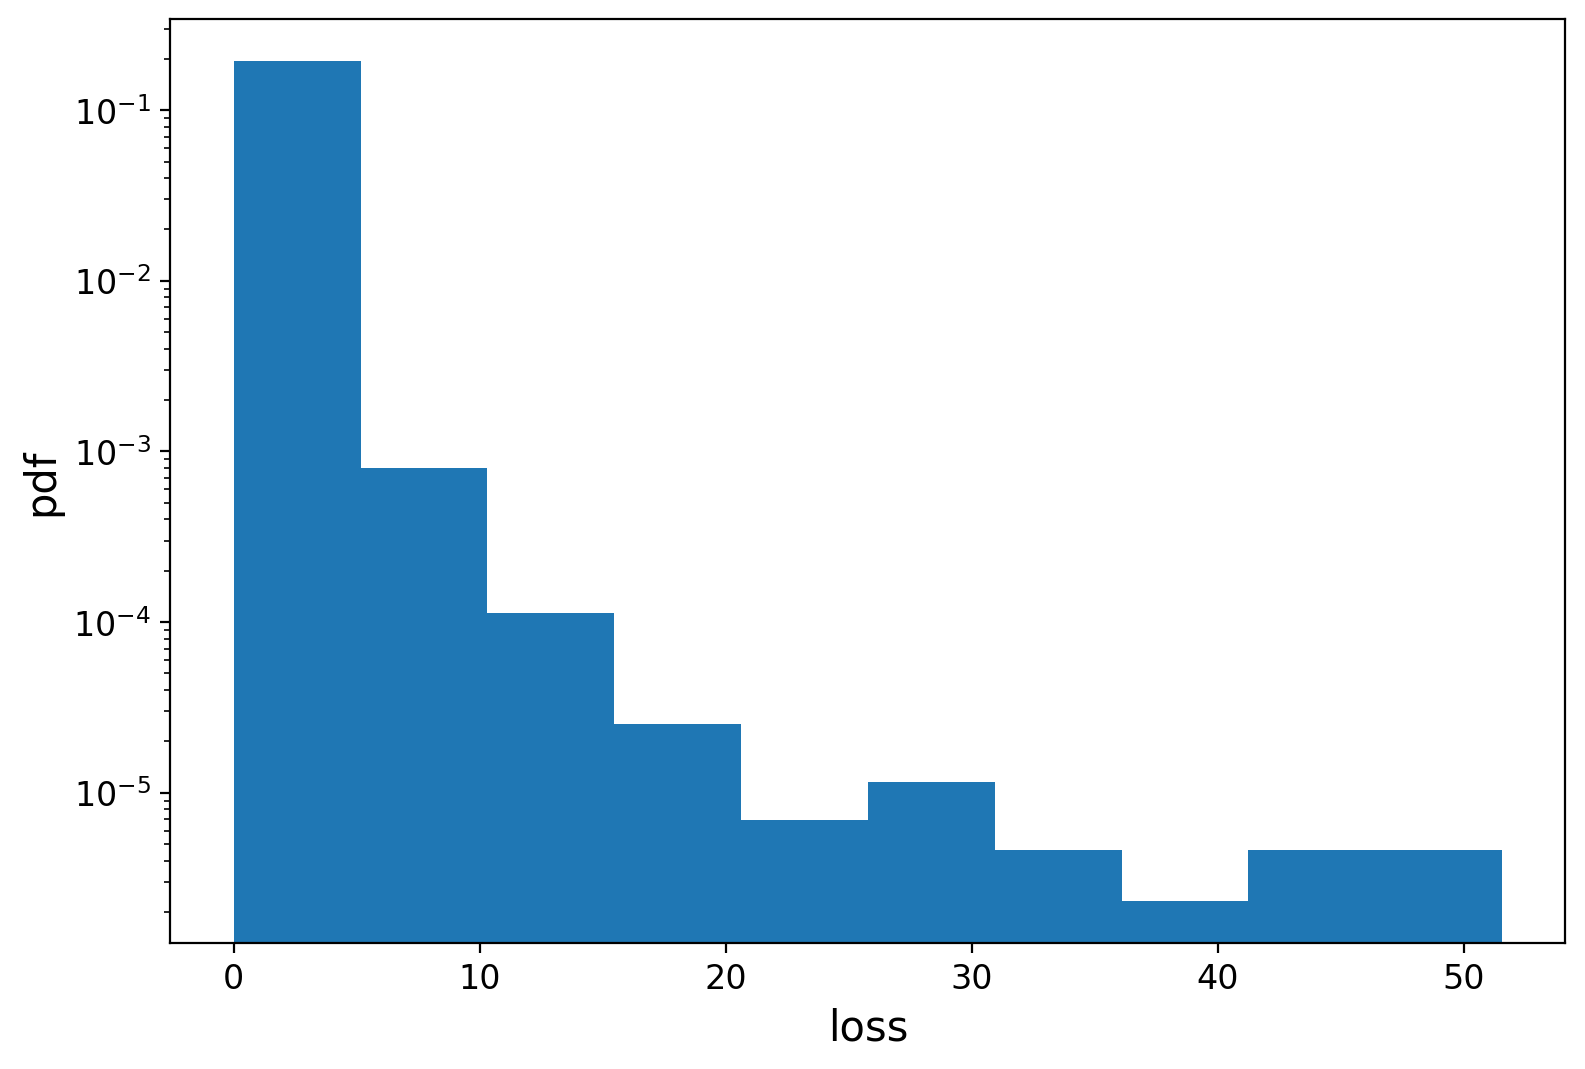

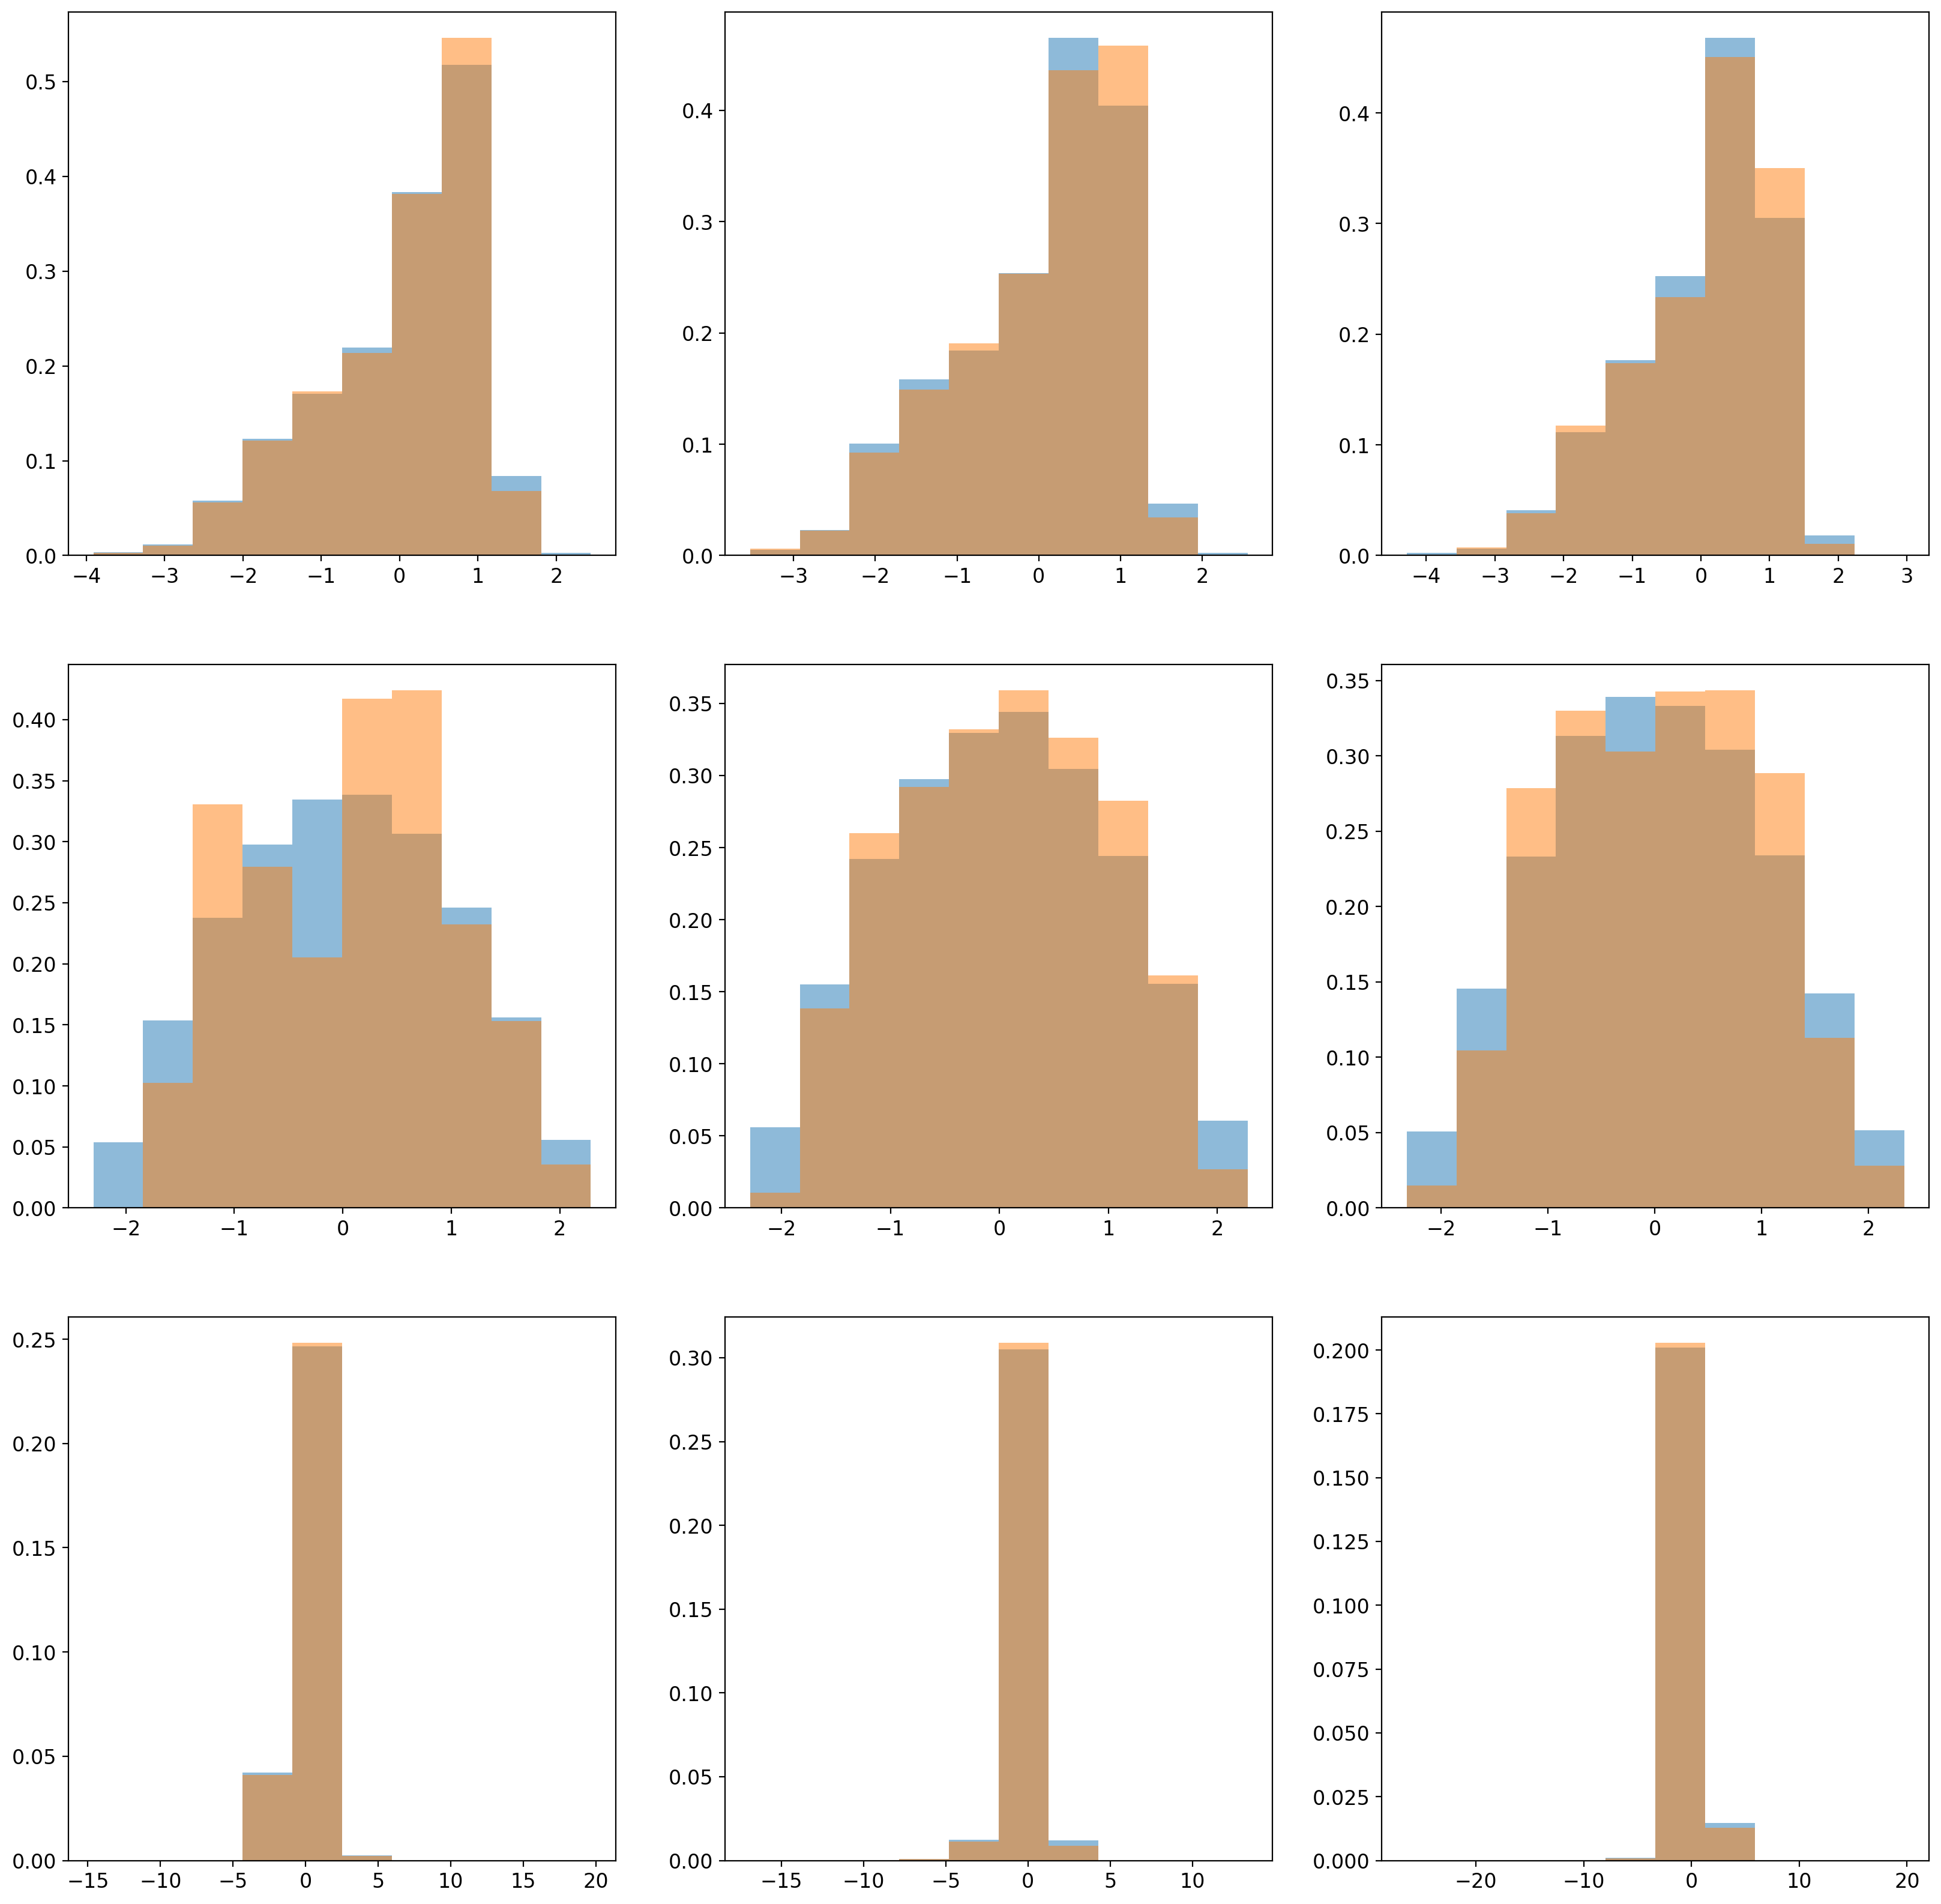

In [327]:
model.train(False)
output=model(testset)
testloss=torch.sum((testset-output)**2,axis=1)
plt.hist(testloss[testloss < 100].detach().numpy(),density=True)
plt.yscale('log')
plt.xlabel('loss')
plt.ylabel('pdf')
plt.show()

fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for var in range(testset.shape[1]):
    _,bins,_=ax[var//3,var % 3].hist(testset[:,var].detach().numpy(),density=True,alpha=0.5)
    ax[var//3,var % 3].hist(output [:,var].detach().numpy(),density=True,alpha=0.5,bins=bins)

Alright, lets plot our anomalies in this scenario. 

In [278]:
H = gp.Hamiltonian(milky_way)
w0_all  = gd.PhaseSpacePosition(galcen_clean[1==1].cartesian)
orbits_all  = H.integrate_orbit(w0_all,  dt=1*u.Myr, t1=0*u.Myr, t2=100*u.Myr)
#plotAnomaly(45,processed_data_raw,testloss,galcen_clean,orbits_all)

[       nan        nan 2.76566518        nan        nan] kpc


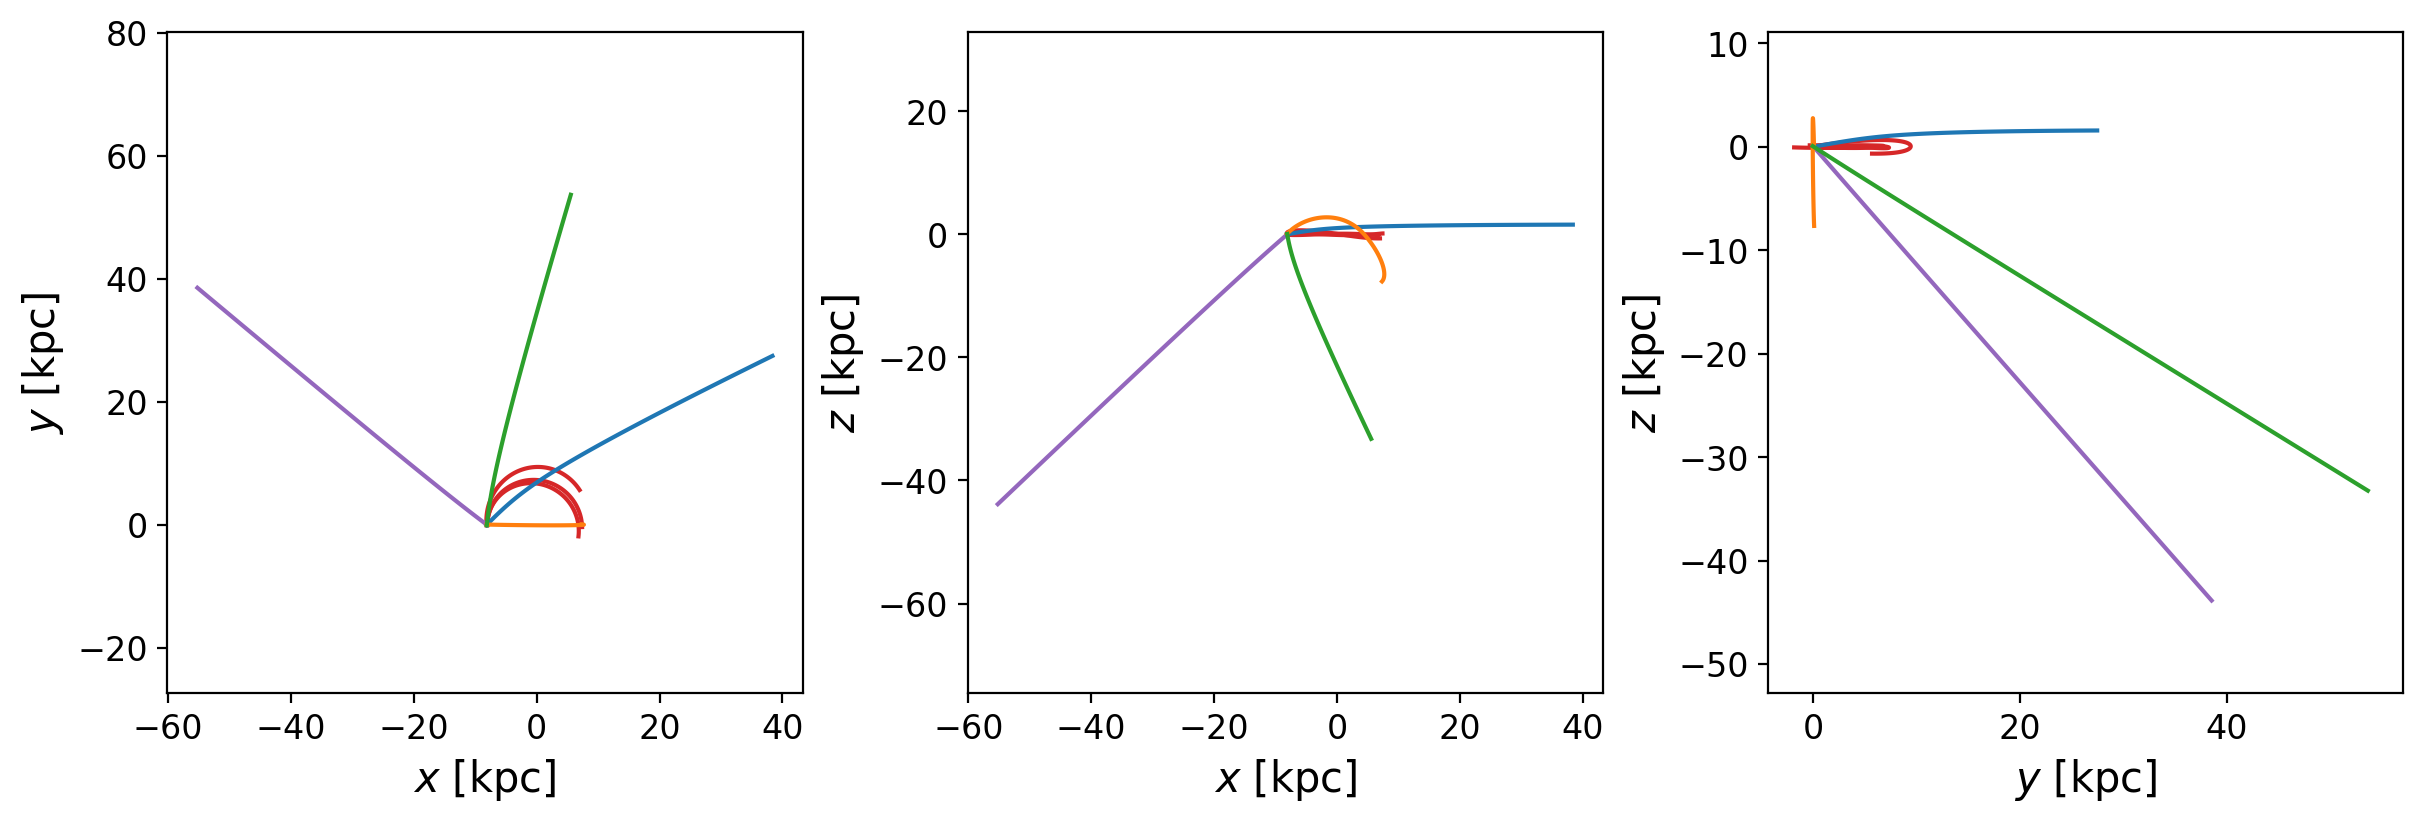

In [291]:
anomalies=(testloss > 45.)
baseidex=len(processed_data_raw)-len(testloss)
testgalcen   = galcen_clean[baseidex:]
anomaly_galcen = testgalcen[anomalies]

w0_anom = gd.PhaseSpacePosition(anomaly_galcen.cartesian)
orbits_anom = H.integrate_orbit(w0_anom, dt=1*u.Myr, t1=0*u.Myr, t2=100*u.Myr)


fig = orbits_all[0:200, 0].plot(color=hi_mass_color)
_   = orbits_all[0:200, 1].plot(axes=fig.axes,color=hi_mass_color)
_   = orbits_all[0:200, 2].plot(axes=fig.axes,color=hi_mass_color)
_   = orbits_anom[0:200, 0].plot(axes=fig.axes, color=lo_mass_color)
_   = orbits_anom[0:200, 1].plot(axes=fig.axes)
_   = orbits_anom[0:200, 2].plot(axes=fig.axes)
_   = orbits_anom[0:200, 3].plot(axes=fig.axes)


zmax=orbits_anom.zmax(approximate=True)
print(zmax)

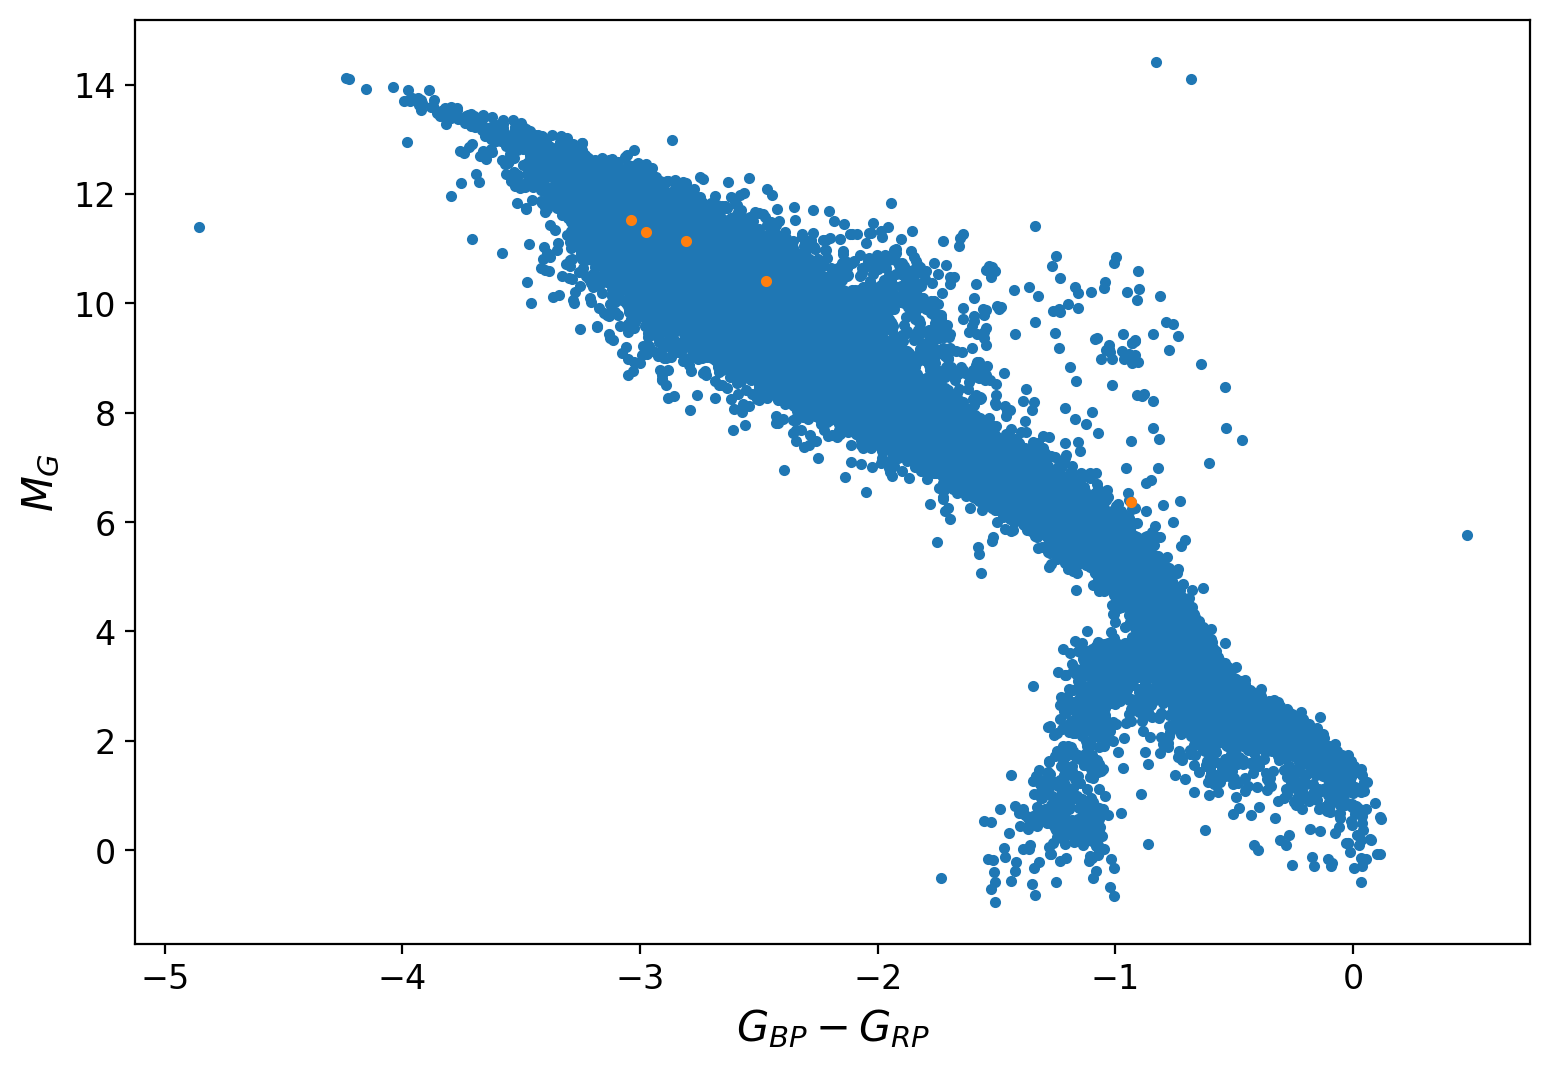

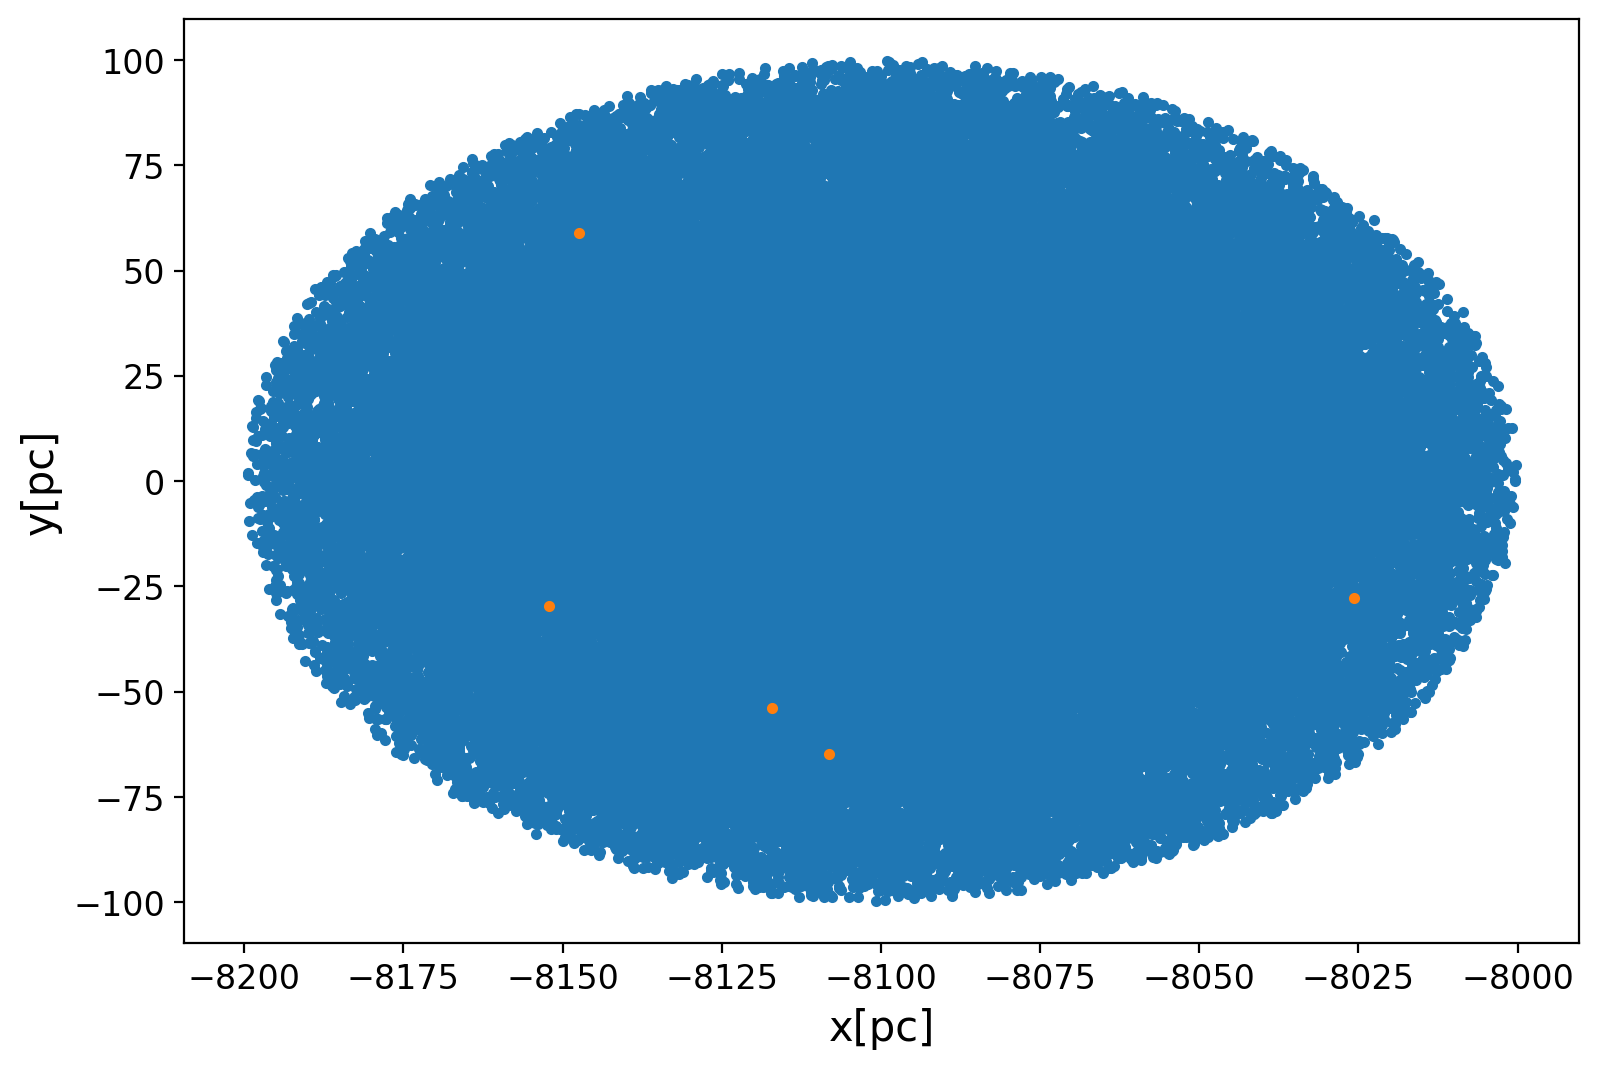

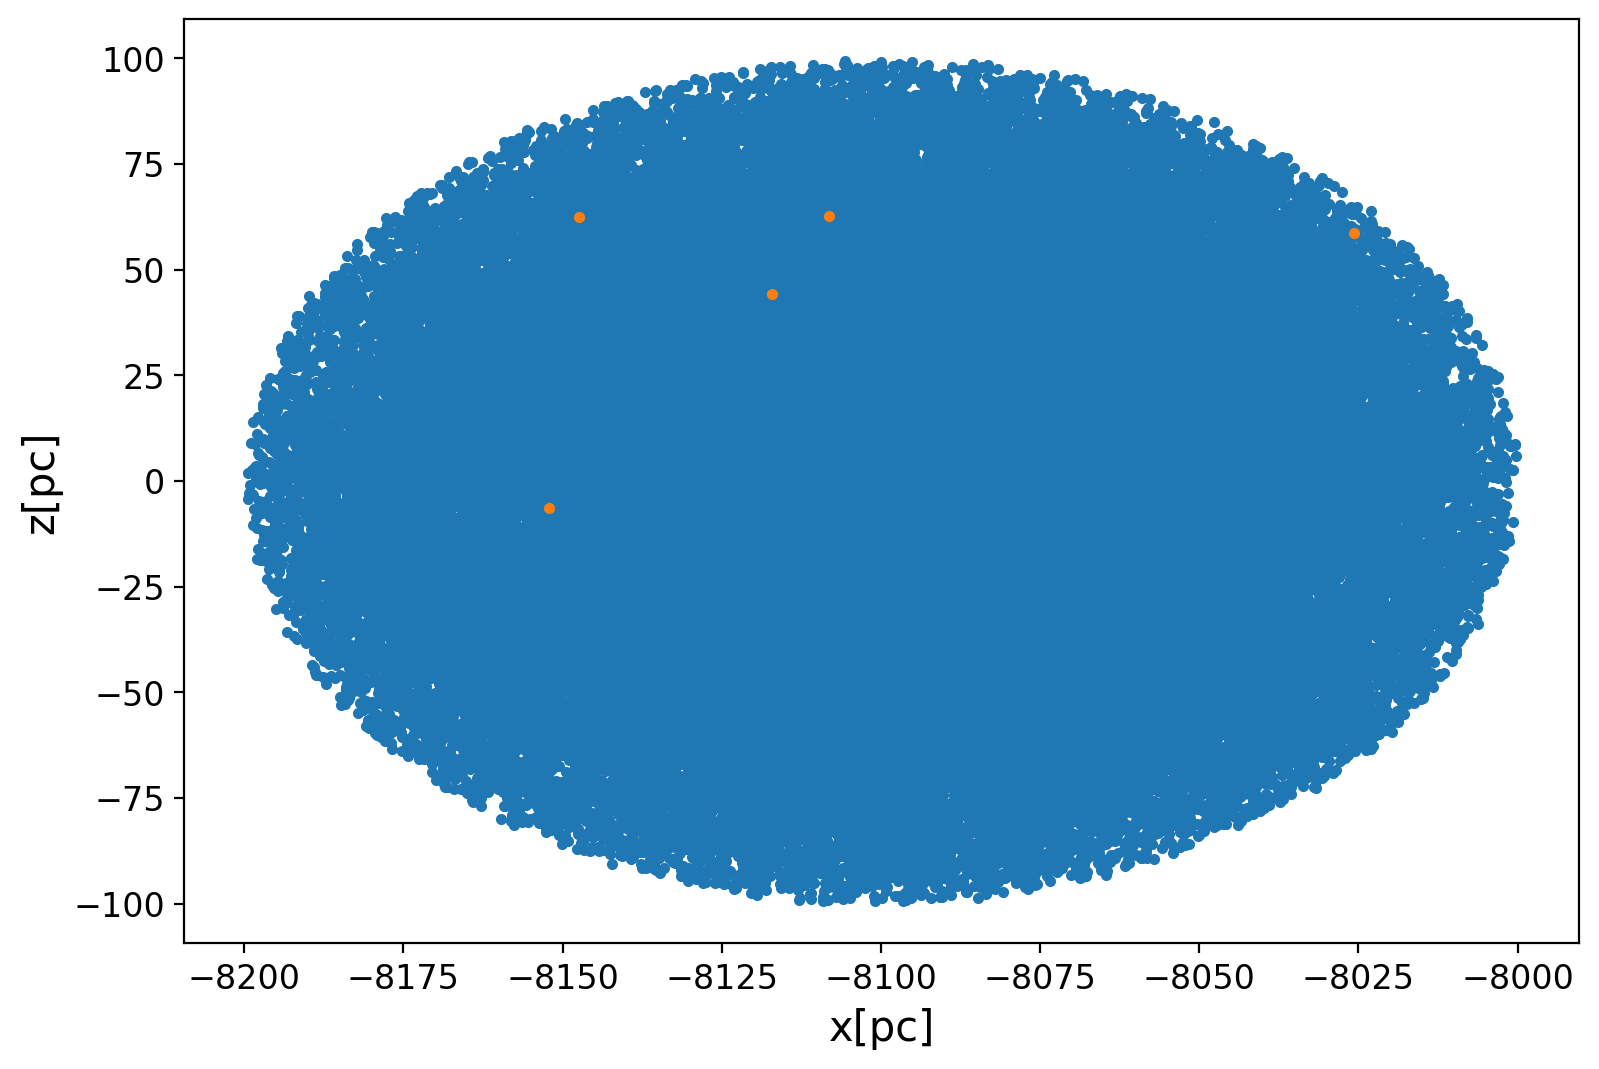

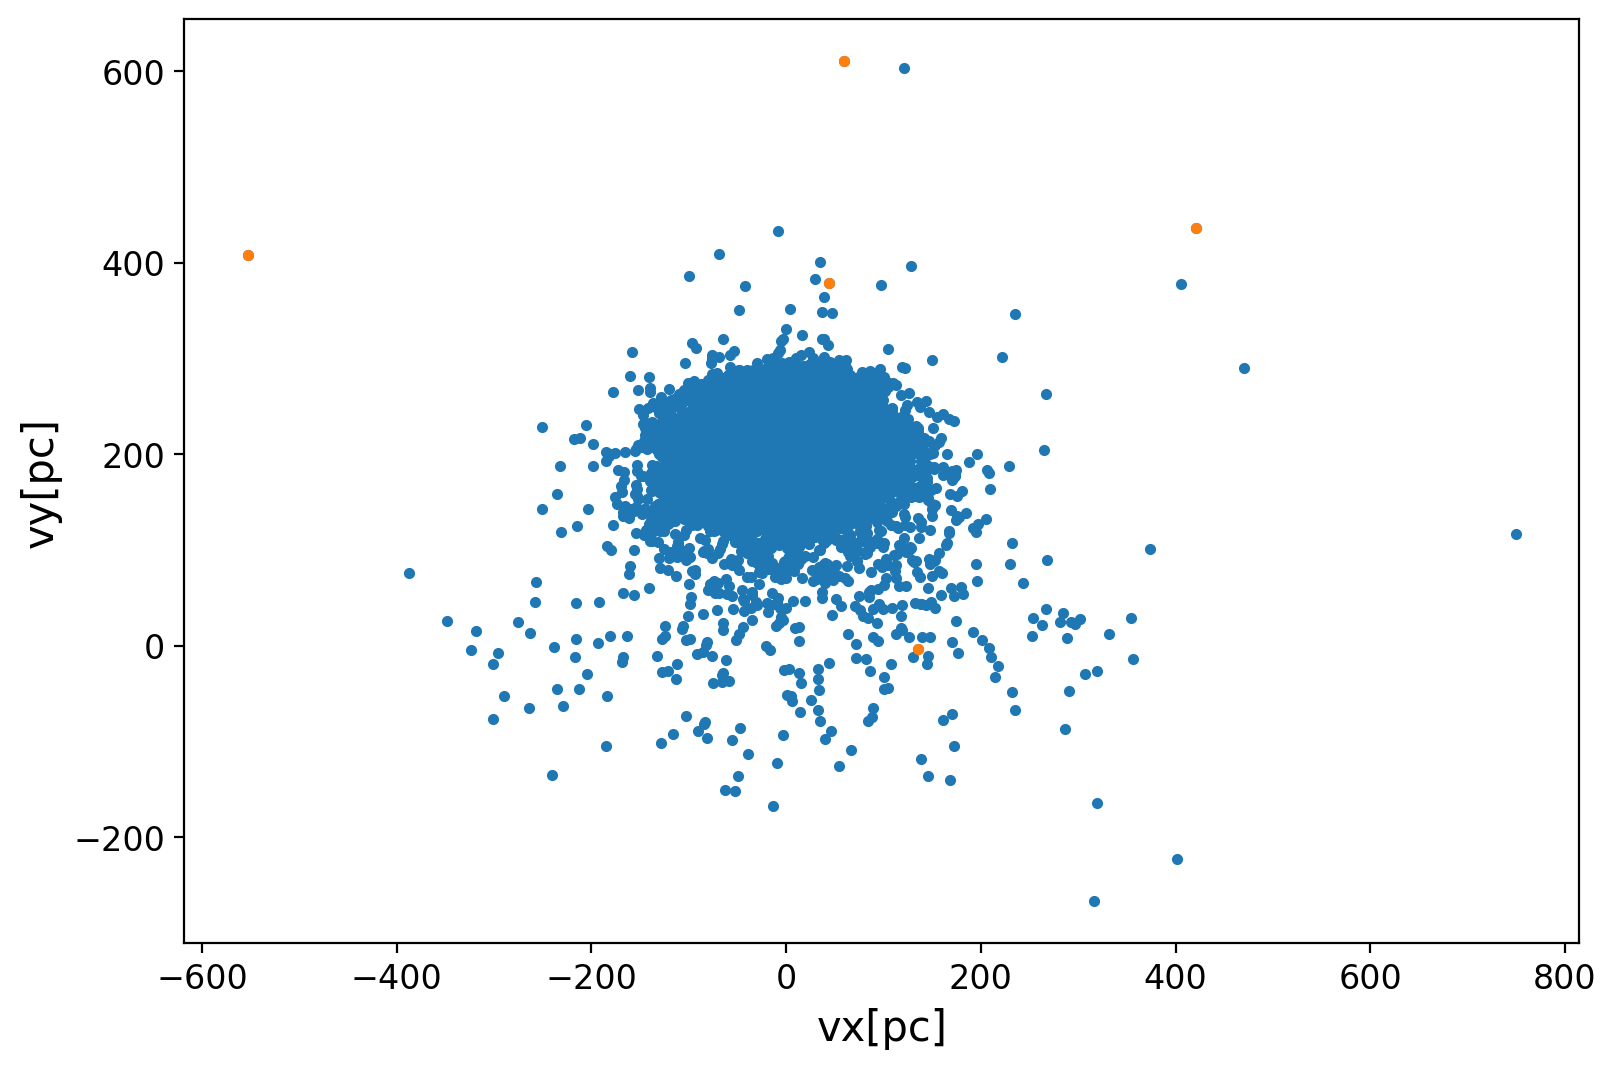

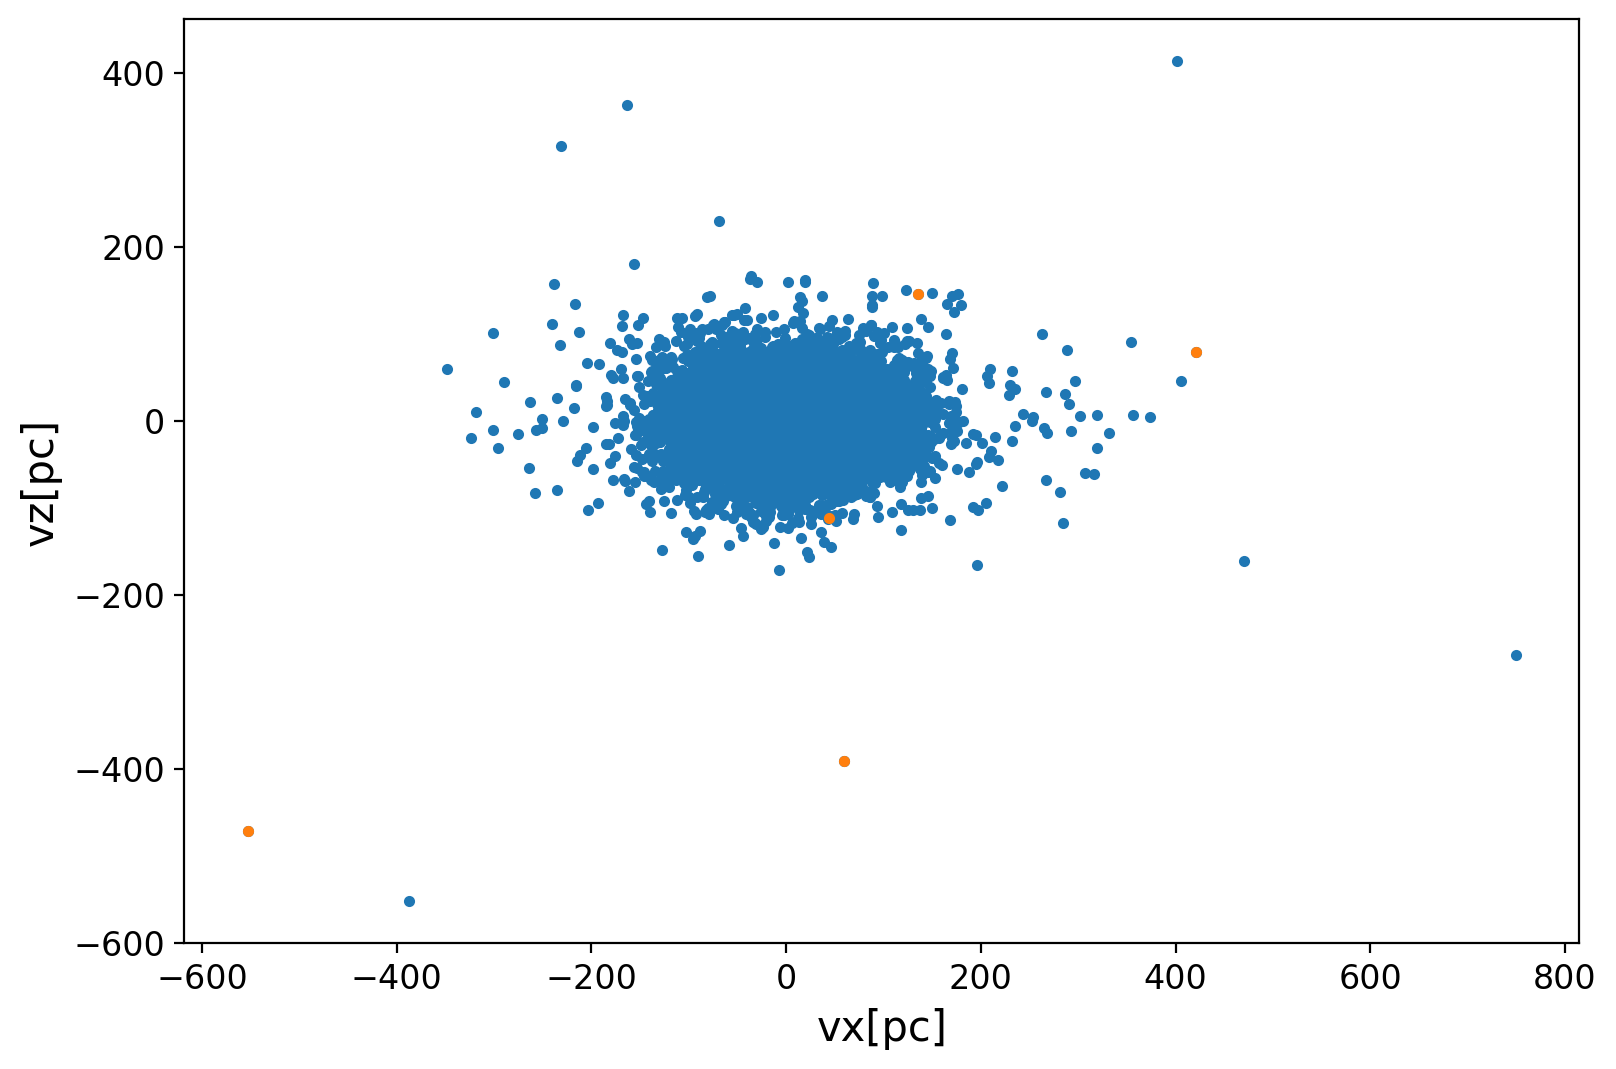

In [292]:
def plotAnomalyBasic(iCut,iRaw,iLoss,igalcen,iOrbitsAll):
    anomalies=(iLoss > iCut)
    baseidex=len(iRaw)-len(iLoss)
    testdata_raw = iRaw[baseidex:]
    anomaly_raw  = testdata_raw[anomalies]
    testgalcen   = igalcen[baseidex:]
    anomaly_galcen = testgalcen[anomalies]
    
    plt.plot(testdata_raw[:,2]-testdata_raw[:,1],testdata_raw[:,0], marker='.', linestyle='none')
    plt.plot(anomaly_raw[:,2]-anomaly_raw[:,1],anomaly_raw[:,0], marker='.', linestyle='none')
    plt.xlabel('$G_{BP}-G_{RP}$')
    plt.ylabel('$M_{G}$')
    plt.show()

    plt.plot(testdata_raw[:,3],testdata_raw[:,4], marker='.', linestyle='none')
    plt.plot(anomaly_raw[:,3],anomaly_raw[:,4], marker='.', linestyle='none')
    plt.xlabel("x[pc]")
    plt.ylabel("y[pc]")
    plt.show()

    plt.plot(testdata_raw[:,3],testdata_raw[:,5], marker='.', linestyle='none')
    plt.plot(anomaly_raw[:,3],anomaly_raw[:,5], marker='.', linestyle='none')
    plt.xlabel("x[pc]")
    plt.ylabel("z[pc]")
    plt.show()

    plt.plot(testdata_raw[:,6],testdata_raw[:,7], marker='.', linestyle='none')
    plt.plot(anomaly_raw[:,6],anomaly_raw[:,7], marker='.', linestyle='none')
    plt.xlabel("vx[pc]")
    plt.ylabel("vy[pc]")
    plt.show()

    plt.plot(testdata_raw[:,6],testdata_raw[:,8], marker='.', linestyle='none')
    plt.plot(anomaly_raw[:,6],anomaly_raw[:,8], marker='.', linestyle='none')
    plt.xlabel("vx[pc]")
    plt.ylabel("vz[pc]")
    plt.show()

def plotAnomalyComplex(iCut,iRaw,iLoss,igalcen,iOrbitsAll):
    anomalies=(iLoss > iCut)
    baseidex=len(iRaw)-len(iLoss)
    testdata_raw = iRaw[baseidex:]
    anomaly_raw  = testdata_raw[anomalies]
    testgalcen   = igalcen[baseidex:]
    anomaly_galcen = testgalcen[anomalies]
       
    print(len(testdata_raw),len(iRaw),len(igalcen),len(testgalcen))
    H = gp.Hamiltonian(milky_way)
    w0_anom = gd.PhaseSpacePosition(anomaly_galcen.cartesian)
    orbits_anom = H.integrate_orbit(w0_anom, dt=1*u.Myr, t1=0*u.Myr, t2=100*u.Myr)

    zmax_all = orbits_all.zmax(approximate=True)
    zmax_anom = orbits_anom.zmax(approximate=True)
    print(zmax_anom,"!! Anom 1")
    bins = np.linspace(0, 10, 50)
    plt.hist(zmax_all.value, bins=bins, alpha=0.4, density=True, label='all')
    plt.hist(zmax_anom.value, bins=bins, alpha=0.4, density=True, label='anom')
    plt.legend(loc='best', fontsize=14)
    plt.yscale('log')
    plt.xlabel(r"" + " [{0:latex}]".format(zmax_all.unit))
    plt.show()

    zmax_all  = orbits_all.eccentricity() 
    zmax_anom = orbits_anom.eccentricity() 
    bins = np.linspace(0, 10, 50)
    plt.hist(zmax_all.value,  bins=bins, alpha=0.4, density=True, label='all')
    plt.hist(zmax_anom.value, bins=bins, alpha=0.4, density=True, label='anom')
    plt.legend(loc='best', fontsize=14)
    plt.yscale('log')
    plt.xlabel('Eccentricity')
    plt.show()
    
plotAnomalyBasic(45,processed_data_raw,testloss,galcen_clean,orbits_all)

84116 168208 168208 84116
[       nan        nan 2.76566518        nan        nan] kpc !! Anom 1


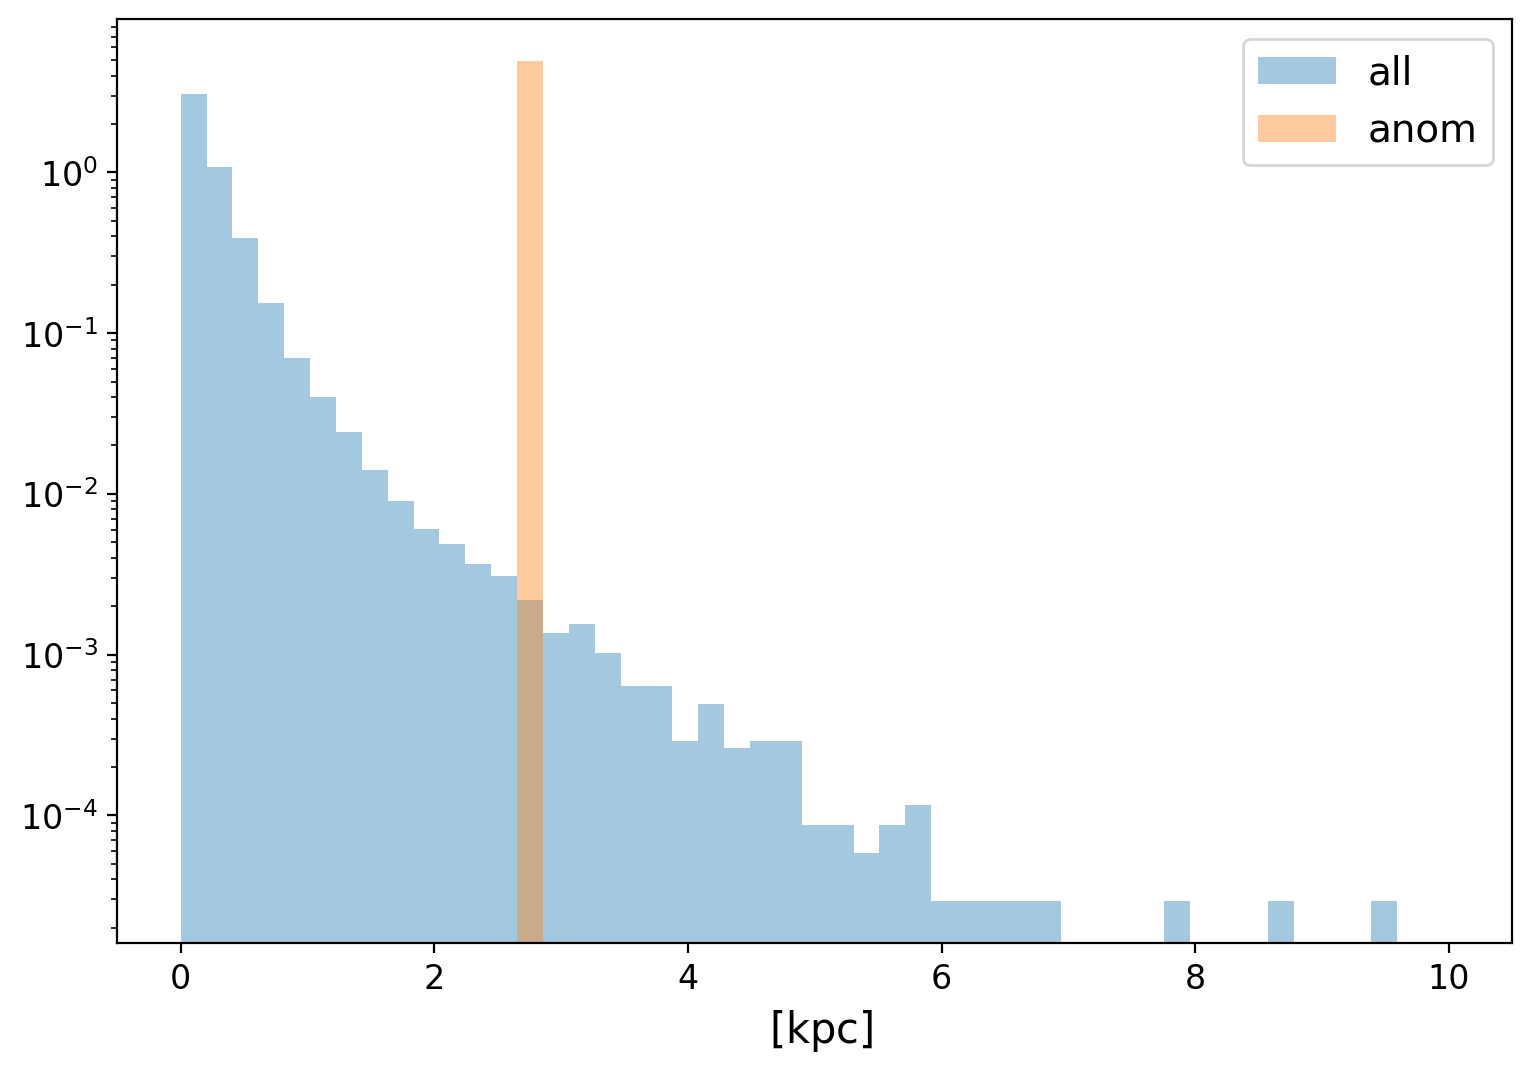

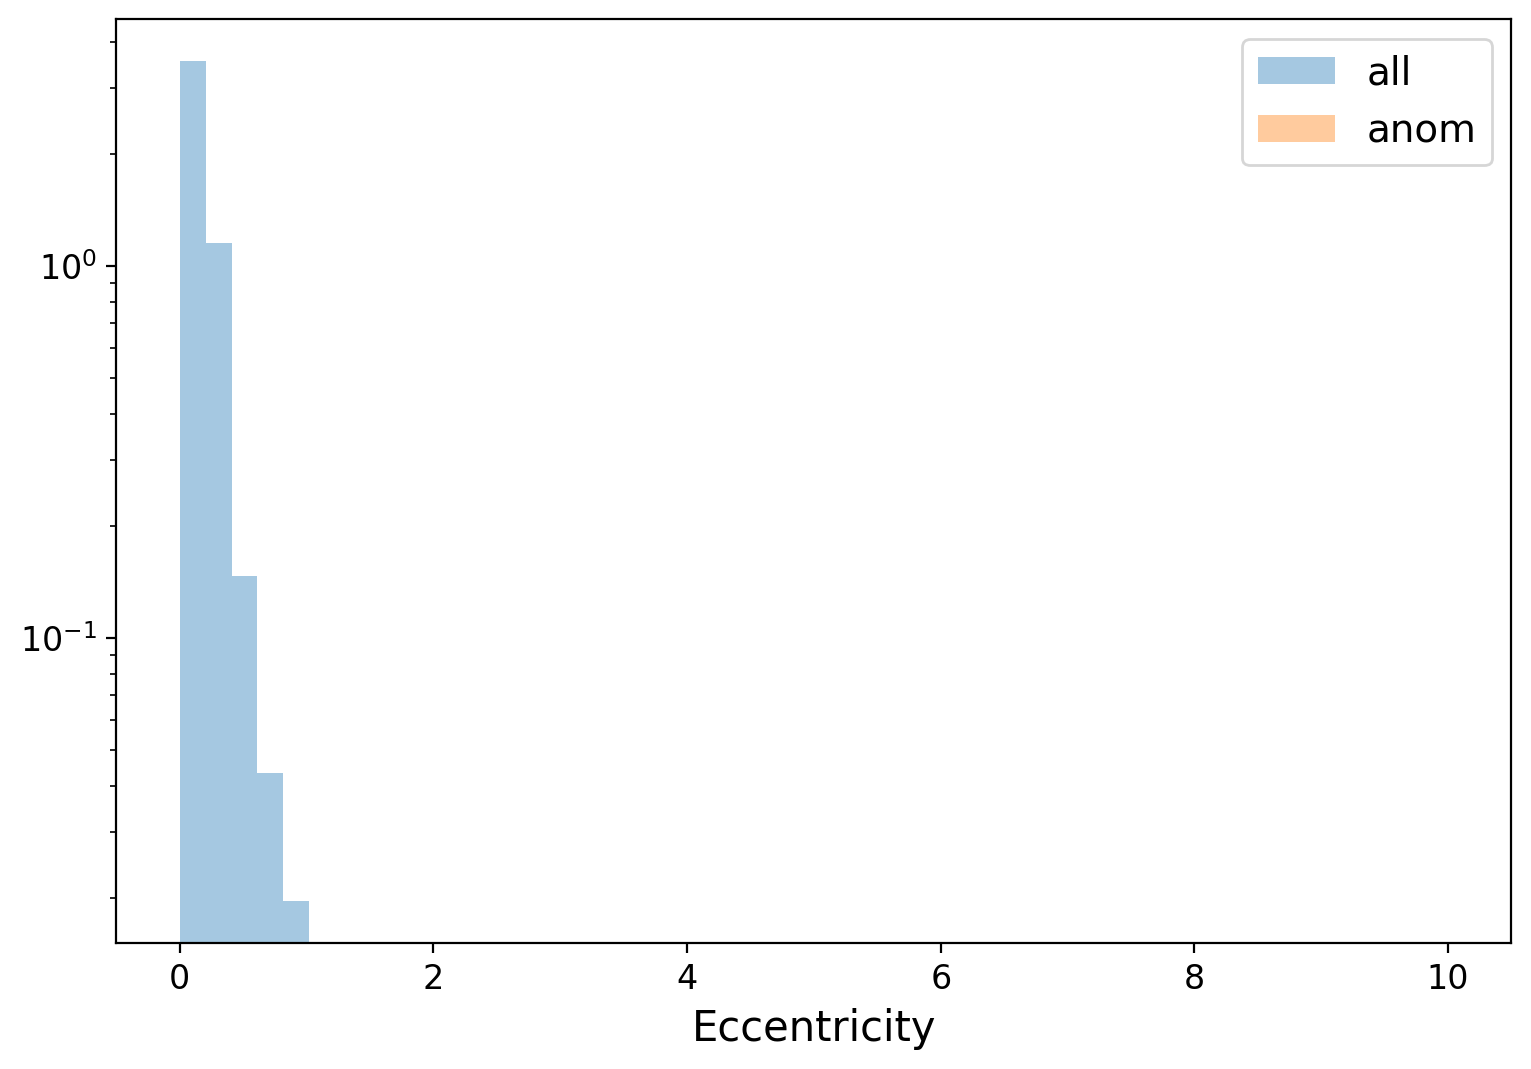

In [293]:
plotAnomalyComplex(45,processed_data_raw,testloss,galcen_clean,orbits_all)

In [315]:
H = gp.Hamiltonian(milky_way)
w0_anom = gd.PhaseSpacePosition(anomaly_galcen.cartesian)
orbits_anom = H.integrate_orbit(w0_anom, dt=1*u.Myr, t1=0*u.Myr, t2=500*u.Myr)
print("start all")
#orbits_all  = H.integrate_orbit(w0_all, dt=1*u.Myr, t1=0*u.Myr, t2=500*u.Myr)
print("get z")
zmax_anom = orbits_anom.zmax(approximate=True)
print("get z",zmax_anom)
ecc_anom  = orbits_anom.eccentricity() 
print("get ec",ecc_anom)

start all
get z
get z [       nan 1.59439137 6.76420776        nan 5.35233742] kpc
get ec [       nan        nan 0.69779114        nan 0.67513776]


In [313]:
#ecc_all  = orbits_all.eccentricity() 
zmax_all = orbits_all.zmax(approximate=True)

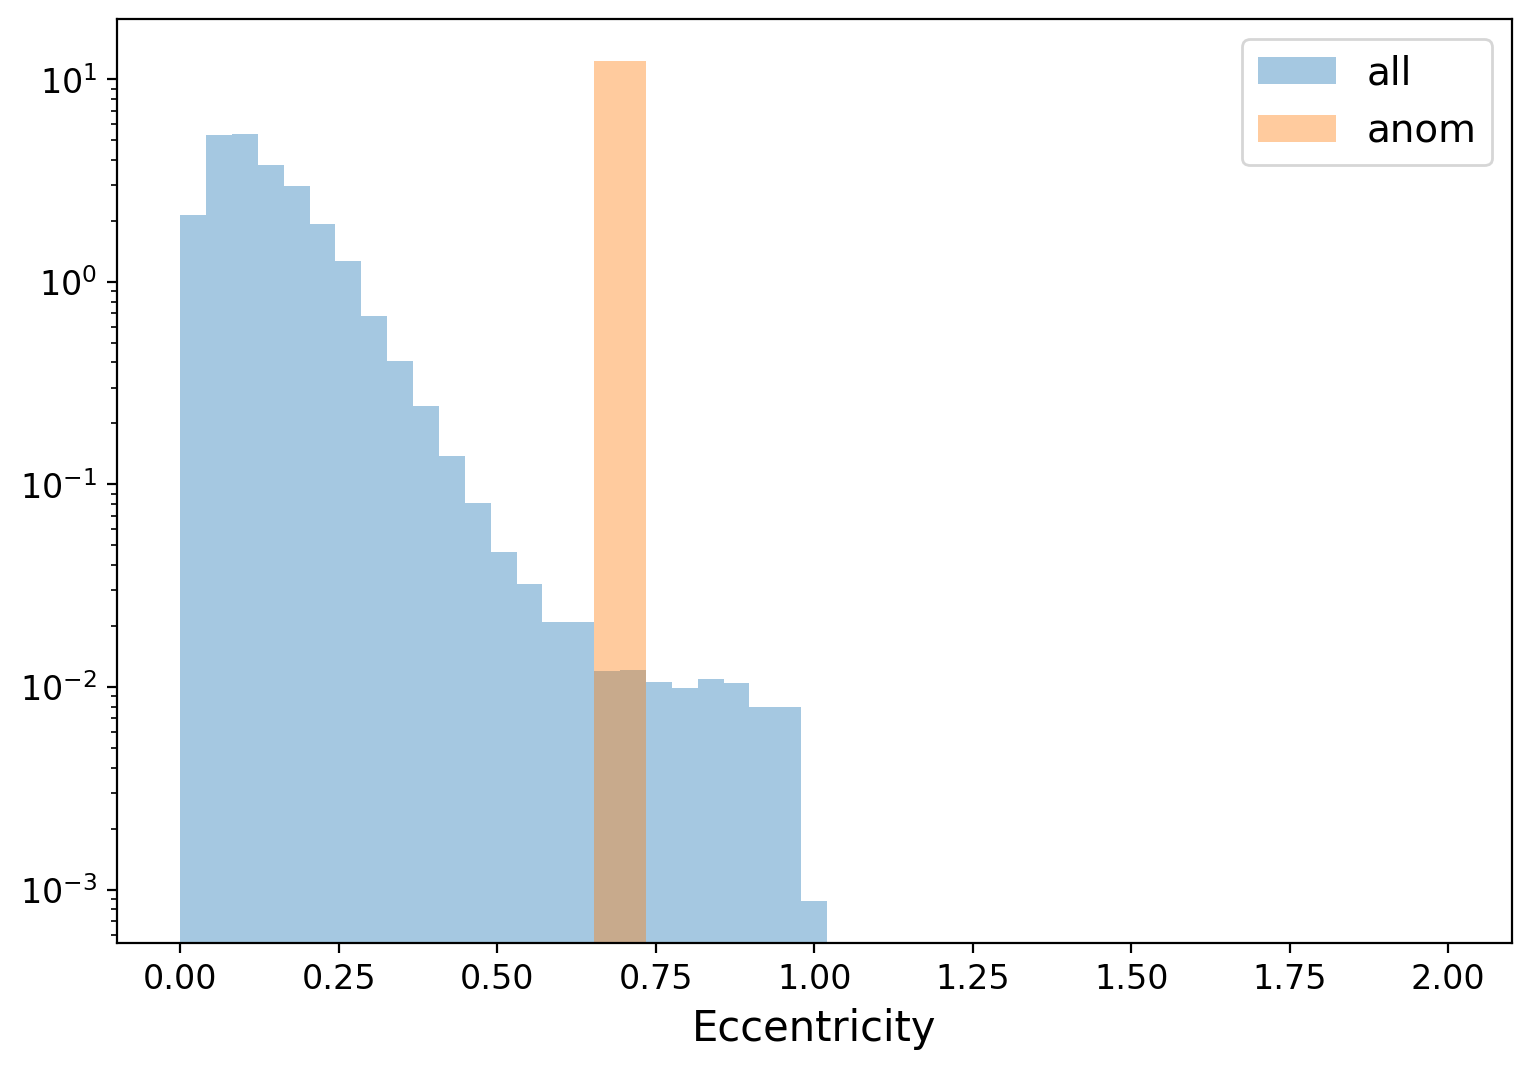

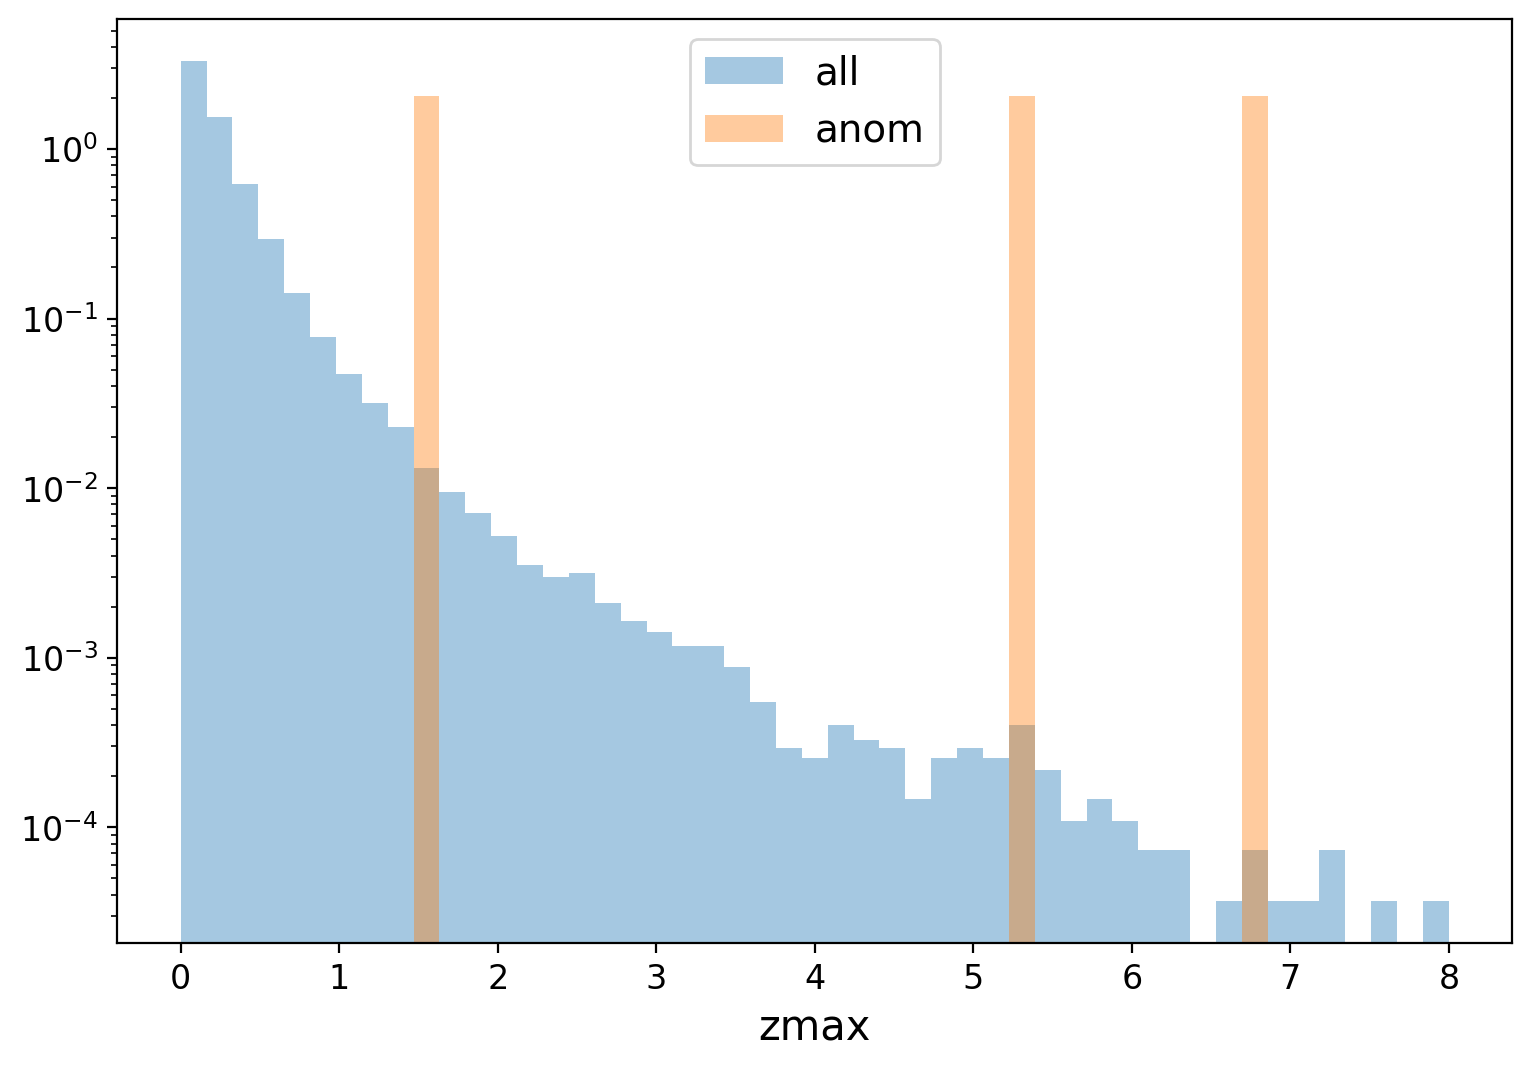

In [320]:
bins = np.linspace(0, 2, 50)
plt.hist(ecc_all.value,  bins=bins, alpha=0.4, density=True, label='all')
plt.hist(ecc_anom.value, bins=bins, alpha=0.4, density=True, label='anom')
plt.legend(loc='best', fontsize=14)
plt.yscale('log')
plt.xlabel('Eccentricity')
plt.show()

bins = np.linspace(0, 8, 50)
plt.hist(zmax_all.value,  bins=bins, alpha=0.4, density=True, label='all')
plt.hist(zmax_anom.value, bins=bins, alpha=0.4, density=True, label='anom')
plt.legend(loc='best', fontsize=14)
plt.yscale('log')
plt.xlabel('zmax')
plt.show()

total Anoms 18
[0.49577373 0.21853159 0.03157342 0.30815746        nan 0.99673018
 1.59439137 6.78320529 2.91710581 2.70355699 0.21112544        nan
 5.74697702 2.32419388 0.58655125 0.32372842 0.89363407        nan] kpc !! Anom 1


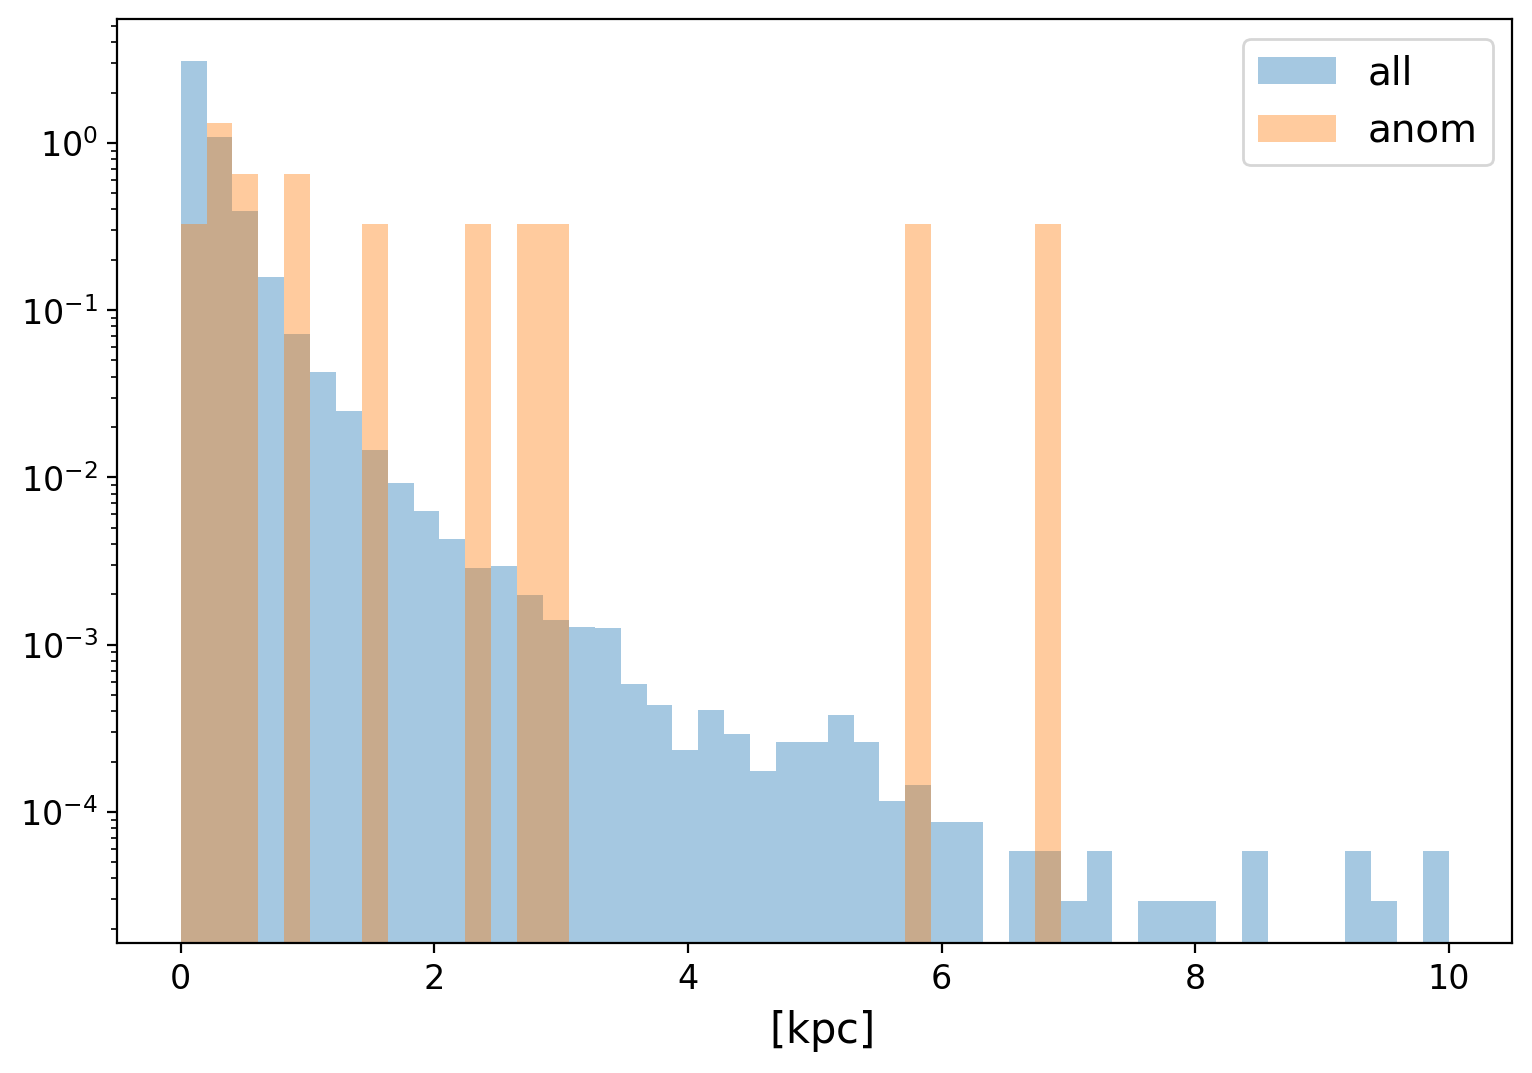

[       nan        nan 0.31743981 0.17815348        nan 0.25658903
        nan 0.69910452 0.55712352 0.14505039 0.8494161         nan
 0.67499062 0.45017158 0.27179939 0.17315666 0.30434788        nan] !! Anom 2


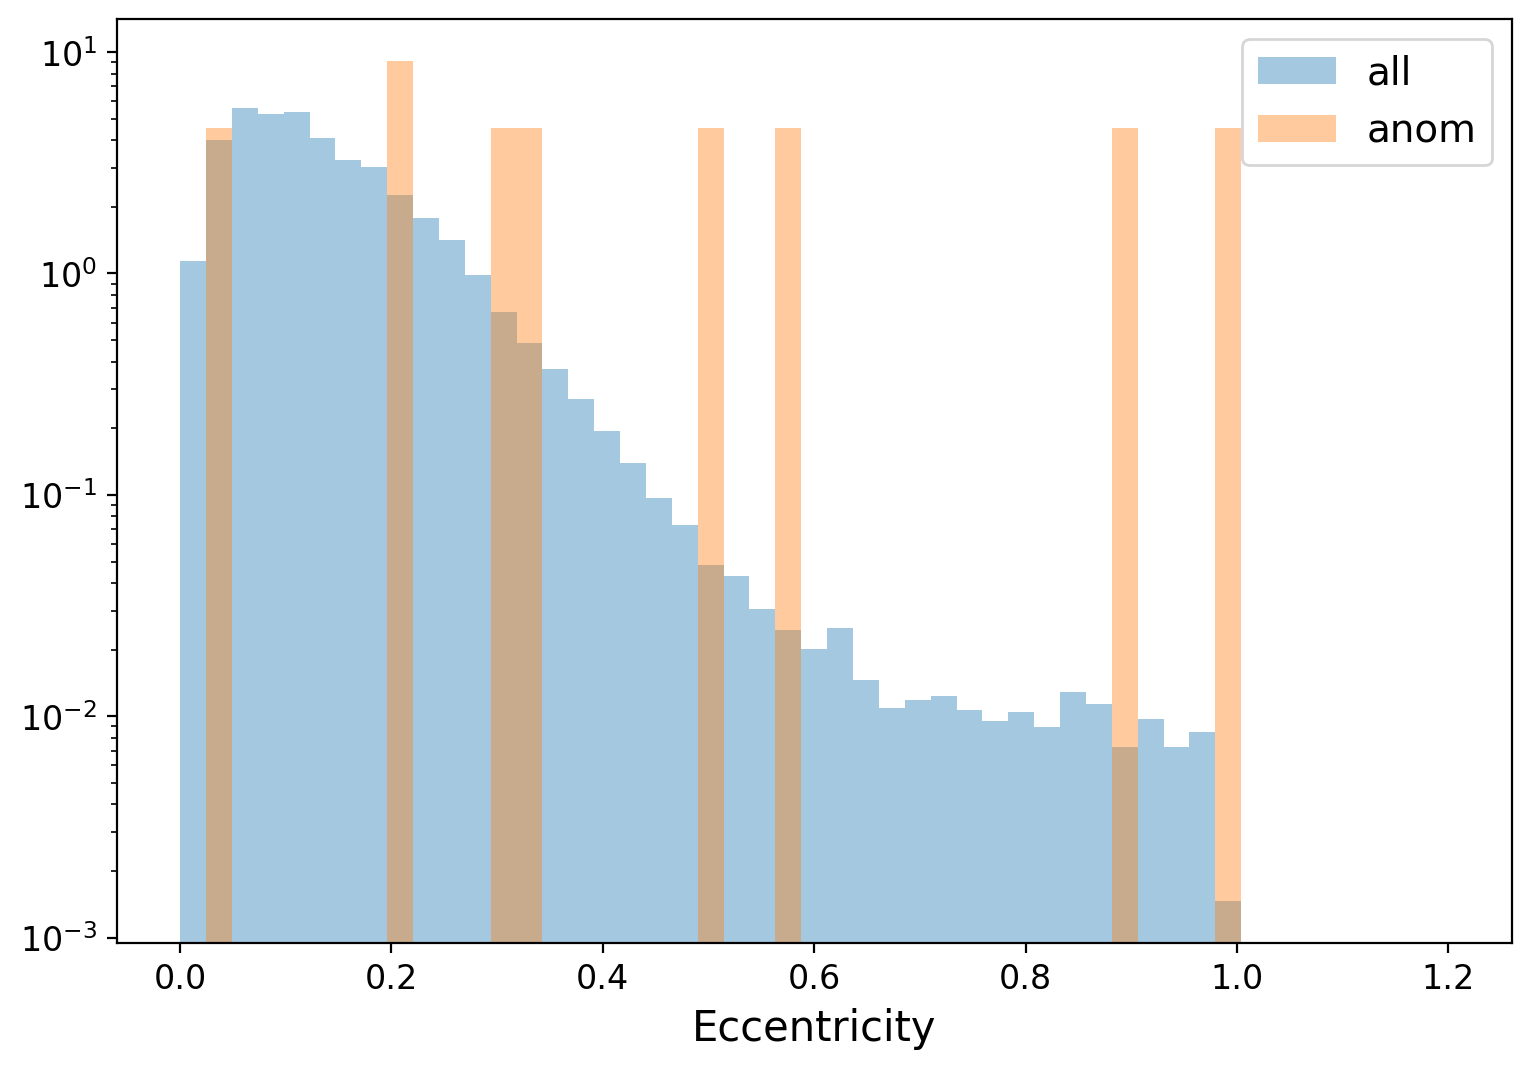

In [329]:
def plotAnomalyComplex(iCut,iRaw,iLoss,igalcen,iOrbitsAll,iEccAll,iZAll):
    anomalies=(iLoss > iCut)
    baseidex=len(iRaw)-len(iLoss)
    testdata_raw = iRaw[baseidex:]
    anomaly_raw  = testdata_raw[anomalies]
    testgalcen   = igalcen[baseidex:]
    anomaly_galcen = testgalcen[anomalies]
    print("total Anoms",len(anomaly_galcen))
    H = gp.Hamiltonian(milky_way)
    w0_anom = gd.PhaseSpacePosition(anomaly_galcen.cartesian)
    orbits_anom = H.integrate_orbit(w0_anom, dt=1*u.Myr, t1=0*u.Myr, t2=1000*u.Myr)

    zmax_anom = orbits_anom.zmax(approximate=True)
    print(zmax_anom,"!! Anom 1")
    bins = np.linspace(0, 10, 50)
    plt.hist(iZAll.value, bins=bins, alpha=0.4, density=True, label='all')
    plt.hist(zmax_anom.value, bins=bins, alpha=0.4, density=True, label='anom')
    plt.legend(loc='best', fontsize=14)
    plt.yscale('log')
    plt.xlabel(r"" + " [{0:latex}]".format(zmax_all.unit))
    plt.show()

    ecc_anom  = orbits_anom.eccentricity() 
    print(ecc_anom,"!! Anom 2")
    bins = np.linspace(0, 1.2, 50)
    plt.hist(iEccAll.value,  bins=bins, alpha=0.4, density=True, label='all')
    plt.hist(zmax_anom.value, bins=bins, alpha=0.4, density=True, label='anom')
    plt.legend(loc='best', fontsize=14)
    plt.yscale('log')
    plt.xlabel('Eccentricity')
    plt.show()
    
plotAnomalyComplex(20,processed_data_raw,testloss,galcen_clean,orbits_all,ecc_all,zmax_all)

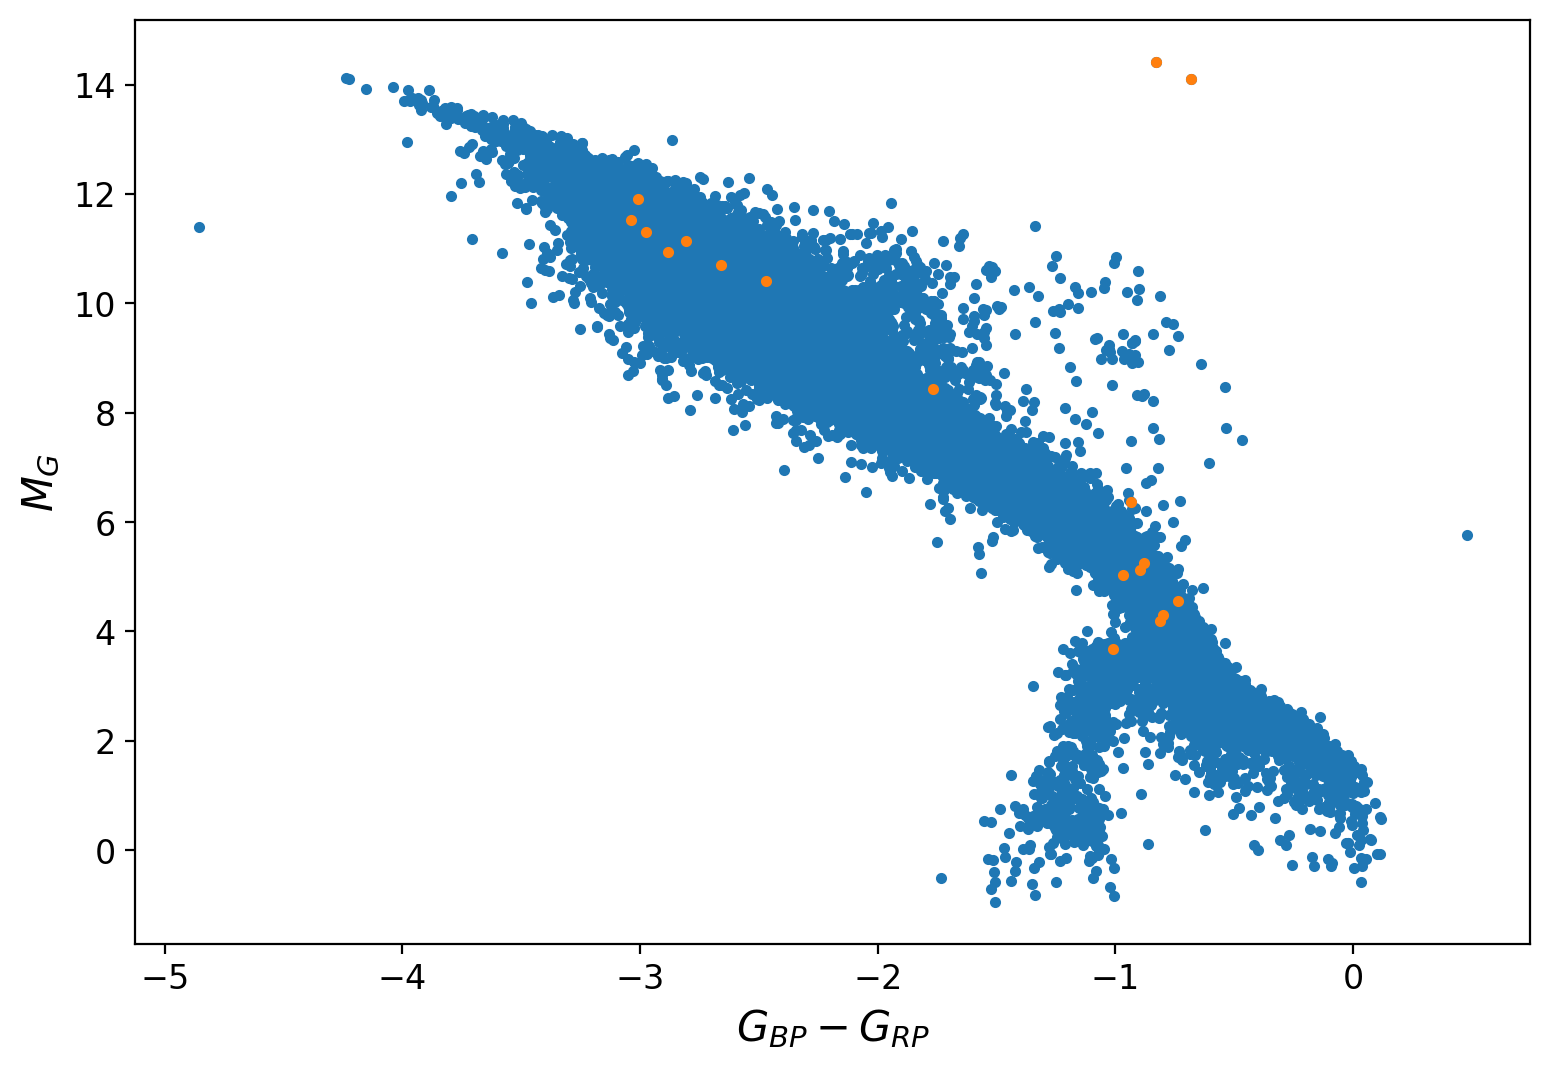

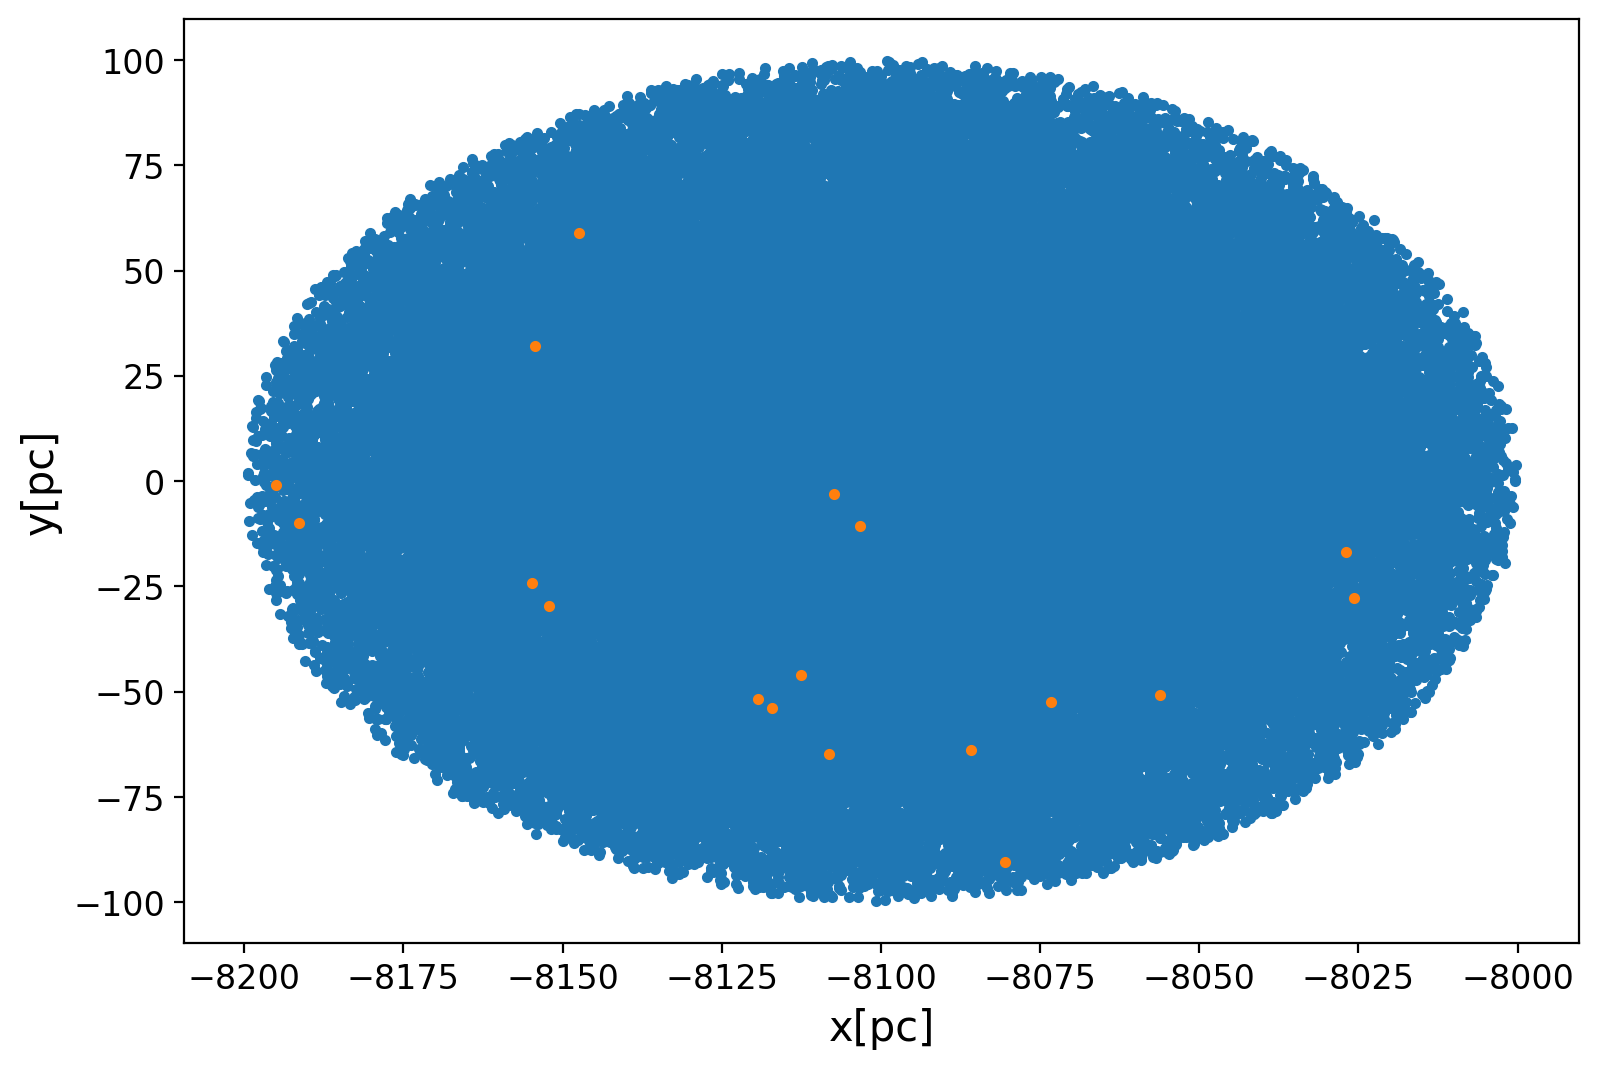

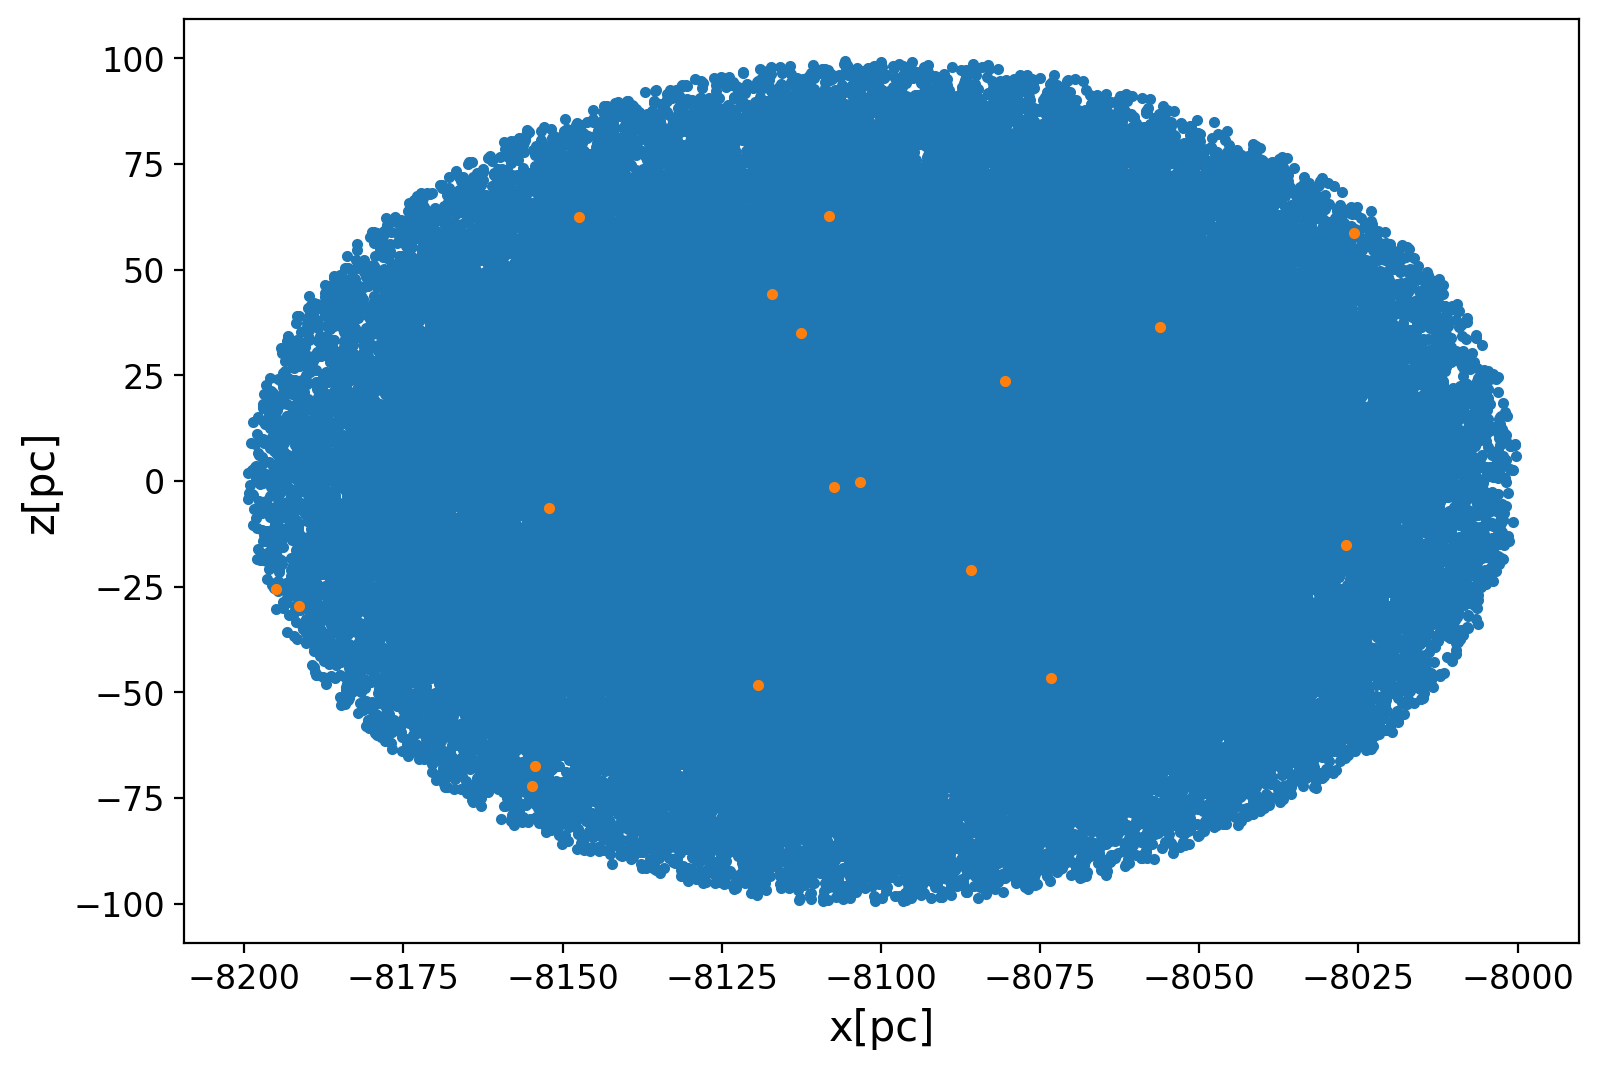

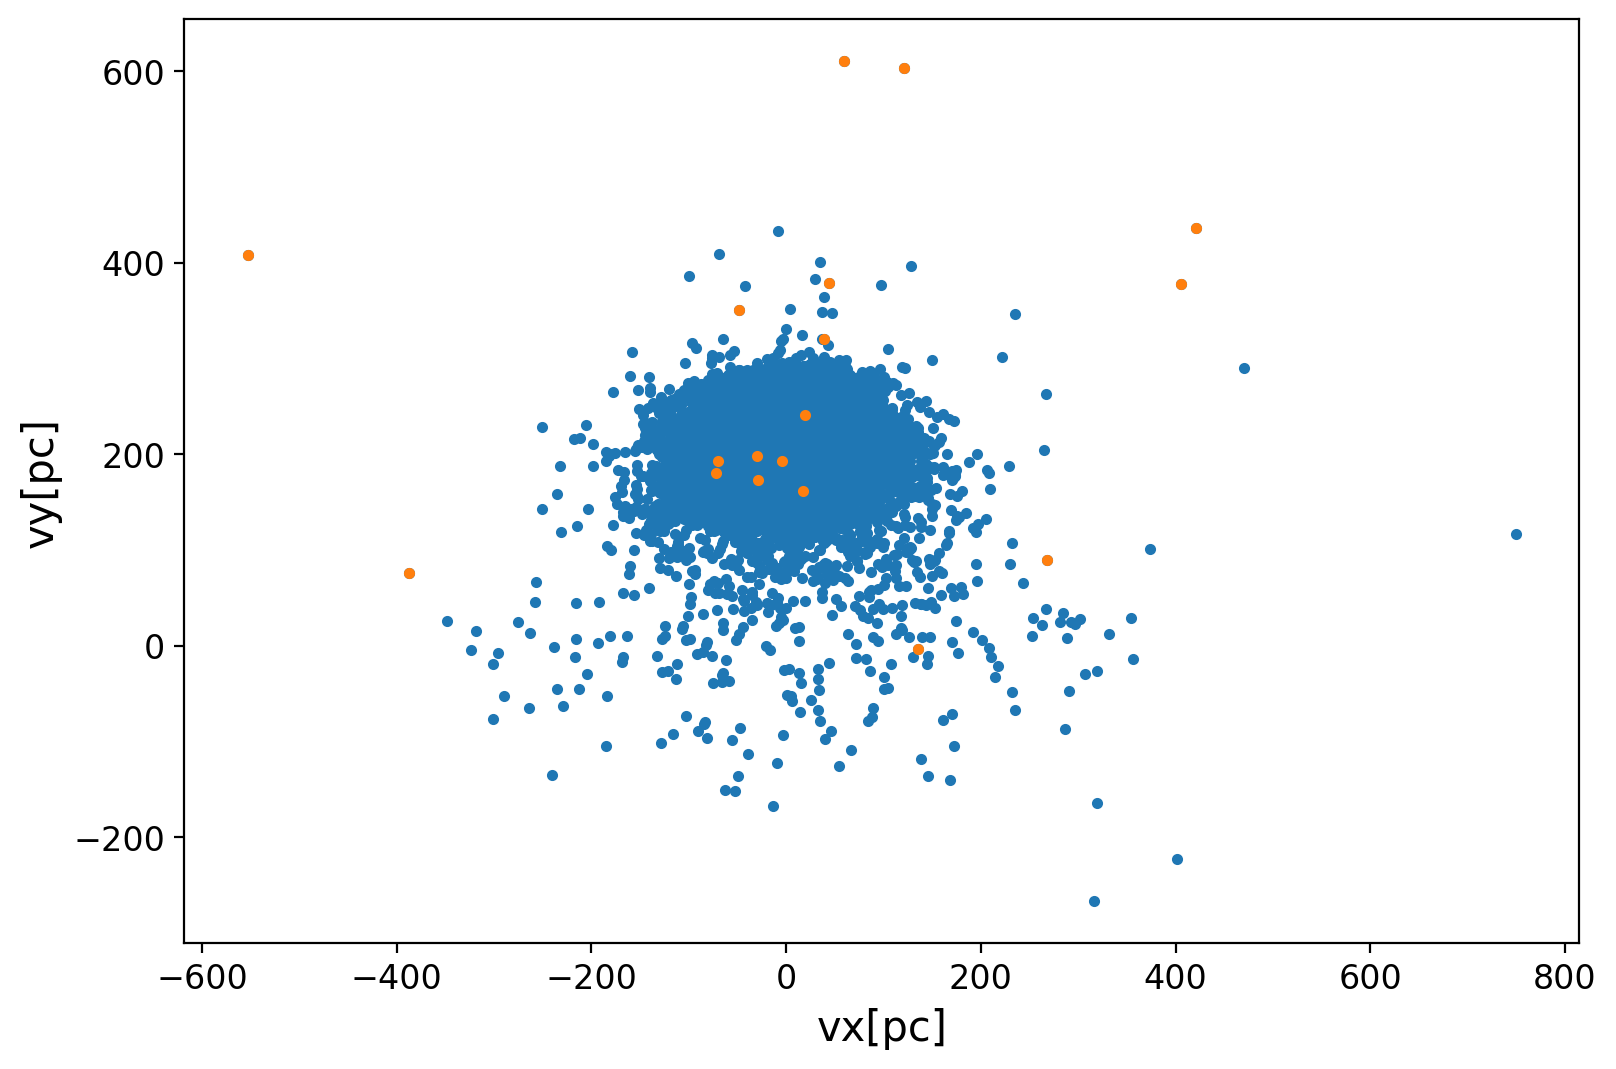

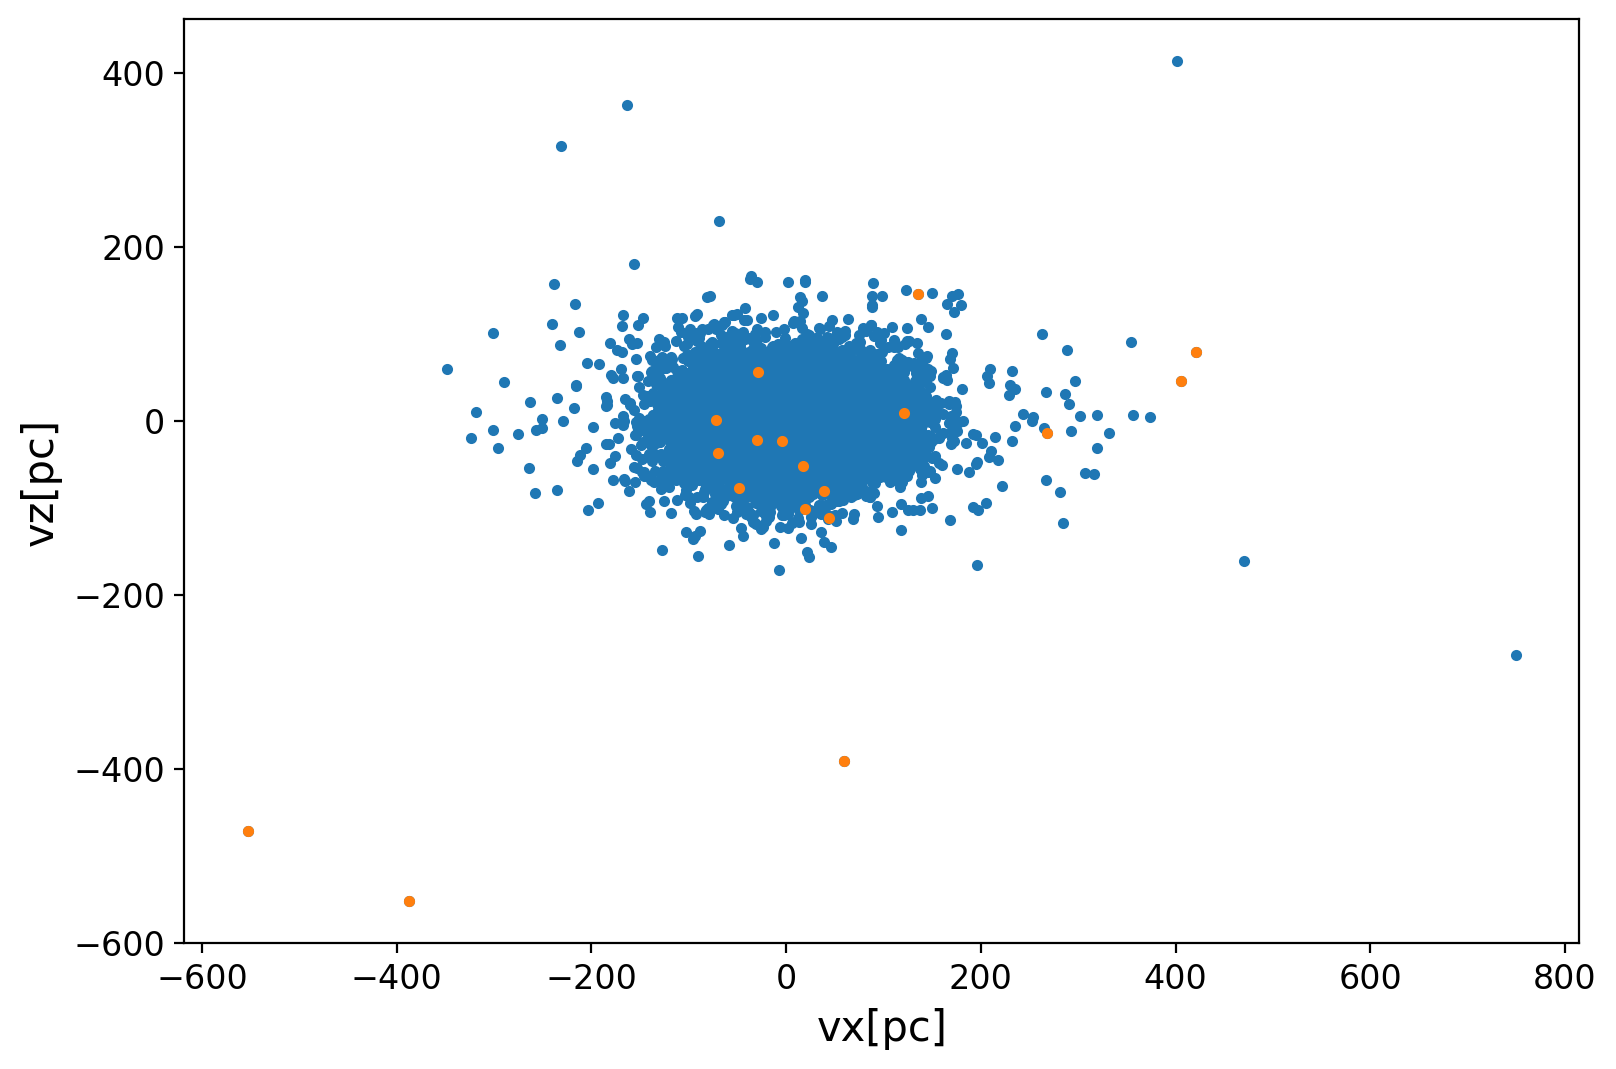

In [330]:
plotAnomalyBasic(20,processed_data_raw,testloss,galcen_clean,orbits_all)

Now it seems we are picking out stars that have weird paths. We can go in detail and investigate these some more. However, before we do that, lets train a different type of anomaly detection, we can do a VAE. Let's see if we see anything else different. 

In [350]:
import torch.nn.functional as F

class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dims,latent_dims):  
        super(VariationalAutoEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dims, 100)
        self.batch = nn.BatchNorm1d(20)
        self.linear2 = nn.Linear(100, 20)
        self.linear3 = nn.Linear(20, latent_dims)
        self.linear4 = nn.Linear(20, latent_dims)

        #Now we need sample in phase space 
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc 
        self.N.scale = self.N.scale
        self.kl = 0
        
        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 20),
            nn.ReLU(True),
            nn.Linear(20, 100),
            nn.ReLU(True),
            nn.Linear(100, input_dims),
        )

        
    def encoder(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.batch(self.linear2(x)))
        mu =  self.linear3(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear4(x)) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape) #smear 
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum() #Now compute the KL divergence
        return z
            
    def decoder(self, x):
        x = self.decoder_lin(x)
        return x
    
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)
    

def train(x,vae,opt,sched,nepochs):
    vae.train(True)
    for epoch in range(nepochs):
        prediction = vae(x)
        opt.zero_grad()
        loss = ((x - prediction)**2).sum() + 0.01*vae.kl
        loss.backward() 
        opt.step()
        if epoch % 500 == 0: 
            print('[%d] loss: %.4f ' % (epoch + 1, loss.item()  ))
    #sched.step()
    return    
    
latent_dim=2
model     = VariationalAutoEncoder(trainset.shape[1],latent_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1, last_epoch=-1, verbose=False)

In [351]:
train(trainset,model,optimizer,scheduler,5001)

[1] loss: 802084.6250 
[501] loss: 255657.7656 
[1001] loss: 231627.4844 
[1501] loss: 221197.4688 
[2001] loss: 212435.7656 
[2501] loss: 208196.7031 
[3001] loss: 204942.1562 
[3501] loss: 205624.6719 
[4001] loss: 200461.1562 
[4501] loss: 201744.9688 
[5001] loss: 195342.4375 


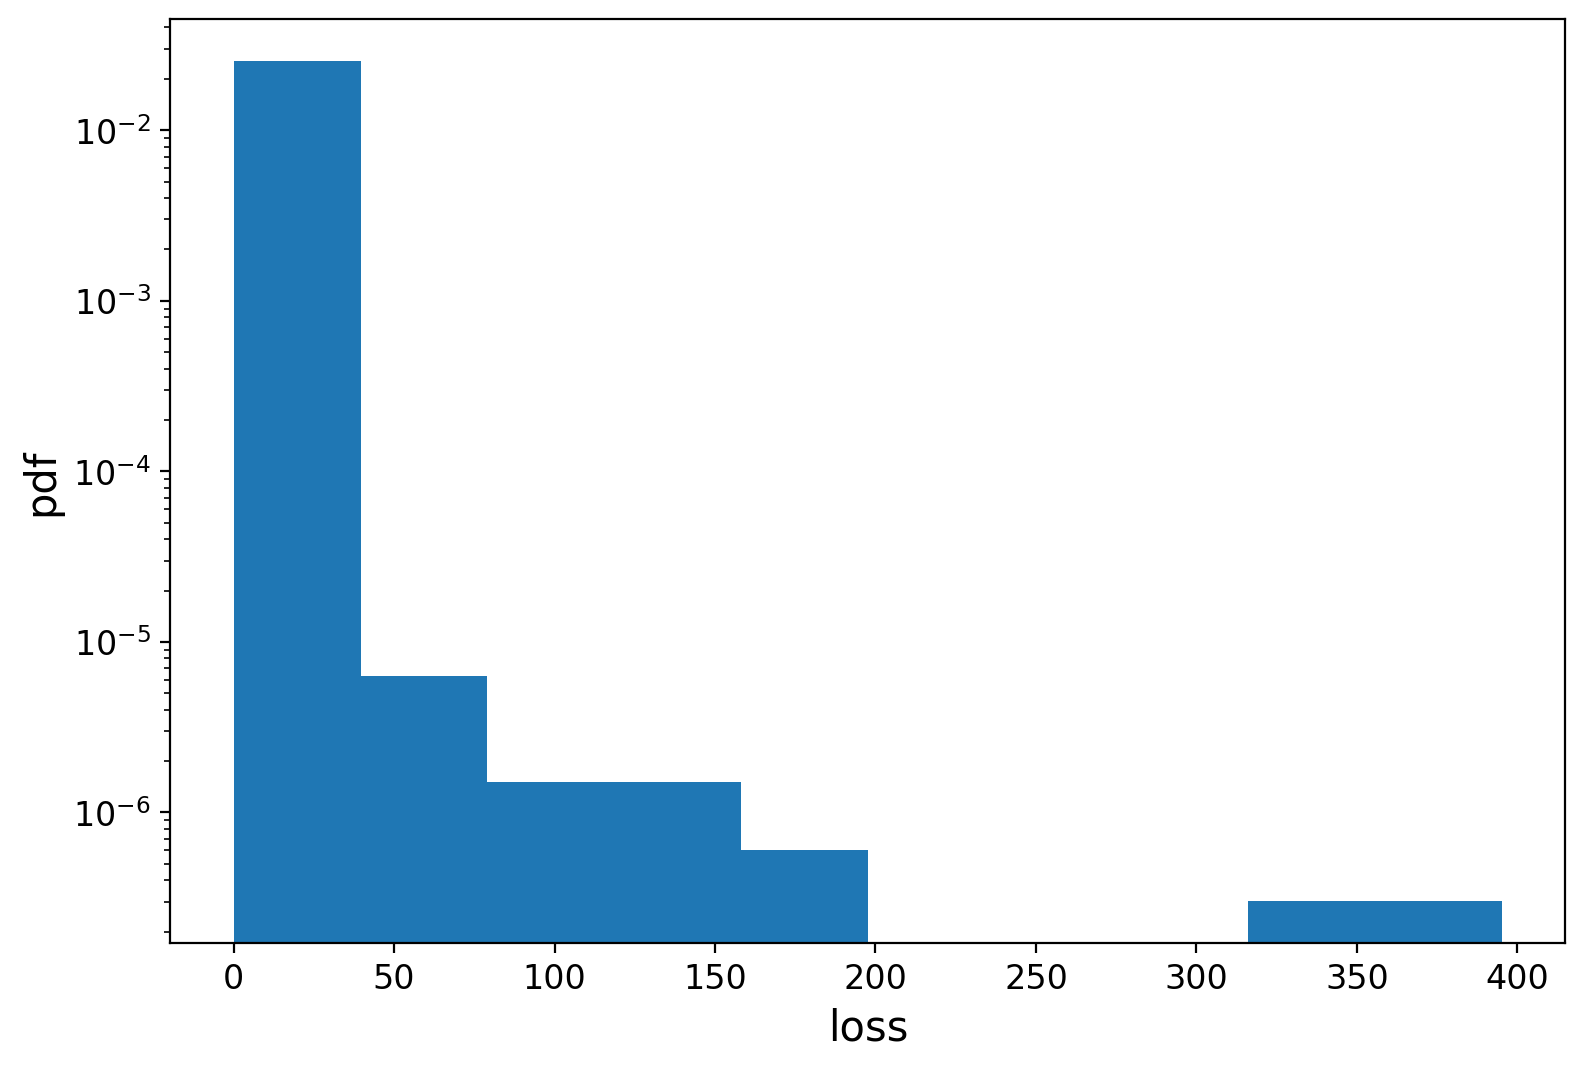

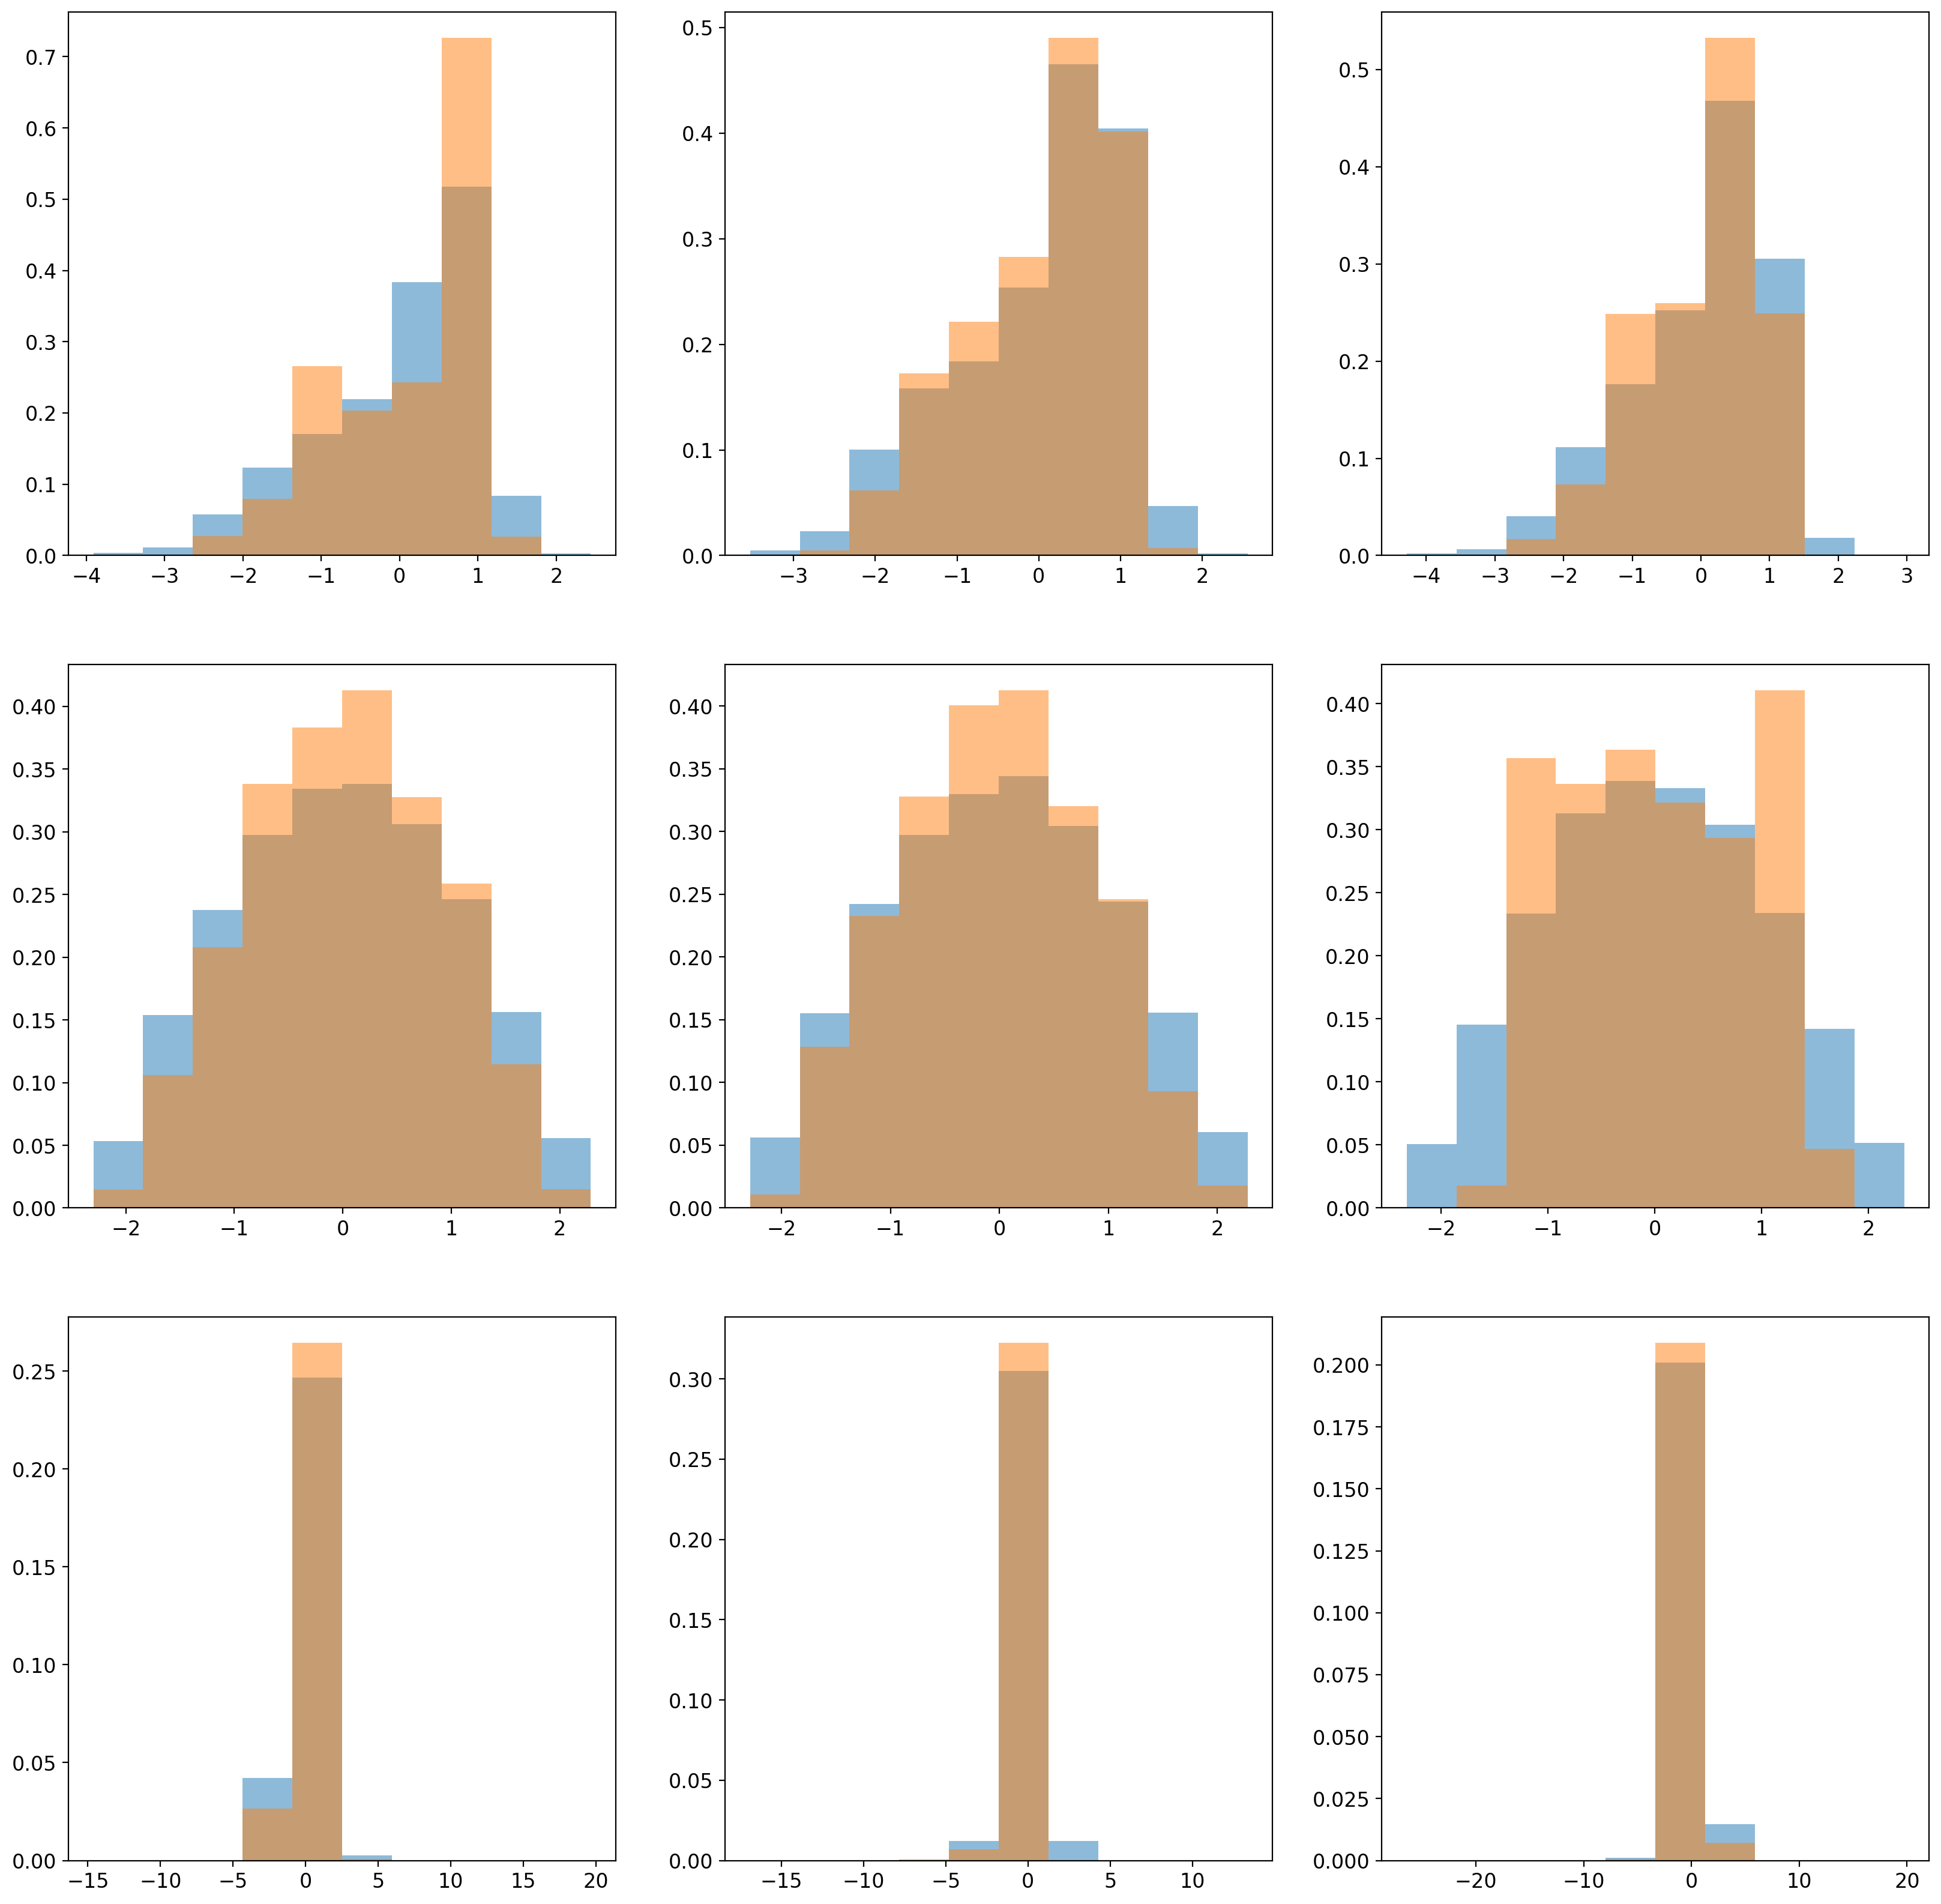

In [352]:
model.train(False)
output=model(testset)
testloss=torch.sum((testset-output)**2,axis=1)
plt.hist(testloss[testloss < 500].detach().numpy(),density=True)
plt.yscale('log')
plt.xlabel('loss')
plt.ylabel('pdf')
plt.show()

fig, ax = plt.subplots(3, 3, figsize=(20, 20))
for var in range(testset.shape[1]):
    _,bins,_=ax[var//3,var % 3].hist(testset[:,var].detach().numpy(),density=True,alpha=0.5)
    ax[var//3,var % 3].hist(output [:,var].detach().numpy(),density=True,alpha=0.5,bins=bins)

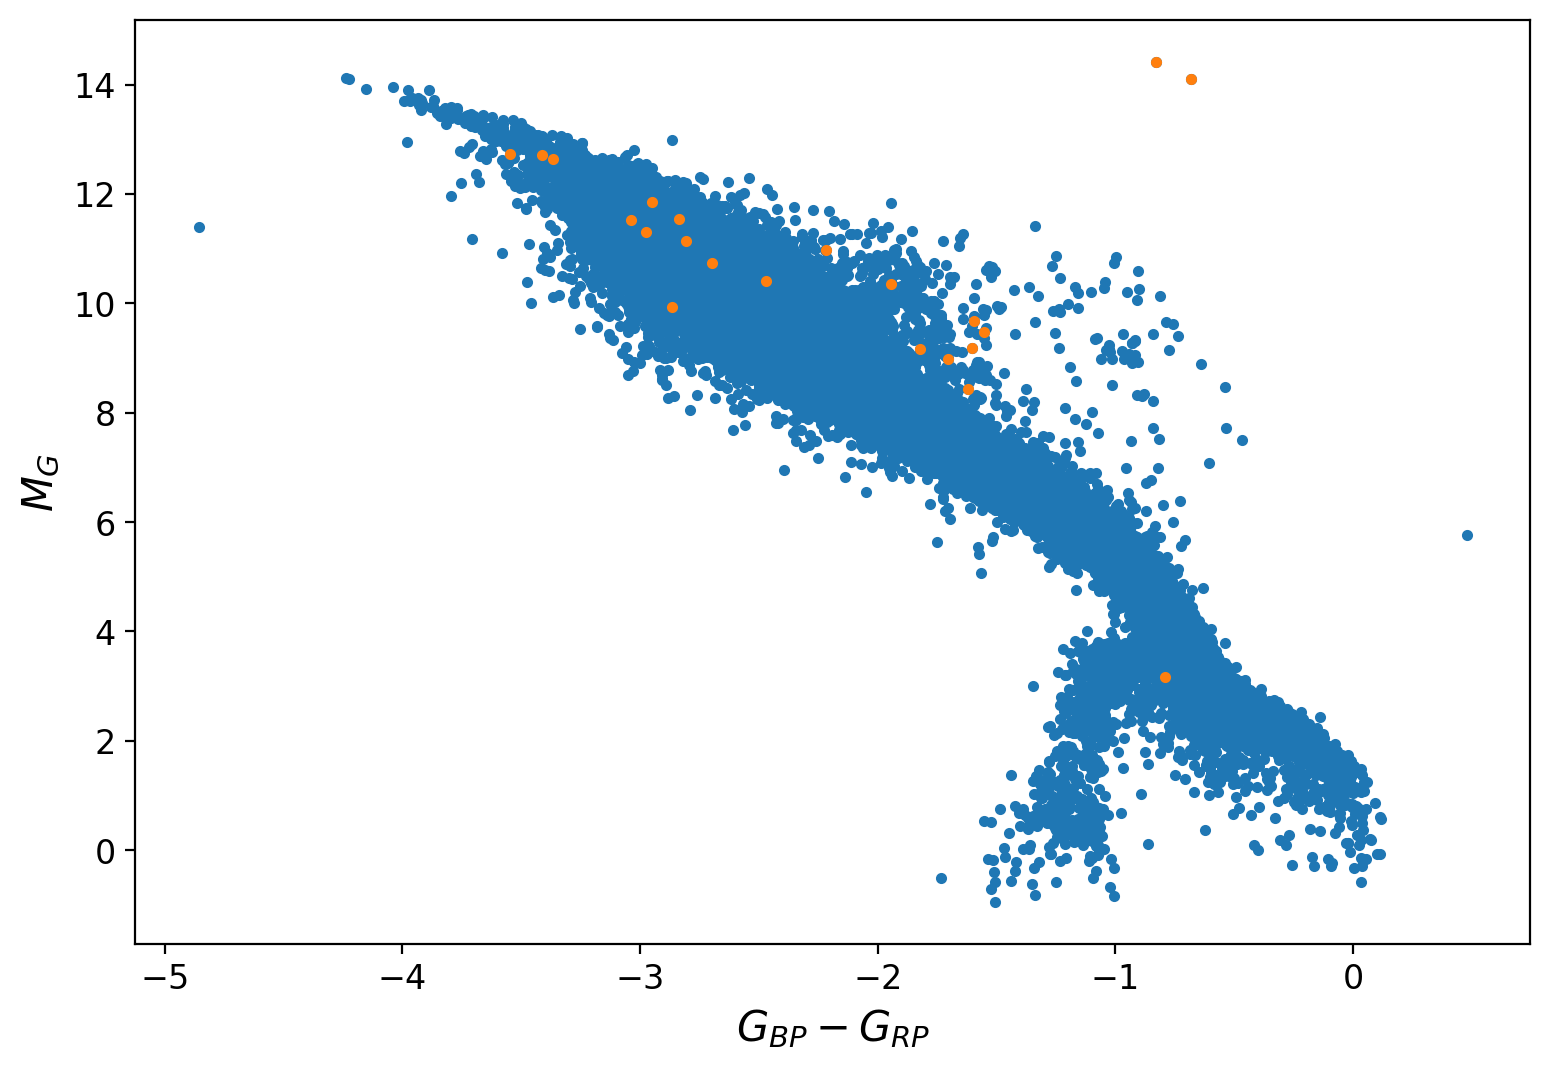

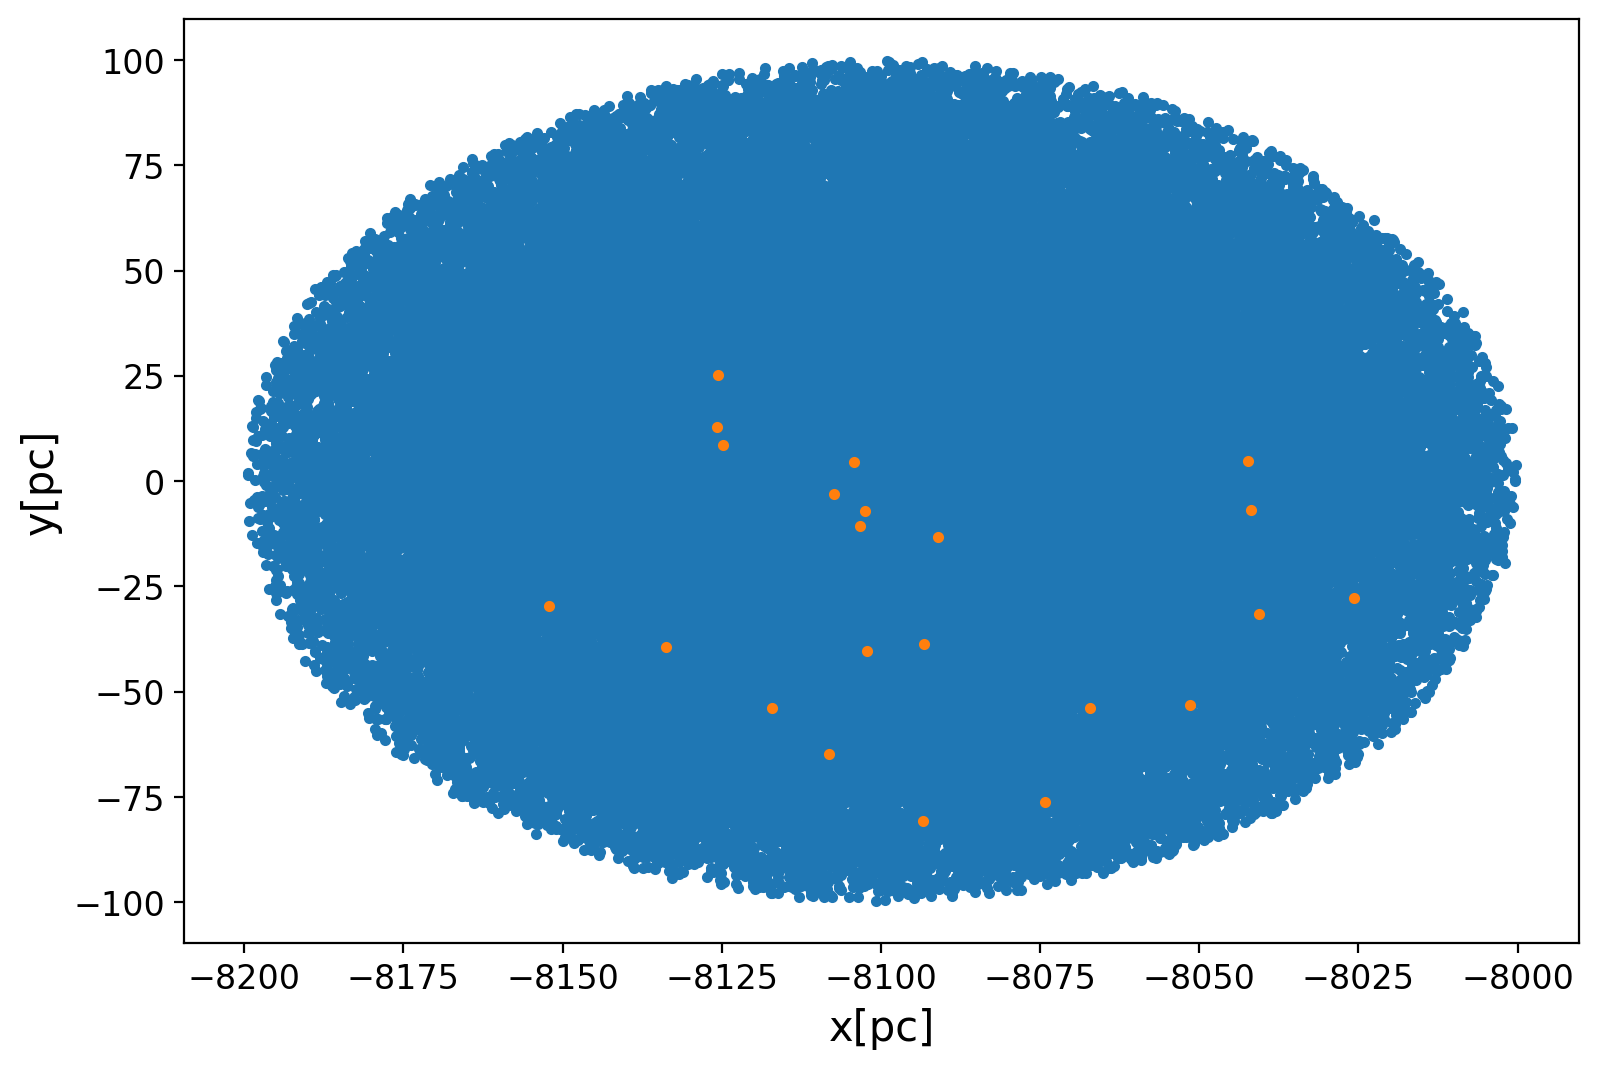

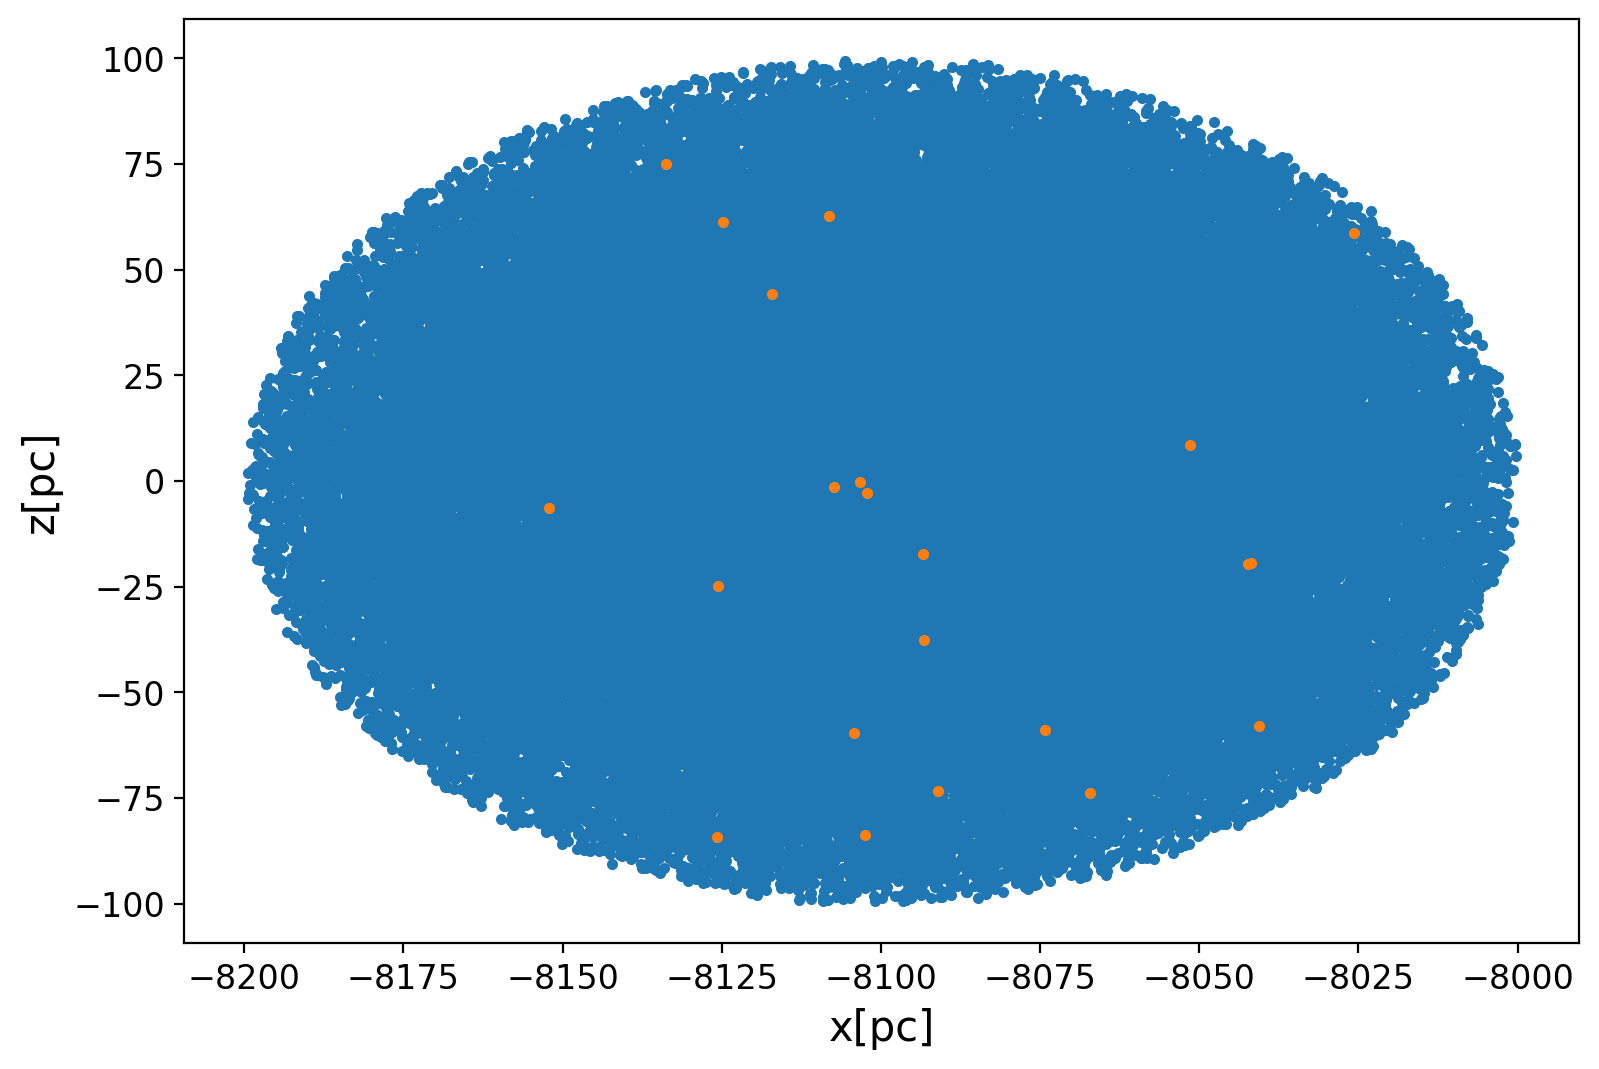

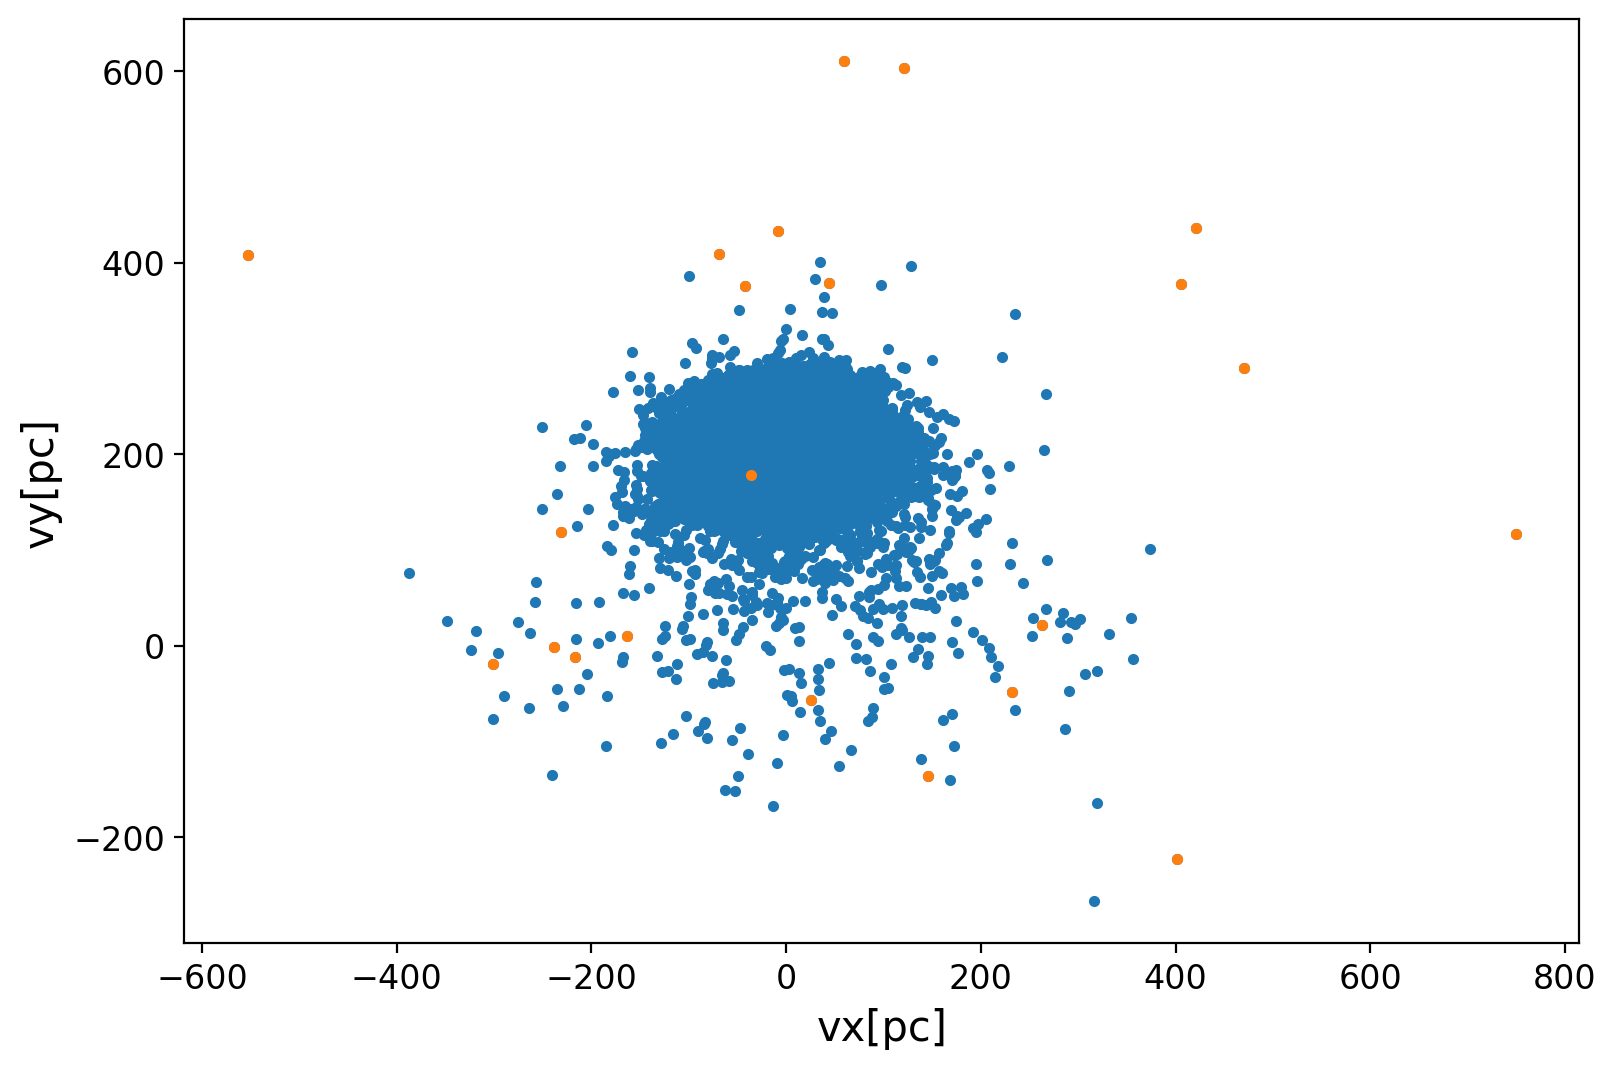

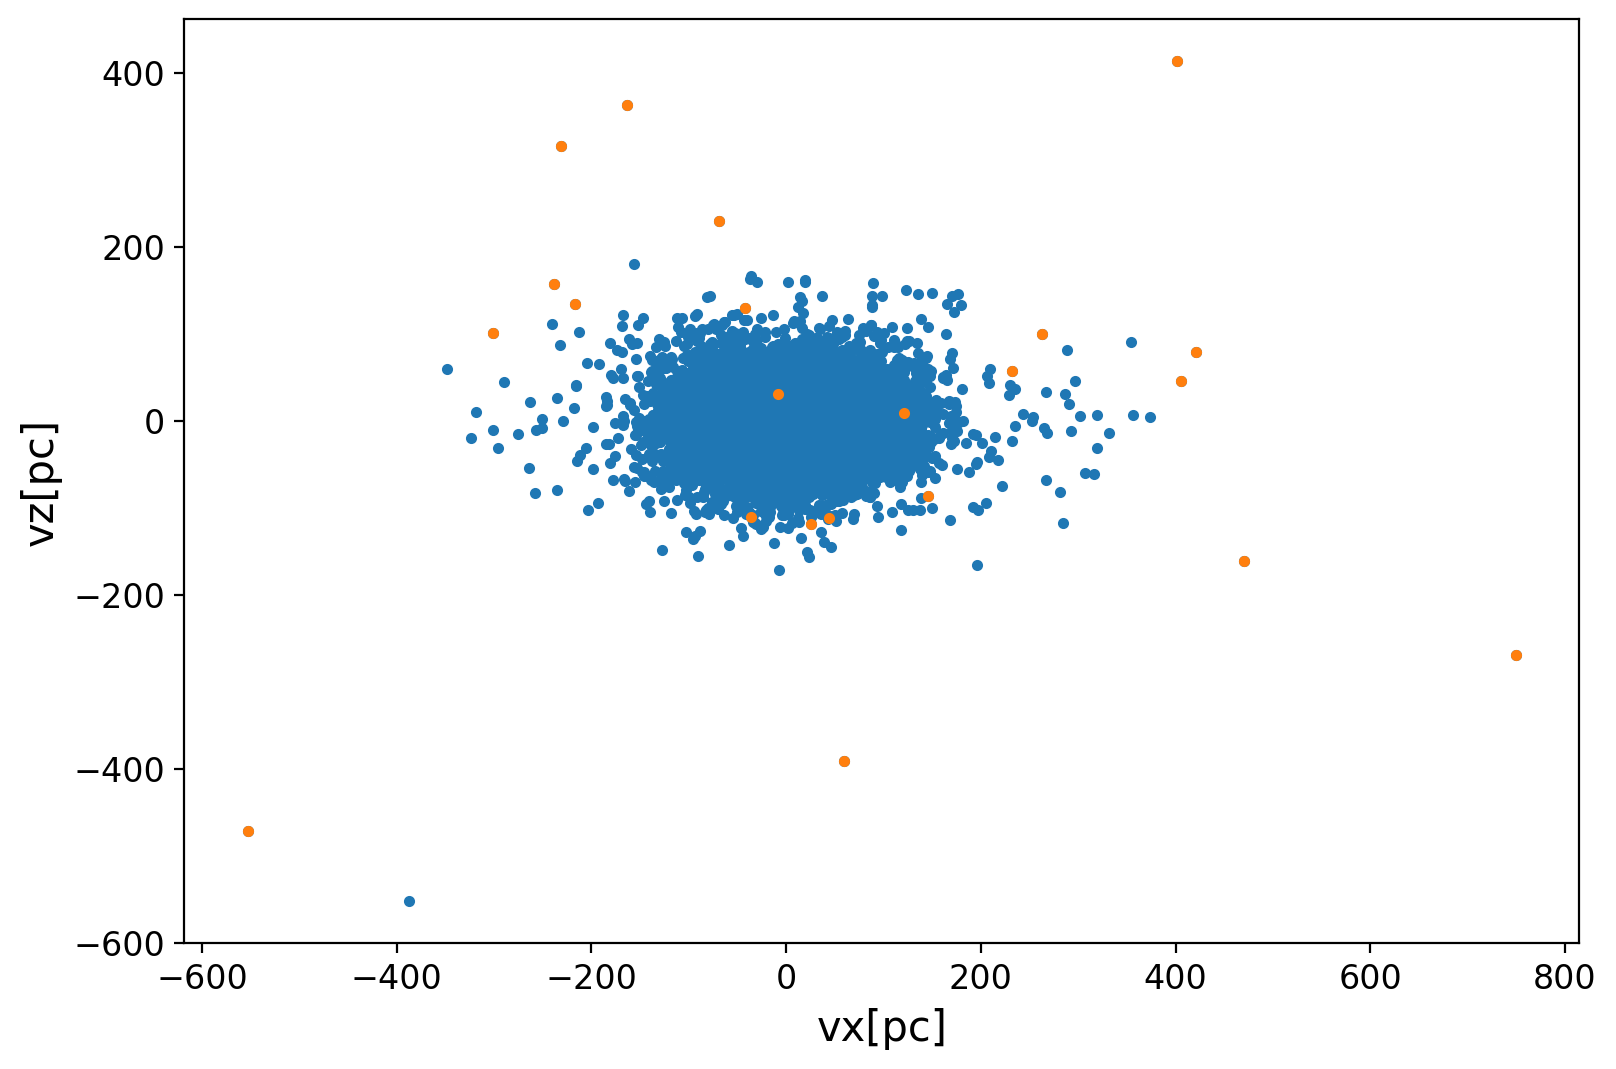

total Anoms 22
[        nan  0.49577373  3.72229689  3.56048795  0.21853159  2.22508186
  3.36407257         nan 32.72386946  1.59439137         nan  7.34758257
  5.74697702 10.89781998  0.93711358         nan 49.41507155  7.12939069
 36.94605822  8.54032158  2.85665655  1.2423828 ] kpc !! Anom 1


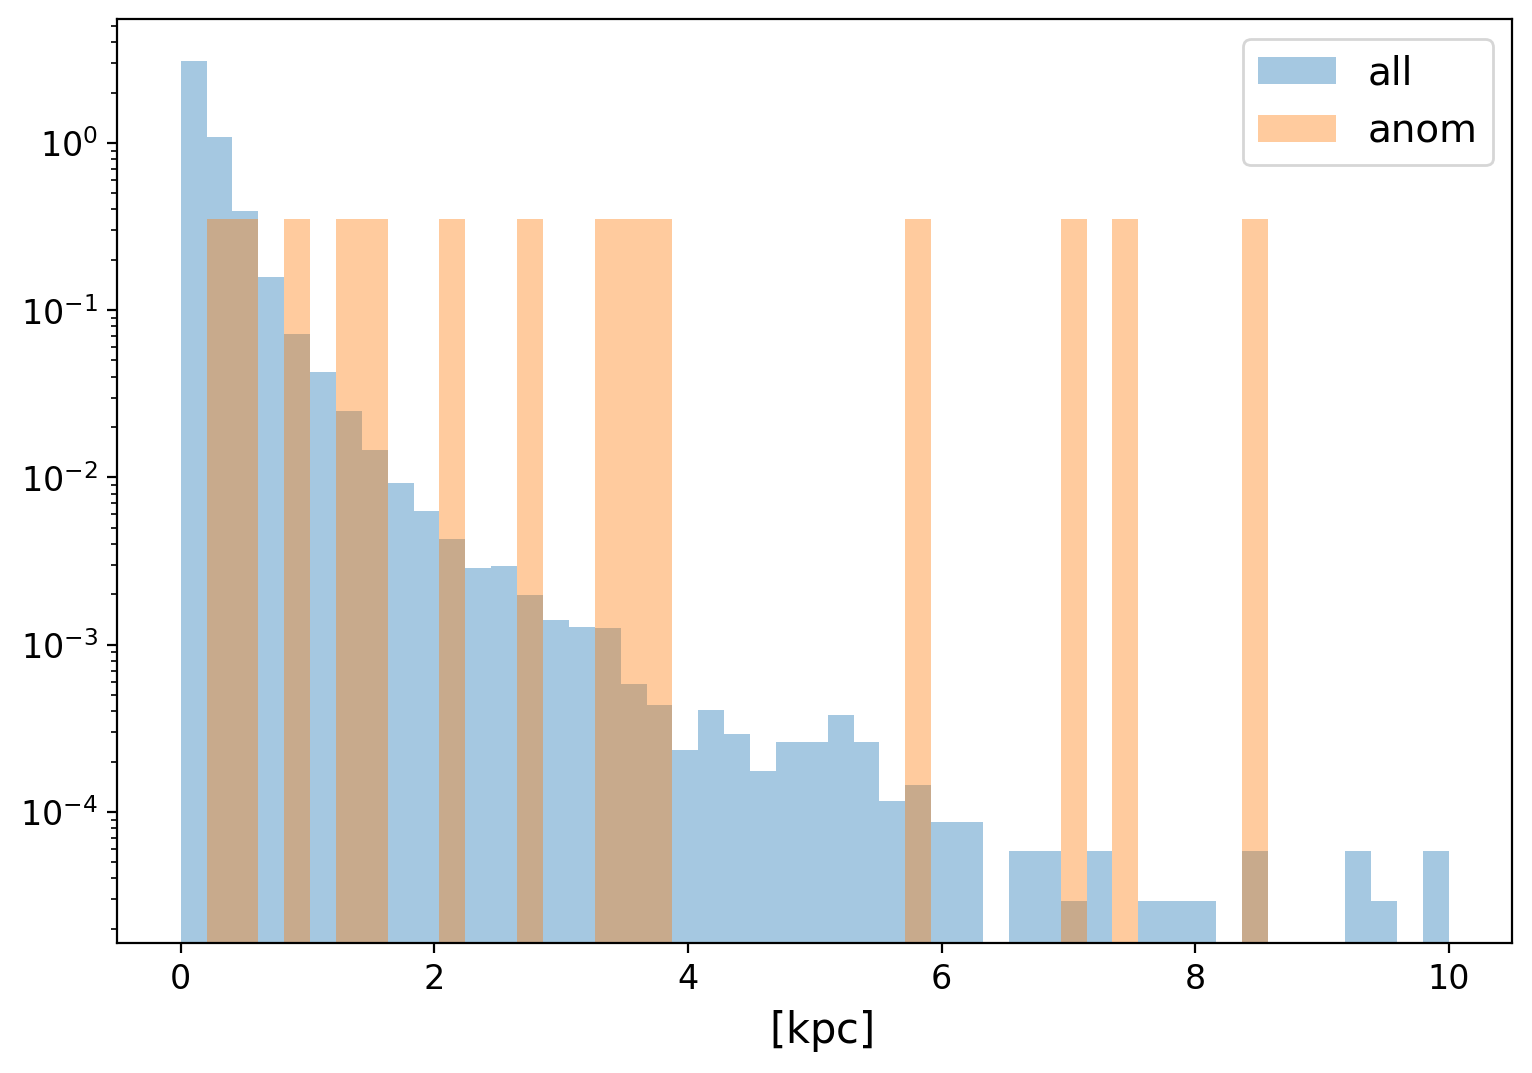

[       nan        nan 0.90596337 0.59934489        nan 0.54313513
        nan        nan 0.71644309        nan        nan 0.67900917
 0.67499062 0.81125172 0.77832707        nan        nan 0.94646474
 0.77737201 0.86708139 0.17474239 0.8814087 ] !! Anom 2


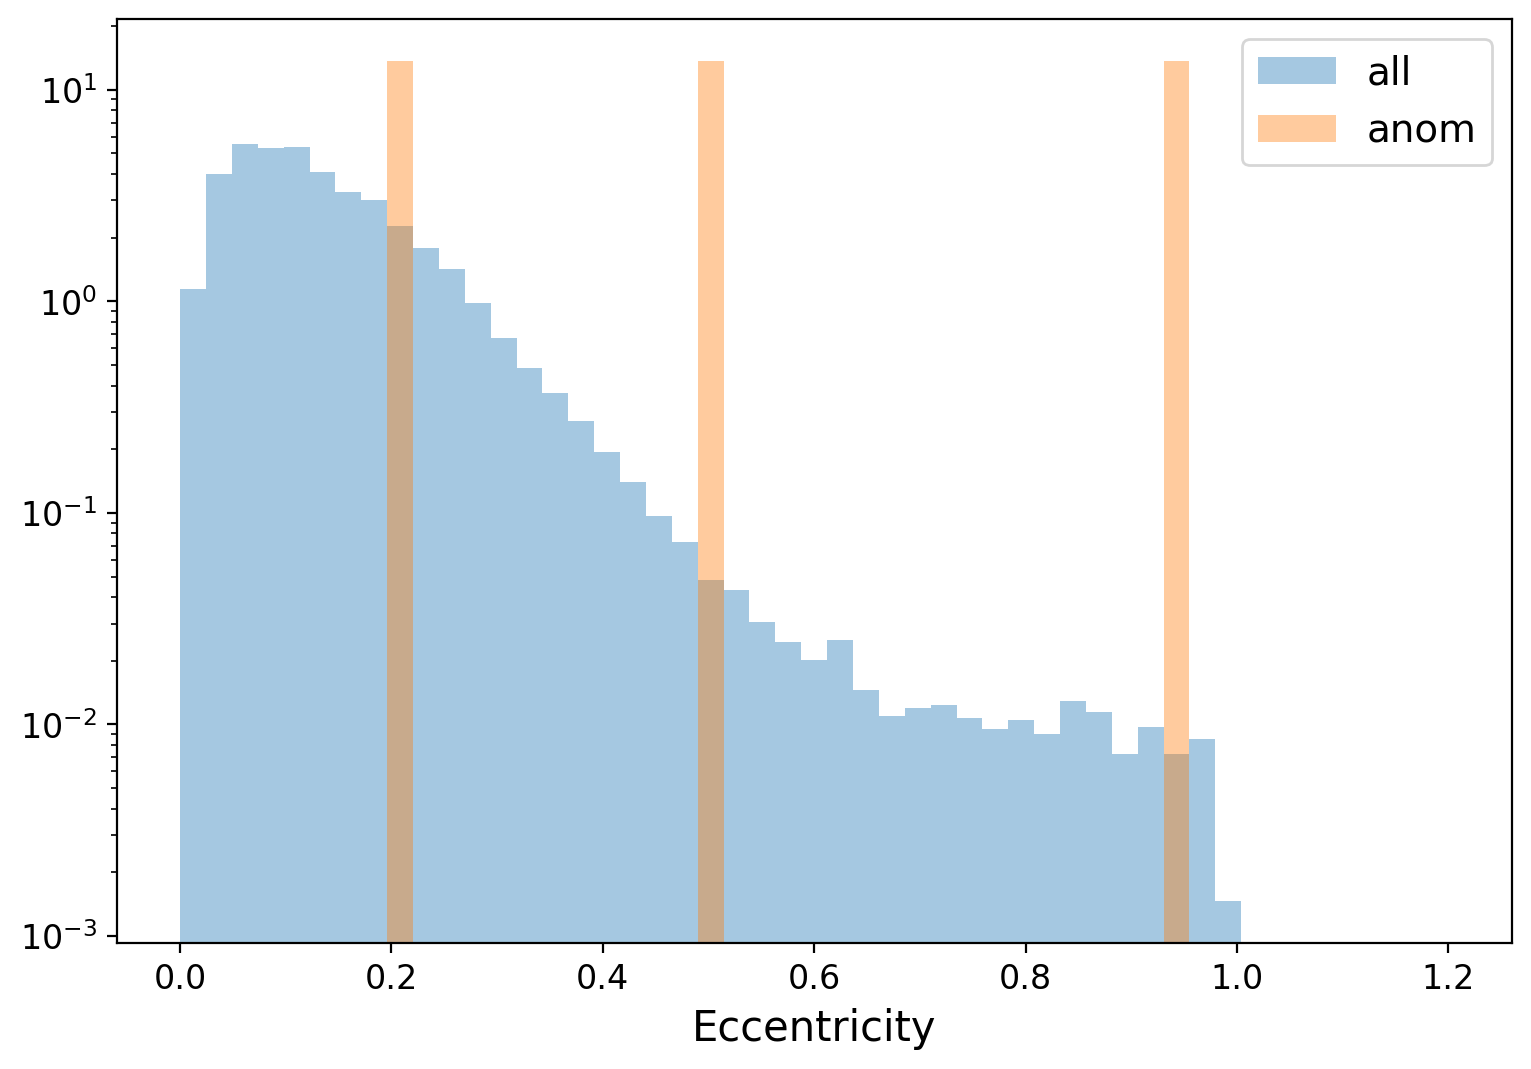

In [357]:
plotAnomalyBasic(50,processed_data_raw,testloss,galcen_clean,orbits_all)
plotAnomalyComplex(50,processed_data_raw,testloss,galcen_clean,orbits_all,ecc_all,zmax_all)

In [358]:
print(gaia_data)

        ra                 dec              parallax              pmra               pmdec          radial_velocity    phot_g_mean_mag    phot_bp_mean_mag   phot_rp_mean_mag 
       deg                 deg                mas               mas / yr            mas / yr             km / s              mag                mag                mag        
------------------ ------------------- ------------------ ------------------- ------------------- ------------------- ------------------ ------------------ ------------------
132.10459270933268   2.271051596123523 12.599344304105063   4.013977357436915   66.10200703095197   35.98448181152344  11.12310791015625 11.694805145263672 10.408632278442383
251.09760693925082 -56.960100359866715 11.304311485078195  -35.37191646771424  -99.37431063079273   6.397059440612793 12.686421394348145 13.584908485412598 11.753893852233887
283.11044937721783 -26.150079226853457  12.38950294033803 -25.433928851662223  -58.70845697387051  -16.85479736328125 15.1740